In [1]:
from micecat import *
from run_fit import *
from reduction import *
data_maps = {1: image_reduction(1), 2: image_reduction(2)}

srcinfo = {}
xe2_W19 = gal_profile_model().Wang19_profile(0,3)['params']['sersic2'][2]
dfmc = get_micecat_df(0, add_Rvir=True)

mrrdata = loadmat(mypaths['ciberdir']+'doc/20170617_Stacking/maps/mrrcats/mrr_cat_SWIRE.mat')
dfmrr = pd.DataFrame()
column_names = ['ra','dec','zm','zme','mst','z','av','ze','npts','mass'] # data['cat'][0].dtype
for i,name in enumerate(column_names):
    dfmrr[name] = mrrdata['cat'][0,0][i].flatten()
dfmrr = dfmrr.loc[dfmrr['mst']>0]
dfmrr = dfmrr.loc[dfmrr['mass']!=0]

for i,(im,M_min,M_max) in enumerate(zip([1,2,3,2,3],[-23,-23,-23,-22,-22],[-22,-22,-22,-21,-21])):
    m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
    srcinfo[i] = {'im':im, 'm_min':m_min, 'm_max':m_max, 'M_min':M_min, 'M_max':M_max}
    
    dfi = dfmc.loc[(dfmc['I']>=m_min) & (dfmc['I']<m_max) & (dfmc['M_I']>=M_min) & (dfmc['M_I']<M_max)]
    srcinfo[i]['R200_mc'] = 1e3 * dfi['Rv_Mpc'].values # [kpc]
    srcinfo[i]['logMh'] = dfi['lmhalo'].values
    srcinfo[i]['z'] = np.array([])
    for ifield in [4,5,6,7,8]:
        print(i,ifield)
        mask_inst1, mask_inst2 = load_processed_images(data_maps,
                              return_names=[(1,ifield,'mask_inst'),(2,ifield,'mask_inst')])
        field = fieldnamedict[ifield]
        srcdat = ps_src_select(1, ifield, m_min, m_max, [mask_inst1, mask_inst2],
                               Mabs_min=M_min, Mabs_max=M_max, sample_type='all')
        srcinfo[i]['z'] = np.concatenate((srcinfo[i]['z'],np.array(srcdat['zg_arr'])))        
    DA_Mpc = cosmo.angular_diameter_distance(srcinfo[i]['z']).value
    srcinfo[i]['kpc_per_arcsec'] = DA_Mpc * (u.Mpc/u.rad).to(u.kpc/u.arcsec)
    
    # get Mstr from MRR cat
    srcdat = ps_src_select(1, 8, m_min, m_max, 
        [mask_inst1, mask_inst2], sample_type='all')
    dfps = pd.read_csv(mypaths['PScatdat'] + fieldnamedict[8] + '.csv')
    dfps = dfps.iloc[srcdat['idxg_arr']]
    dfps, dfmrr1 = match_catalog_by_coord(dfps,dfmrr)
    dfps['mass'] = dfmrr1['mass'].values
    DM = 5 * np.log10((cosmo.luminosity_distance(dfps['Photz']) / (10 * u.pc)).decompose()).value
    Ms = dfps['I_comb'] - DM + (2.5 * np.log10(1+dfps['Photz']))
    dfps['Mabs'] = Ms
    sp = np.where((dfps['Mabs']>=M_min) & (dfps['Mabs']<M_max))[0]
    logMstr = dfps['mass'].iloc[sp].values
    srcinfo[i]['logMstr'] = logMstr
    
    for inst in [1,2]:
        savename='mcmc_3par_joint_m%d_%d_Mabs%d_%d.npy'%(m_min,m_max,M_min,M_max)
        fitparamdat,flatsamps = get_mcmc_fit_params_3par(inst,im, ifield=ifield,savename=savename,
                                              return_samples=True)
        Re2_samps = (flatsamps[:,0] * fitparamdat['R200'])[::5].reshape(-1,1)
        kpc_per_arcsec = srcinfo[i]['kpc_per_arcsec'].reshape(1,-1)
        Re2_kpc_samps = (Re2_samps@kpc_per_arcsec).flatten()
        srcinfo[i]['Re2_'+str(inst)] = np.median(Re2_kpc_samps)
        srcinfo[i]['Re2_low_'+str(inst)] = np.percentile(Re2_kpc_samps,16)
        srcinfo[i]['Re2_high_'+str(inst)] = np.percentile(Re2_kpc_samps,84)
        srcinfo[i]['Re2_'+str(inst)+'_arcsec'] = fitparamdat['Re2']
        srcinfo[i]['Re2_low_'+str(inst)+'_arcsec'] = fitparamdat['Re2_low']
        srcinfo[i]['Re2_high_'+str(inst)+'_arcsec'] = fitparamdat['Re2_high']
        srcinfo[i]['A1h_'+str(inst)] = fitparamdat['A1h']
        srcinfo[i]['A1h_low_'+str(inst)] = fitparamdat['A1h_low']
        srcinfo[i]['A1h_high_'+str(inst)] = fitparamdat['A1h_high']
        srcinfo[i]['A2h_'+str(inst)] = fitparamdat['A2h']
        srcinfo[i]['A2h_low_'+str(inst)] = fitparamdat['A2h_low']
        srcinfo[i]['A2h_high_'+str(inst)] = fitparamdat['A2h_high']
        
        rbins, mc_avg, mc_std, _ = get_micecat_sim_1h(inst, im, Mhcut=1e14, R200cut=0, zcut=0.15)
        srcinfo[i]['MC1h_rbins'+str(inst)] = rbins
        srcinfo[i]['MC1h_avg'+str(inst)] = mc_avg
        srcinfo[i]['MC1h_std'+str(inst)] = mc_std
        rbins, _, mc_avg_fit, _, _, _ = micecat_profile_fit(inst,im, return_full=True)
        srcinfo[i]['MC2h_rbins'+str(inst)] = rbins
        srcinfo[i]['MC2h_avg'+str(inst)] = mc_avg_fit

# get R50
# for i,(im,M_min,M_max) in enumerate(zip([1,2,3,2,3],[-23,-23,-23,-22,-22],[-22,-22,-22,-21,-21])):
#     m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
#     srcinfo[i]['dfpetro'] = pd.DataFrame()
#     for ifield in [4,5,6,7,8]:
#         print('get petro mag bin #%d, ifield%d'%(i, ifield))
#         dfpetro = pd.read_csv('/Volumes/Drive/ciber/data/SDSScats/%s_petro.csv'\
#                       %fieldnamedict[ifield],skiprows=1, low_memory=False)
#         mask_inst1, mask_inst2 = load_processed_images(data_maps,
#                               return_names=[(1,ifield,'mask_inst'),(2,ifield,'mask_inst')])
#         field = fieldnamedict[ifield]
#         srcdat = ps_src_select(1, ifield, m_min, m_max, 
#             [mask_inst1, mask_inst2], Mabs_min=M_min, Mabs_max=M_max, sample_type='all')
#         dfpsi = pd.read_csv(mypaths['PScatdat'] + fieldnamedict[ifield] + '.csv')
#         dfpsi = dfpsi.iloc[srcdat['idxg_arr']]
#         dfpsi, dfpetroi = match_catalog_by_coord(dfpsi,dfpetro)
#         dfpsi=dfpsi.reset_index(drop=True)
#         dfpetroi=dfpetroi.reset_index(drop=True)
#         dfpsi = dfpsi.join(dfpetroi,lsuffix='_ps', rsuffix='_petro')
#         srcinfo[i]['dfpetro'] = pd.concat([srcinfo[i]['dfpetro'], 
#                 dfpsi[['petroR50_u','petroR50_g','petroR50_r','petroR50_i','petroR50_z']]])

MICECAT field 0, 0 < ra < 2, 0 < dec < 2
0 4
0 5
0 6
0 7
0 8
1 4
1 5
1 6
1 7
1 8
2 4
2 5
2 6
2 7
2 8
3 4
3 5
3 6
3 7
3 8
4 4
4 5
4 6
4 7
4 8


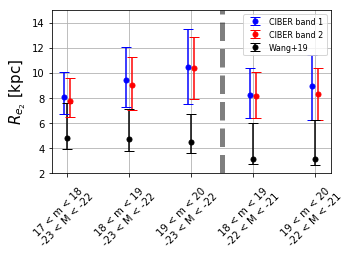

In [51]:
from run_fit import *

fig, ax = plt.subplots(1,1,figsize=(5,3))
xe2_W19 = gal_profile_model().Wang19_profile(0,3)['params']['sersic2'][2]
for j,(inst,c) in enumerate(zip([1,2], ['b','r'])):
    xoff = -0.05 if inst==1 else 0.05
    Re2_arr = np.zeros(5)
    Re2_low_arr = np.zeros(5)
    Re2_high_arr = np.zeros(5)
    Re2_W19_arr = np.zeros(5)
    Re2_W19_low_arr = np.zeros(5)
    Re2_W19_high_arr = np.zeros(5)
    kpc_per_arcsec_avg_arr = np.zeros(5)
    kpc_per_arcsec_err_arr = np.zeros(5)
    xlabel_arr = []
    for i,(im,M_min,M_max) in enumerate(zip([1,2,3,2,3],
                                            [-23,-23,-23,-22,-22],
                                            [-22,-22,-22,-21,-21])):

        m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
        xlabel_arr.append('%d < m < %d \n %d < M < %d \n'%(m_min,m_max, M_min, M_max))

        Re2_W19_arr[i] = np.median(srcinfo[i]['R200_mc']) * xe2_W19
        Re2_W19_low_arr[i] = np.percentile(srcinfo[i]['R200_mc'], 16) * xe2_W19
        Re2_W19_high_arr[i] = np.percentile(srcinfo[i]['R200_mc'], 84) * xe2_W19

        Re2_arr[i] = srcinfo[i]['Re2_'+str(inst)] 
        Re2_low_arr[i] =srcinfo[i]['Re2_low_'+str(inst)]
        Re2_high_arr[i] = srcinfo[i]['Re2_high_'+str(inst)]

    m_arr = np.arange(5)

    ax.errorbar(m_arr+xoff, Re2_arr, [Re2_arr - Re2_low_arr, Re2_high_arr - Re2_arr],
                  fmt='.', capsize=5, markersize=10, c=c, label = 'CIBER band %d'%inst)
    
ax.errorbar(m_arr, Re2_W19_arr, [Re2_W19_arr - Re2_W19_low_arr,
                                     Re2_W19_high_arr - Re2_W19_arr],
          fmt='.', capsize=5, markersize=10, c='k', label = 'Wang+19')
ax.legend(loc=1,fontsize=8)
ax.set_ylabel(r"$R_{e_2}$ [kpc]", fontsize=15)
ax.set_xticks([0,1,2,3,4])
ax.set_ylim([2,15])
ax.set_xticklabels(xlabel_arr,rotation = 45)
ax.axvline(2.5, c='k',lw=5, ls='--',alpha=0.5)
ax.grid()
plt.savefig('plots/paperfig/params_best_3par_kpc.png', dpi = 200, bbox_inches='tight')

/Users/ytcheng/ciber/python_ciber/stack_modelfit/utils.py:187: RuntimeWarning: overflow encountered in power
  I_arr = (10**Ie) * np.exp(-bn*((x_arr/xe)**(1/n)-1))


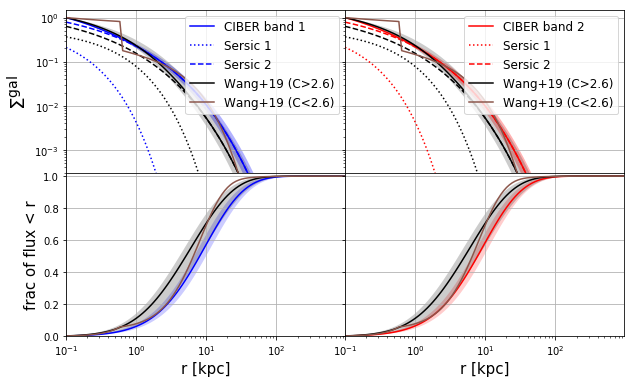

In [12]:
from run_fit import *

fig, ax = plt.subplots(2,2,figsize=(10,6))
plt.subplots_adjust(hspace=.0, wspace=.0)
ax[0][0].tick_params(axis='x',labelbottom=False)
ax[0][1].tick_params(axis='both',labelbottom=False,labelleft=False)
ax[1][1].tick_params(axis='y',labelleft=False)

r_arr = np.logspace(-1,3,100)
xe2_W19 = gal_profile_model().Wang19_profile(0,3)['params']['sersic2'][2]
i = 0
for j,(inst,c) in enumerate(zip([1,2], ['b','r'])):

    im,m_min, m_max = srcinfo[i]['im'],srcinfo[i]['m_min'],srcinfo[i]['m_max']
    M_min, M_max = srcinfo[i]['M_min'],srcinfo[i]['M_max']
    
    R200 = np.median(srcinfo[i]['R200_mc'])
    R200_low = np.percentile(srcinfo[i]['R200_mc'], 16)
    R200_high = np.percentile(srcinfo[i]['R200_mc'], 84)

    Re2 = srcinfo[i]['Re2_'+str(inst)] 
    Re2_low =srcinfo[i]['Re2_low_'+str(inst)]
    Re2_high = srcinfo[i]['Re2_high_'+str(inst)]
    
    galprofdat = gal_profile_model().Wang19_profile(r_arr, im, Re2=Re2)
    galprofdat_HSC = gal_profile_model().Wang19_profile(r_arr, im, R200=R200)
    galprofdat_HSC3 = gal_profile_model().Wang19_profile(r_arr, im, R200=R200, extendedness=True)
    p, p1, p2 = galprofdat['I_arr'],galprofdat['I1_arr'],galprofdat['I2_arr']
    p_HSC, p1_HSC, p2_HSC = galprofdat_HSC['I_arr'],galprofdat_HSC['I1_arr'],galprofdat_HSC['I2_arr']
    p_HSC3 = galprofdat_HSC3['I_arr']
    
    galprofdat = gal_profile_model().Wang19_profile(r_arr, im, Re2=Re2_high)
    galprofdat_HSC = gal_profile_model().Wang19_profile(r_arr, im, R200=R200_high)
    galprofdat_HSC3 = gal_profile_model().Wang19_profile(r_arr, im, R200=R200_high, extendedness=True)
    p_high, p1_high, p2_high = galprofdat['I_arr'],galprofdat['I1_arr'],galprofdat['I2_arr']
    p_high_HSC = galprofdat_HSC['I_arr']
    p_high_HSC3 = galprofdat_HSC3['I_arr']
    
    galprofdat = gal_profile_model().Wang19_profile(r_arr, im, Re2=Re2_low)
    galprofdat_HSC = gal_profile_model().Wang19_profile(r_arr, im, R200=R200_low)
    galprofdat_HSC3 = gal_profile_model().Wang19_profile(r_arr, im, R200=R200_low, extendedness=True)
    p_low, p1_low, p2_low = galprofdat['I_arr'],galprofdat['I1_arr'],galprofdat['I2_arr']
    p_low_HSC  = galprofdat_HSC['I_arr']
    p_low_HSC3 = galprofdat_HSC3['I_arr']
    
    ax[0][j].loglog(r_arr, p/p[0],c=c,label='CIBER band %d'%inst)
    ax[0][j].loglog(r_arr, p1/p[0],':',c=c,label='Sersic 1')
    ax[0][j].loglog(r_arr,p2/p[0],'--',c=c,label='Sersic 2')
    ax[0][j].fill_between(r_arr, p_low/p_low[0], p_high/p_high[0],
                          facecolor=c, alpha=0.3)
    ax[0][j].loglog(r_arr,p_HSC/p_HSC[0],'k',label='Wang+19 (C>2.6)')
    ax[0][j].loglog(r_arr, p1_HSC/p_HSC[0],'k:')
    ax[0][j].loglog(r_arr,p2_HSC/p_HSC[0],'k--')
    ax[0][j].fill_between(r_arr, p_low_HSC/p_low_HSC[0], p_high_HSC/p_high_HSC[0],
                          facecolor='k', alpha=0.2)
    ax[0][j].loglog(r_arr,p_HSC3/p_HSC3[0],'C5',label='Wang+19 (C<2.6)')
    ax[1][j].semilogx(r_arr, np.cumsum(p*r_arr**2)/np.sum(p*r_arr**2),c=c)
    ax[1][j].fill_between(r_arr, np.cumsum(p_high*r_arr**2)/np.sum(p_high*r_arr**2),
                         np.cumsum(p_low*r_arr**2)/np.sum(p_low*r_arr**2),
                         facecolor=c, alpha=0.2)

    ax[1][j].semilogx(r_arr, np.cumsum(p_HSC*r_arr**2)/np.sum(p_HSC*r_arr**2),'k')
    ax[1][j].fill_between(r_arr, np.cumsum(p_high_HSC*r_arr**2)/np.sum(p_high_HSC*r_arr**2),
                         np.cumsum(p_low_HSC*r_arr**2)/np.sum(p_low_HSC*r_arr**2),
                         facecolor='k', alpha=0.2)
    ax[1][j].semilogx(r_arr, np.cumsum(p_HSC3*r_arr**2)/np.sum(p_HSC3*r_arr**2),'C5')
    ax[0][j].set_ylim([3e-4,1.5])
    ax[0][j].set_xlim([1e-1,9.5e2])   
    ax[1][j].set_xlim([1e-1,9.5e2]) 
    ax[1][j].set_ylim([0,1.02])
    ax[0][j].legend(loc=1,fontsize=12)
    ax[0][j].grid()
    ax[1][j].grid()
    ax[1][j].set_xlabel('r [kpc]',fontsize=15)
ax[0][0].set_ylabel(r'$\Sigma^{\rm gal}$',fontsize=20)
ax[1][0].set_ylabel('frac of flux < r',fontsize=15)
plt.savefig('plots/paperfig/gal_prof_fit_m%d_%d_M%d_%d.png'%(m_min,m_max,M_min,M_max),
            dpi = 150, bbox_inches='tight')

/Users/ytcheng/ciber/python_ciber/stack_modelfit/utils.py:187: RuntimeWarning: overflow encountered in power
  I_arr = (10**Ie) * np.exp(-bn*((x_arr/xe)**(1/n)-1))


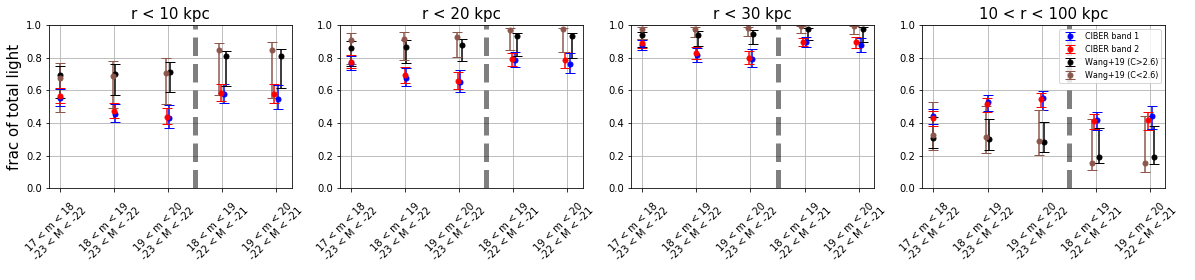

In [4]:
from run_fit import *

r_arr = np.logspace(-1,3,100)
# xe2_W19 = gal_profile_model().Wang19_profile(0,3)['params']['sersic2'][2]

sp_arr = []
sp_arr.append(np.where(r_arr < 10)[0])
sp_arr.append(np.where(r_arr < 20)[0])
sp_arr.append(np.where(r_arr < 30)[0])
sp_arr.append(np.where((r_arr > 10) & (r_arr<100))[0])

f1_arr = np.zeros([4,3,5])
f2_arr = np.zeros([4,3,5])
fHSC_arr = np.zeros([4,3,5])
fHSC3_arr = np.zeros([4,3,5])
xlabel_arr = []
for i in range(5):
    im,m_min, m_max = srcinfo[i]['im'],srcinfo[i]['m_min'],srcinfo[i]['m_max']
    M_min, M_max = srcinfo[i]['M_min'],srcinfo[i]['M_max']
    xlabel_arr.append('%d < m < %d \n %d < M < %d \n'%(m_min,m_max, M_min, M_max))
    R200 = np.median(srcinfo[i]['R200_mc'])
    R200_low = np.percentile(srcinfo[i]['R200_mc'], 16)
    R200_high = np.percentile(srcinfo[i]['R200_mc'], 84)
    
    galprofdat_HSC = gal_profile_model().Wang19_profile(r_arr, im, R200=R200)
    galprofdat_HSC3 = gal_profile_model().Wang19_profile(r_arr, im, R200=R200, extendedness=True)
    p_HSC = galprofdat_HSC['I_arr']
    p_HSC3 = galprofdat_HSC3['I_arr']

    galprofdat_HSC = gal_profile_model().Wang19_profile(r_arr, im, R200=R200_high)
    galprofdat_HSC3 = gal_profile_model().Wang19_profile(r_arr, im, R200=R200_high, extendedness=True)
    p_high_HSC = galprofdat_HSC['I_arr']
    p_high_HSC3 = galprofdat_HSC3['I_arr']
    
    galprofdat_HSC = gal_profile_model().Wang19_profile(r_arr, im, R200=R200_low)
    galprofdat_HSC3 = gal_profile_model().Wang19_profile(r_arr, im, R200=R200_low, extendedness=True)
    p_low_HSC  = galprofdat_HSC['I_arr']
    p_low_HSC3 = galprofdat_HSC3['I_arr']
    
    for isp, sp in enumerate(sp_arr):
        fHSC_arr[isp,0,i] = np.sum(p_HSC[sp]*r_arr[sp]**2)/np.sum(p_HSC*r_arr**2)
        fHSC_arr[isp,1,i] = np.sum(p_low_HSC [sp]*r_arr[sp]**2)/np.sum(p_low_HSC*r_arr**2)
        fHSC_arr[isp,2,i] = np.sum(p_high_HSC[sp]*r_arr[sp]**2)/np.sum(p_high_HSC*r_arr**2)
        fHSC3_arr[isp,0,i] = np.sum(p_HSC3[sp]*r_arr[sp]**2)/np.sum(p_HSC3*r_arr**2)
        fHSC3_arr[isp,1,i] = np.sum(p_low_HSC3[sp]*r_arr[sp]**2)/np.sum(p_low_HSC3*r_arr**2)
        fHSC3_arr[isp,2,i] = np.sum(p_high_HSC3[sp]*r_arr[sp]**2)/np.sum(p_high_HSC3*r_arr**2)

    for inst in [1,2]:
        Re2 = srcinfo[i]['Re2_'+str(inst)] 
        Re2_low =srcinfo[i]['Re2_low_'+str(inst)]
        Re2_high = srcinfo[i]['Re2_high_'+str(inst)]

        galprofdat = gal_profile_model().Wang19_profile(r_arr, im, Re2=Re2)
        p = galprofdat['I_arr']

        galprofdat = gal_profile_model().Wang19_profile(r_arr, im, Re2=Re2_high)
        p_high = galprofdat['I_arr']

        galprofdat = gal_profile_model().Wang19_profile(r_arr, im, Re2=Re2_low)
        p_low = galprofdat['I_arr']

        for isp, sp in enumerate(sp_arr):
            if inst==1:
                f1_arr[isp,0,i] = np.sum(p[sp]*r_arr[sp]**2)/np.sum(p*r_arr**2)
                f1_arr[isp,1,i] = np.sum(p_low[sp]*r_arr[sp]**2)/np.sum(p_low*r_arr**2)
                f1_arr[isp,2,i] = np.sum(p_high[sp]*r_arr[sp]**2)/np.sum(p_high*r_arr**2)
            else:
                f2_arr[isp,0,i] = np.sum(p[sp]*r_arr[sp]**2)/np.sum(p*r_arr**2)
                f2_arr[isp,1,i] = np.sum(p_low[sp]*r_arr[sp]**2)/np.sum(p_low*r_arr**2)
                f2_arr[isp,2,i] = np.sum(p_high[sp]*r_arr[sp]**2)/np.sum(p_high*r_arr**2)

fig, ax = plt.subplots(1,4,figsize=(20,3))

x_arr = np.arange(5)
for isp in range(4):
    ax[isp].errorbar(x_arr*1.01, f1_arr[isp,0],[f1_arr[isp,0] - f1_arr[isp,2],
                                           f1_arr[isp,1] - f1_arr[isp,0]],
                    fmt='.', capsize=5, markersize=10, c='b', label = 'CIBER band 1')
    ax[isp].errorbar(x_arr*0.99, f2_arr[isp,0],[f2_arr[isp,0] - f2_arr[isp,2],
                                           f2_arr[isp,1] - f2_arr[isp,0]],
                    fmt='.', capsize=5, markersize=10, c='r', label = 'CIBER band 2')
    ax[isp].errorbar(x_arr*1.02, fHSC_arr[isp,0],[fHSC_arr[isp,0] - fHSC_arr[isp,2],
                                            fHSC_arr[isp,1] - fHSC_arr[isp,0]],
                    fmt='.', capsize=5, markersize=10, c='k', label = 'Wang+19 (C>2.6)')
    ax[isp].errorbar(x_arr*0.98, fHSC3_arr[isp,0],[fHSC3_arr[isp,0] - fHSC3_arr[isp,2],
                                            fHSC3_arr[isp,1] - fHSC3_arr[isp,0]],
                    fmt='.', capsize=5, markersize=10, c='C5', label = 'Wang+19 (C<2.6)')

    ax[isp].set_xticks([0,1,2,3,4])
    ax[isp].set_ylim([0,1])
    ax[isp].set_xticklabels(xlabel_arr,rotation = 45)
    ax[isp].axvline(2.5, c='k',lw=5, ls='--',alpha=0.5)
    ax[isp].grid()
ax[0].set_title('r < 10 kpc', fontsize=15)
ax[1].set_title('r < 20 kpc', fontsize=15)
ax[2].set_title('r < 30 kpc', fontsize=15)
ax[3].set_title('10 < r < 100 kpc', fontsize=15)
ax[3].legend(loc=1,fontsize=8)
ax[0].set_ylabel("frac of total light", fontsize=15)
plt.savefig('plots/paperfig/frac_r.png',
            dpi = 150, bbox_inches='tight')

/Users/ytcheng/ciber/python_ciber/stack_modelfit/utils.py:187: RuntimeWarning: overflow encountered in power
  I_arr = (10**Ie) * np.exp(-bn*((x_arr/xe)**(1/n)-1))


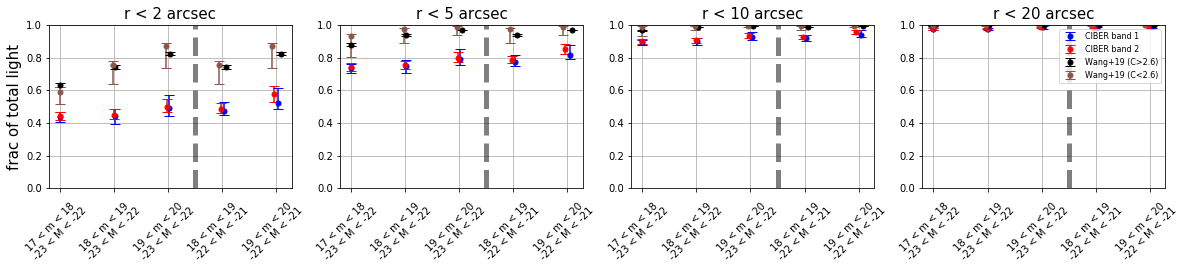

In [94]:
from run_fit import *

r_arr = np.logspace(-1,3,100)

sp_arr = []
sp_arr.append(np.where(r_arr < 2)[0])
sp_arr.append(np.where(r_arr < 5)[0])
sp_arr.append(np.where(r_arr < 10)[0])
sp_arr.append(np.where(r_arr < 20)[0])

f1_arr = np.zeros([4,3,5])
f2_arr = np.zeros([4,3,5])
fHSC_arr = np.zeros([4,3,5])
fHSC3_arr = np.zeros([4,3,5])
xlabel_arr = []
for i,(im,M_min,M_max) in enumerate(zip([1,2,3,2,3],[-23,-23,-23,-22,-22],[-22,-22,-22,-21,-21])):
    m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
    xlabel_arr.append('%d < m < %d \n %d < M < %d \n'%(m_min,m_max, M_min, M_max))

    galprofdat_HSC = gal_profile_model().Wang19_profile(r_arr, im)
    galprofdat_HSC3 = gal_profile_model().Wang19_profile(r_arr, im, extendedness=True)
    p_HSC = galprofdat_HSC['I_arr']
    p_HSC3 = galprofdat_HSC3['I_arr']
    
    W19params = gal_profile_model().Wang19_params(im,extendedness=False)
    xe2 = np.max((W19params['sersic2'][2]-W19params['sersic2_err'][2]))
    galprofdat_HSC = gal_profile_model().Wang19_profile(r_arr, im, xe2=xe2)
    W19params = gal_profile_model().Wang19_params(im,extendedness=True)
    xe2 = np.max((W19params['sersic2'][2]-W19params['sersic2_err'][2]))
    xe3 = np.max((W19params['sersic3'][2]-W19params['sersic3_err'][2]))
    galprofdat_HSC3 = gal_profile_model().Wang19_profile(r_arr, im, extendedness=True, xe2=xe2, xe3=xe3)
    p_high_HSC = galprofdat_HSC['I_arr']
    p_high_HSC3 = galprofdat_HSC3['I_arr']
    
    W19params = gal_profile_model().Wang19_params(im,extendedness=False)
    xe2 = W19params['sersic2'][2]+W19params['sersic2_err'][2]
    galprofdat_HSC = gal_profile_model().Wang19_profile(r_arr, im, xe2=xe2)
    W19params = gal_profile_model().Wang19_params(im,extendedness=True)
    xe2 = W19params['sersic2'][2]+W19params['sersic2_err'][2]
    xe3 = W19params['sersic3'][2]+W19params['sersic3_err'][2]
    galprofdat_HSC3 = gal_profile_model().Wang19_profile(r_arr, im, xe2=xe2, xe3=xe3)
    p_low_HSC  = galprofdat_HSC['I_arr']
    p_low_HSC3 = galprofdat_HSC3['I_arr']
    
    for isp, sp in enumerate(sp_arr):
        fHSC_arr[isp,0,i] = np.sum(p_HSC[sp]*r_arr[sp]**2)/np.sum(p_HSC*r_arr**2)
        fHSC_arr[isp,1,i] = np.sum(p_low_HSC [sp]*r_arr[sp]**2)/np.sum(p_low_HSC*r_arr**2)
        fHSC_arr[isp,2,i] = np.sum(p_high_HSC[sp]*r_arr[sp]**2)/np.sum(p_high_HSC*r_arr**2)
        fHSC3_arr[isp,0,i] = np.sum(p_HSC3[sp]*r_arr[sp]**2)/np.sum(p_HSC3*r_arr**2)
        fHSC3_arr[isp,1,i] = np.sum(p_low_HSC3[sp]*r_arr[sp]**2)/np.sum(p_low_HSC3*r_arr**2)
        fHSC3_arr[isp,2,i] = np.sum(p_high_HSC3[sp]*r_arr[sp]**2)/np.sum(p_high_HSC3*r_arr**2)

    for inst in [1,2]:
        savename='mcmc_3par_joint_m%d_%d_Mabs%d_%d.npy'%(m_min,m_max,M_min,M_max)
        fitparamdat = get_mcmc_fit_params_3par(inst,im, ifield=None,savename=savename)
        Re2 = fitparamdat['Re2']
        Re2_low = fitparamdat['Re2_low']
        Re2_high = fitparamdat['Re2_high']

        galprofdat = gal_profile_model().Wang19_profile(r_arr, im, Re2=Re2)
        p = galprofdat['I_arr']

        galprofdat = gal_profile_model().Wang19_profile(r_arr, im, Re2=Re2_high)
        p_high = galprofdat['I_arr']

        galprofdat = gal_profile_model().Wang19_profile(r_arr, im, Re2=Re2_low)
        p_low = galprofdat['I_arr']

        for isp, sp in enumerate(sp_arr):
            if inst==1:
                f1_arr[isp,0,i] = np.sum(p[sp]*r_arr[sp]**2)/np.sum(p*r_arr**2)
                f1_arr[isp,1,i] = np.sum(p_low[sp]*r_arr[sp]**2)/np.sum(p_low*r_arr**2)
                f1_arr[isp,2,i] = np.sum(p_high[sp]*r_arr[sp]**2)/np.sum(p_high*r_arr**2)
            else:
                f2_arr[isp,0,i] = np.sum(p[sp]*r_arr[sp]**2)/np.sum(p*r_arr**2)
                f2_arr[isp,1,i] = np.sum(p_low[sp]*r_arr[sp]**2)/np.sum(p_low*r_arr**2)
                f2_arr[isp,2,i] = np.sum(p_high[sp]*r_arr[sp]**2)/np.sum(p_high*r_arr**2)

fig, ax = plt.subplots(1,4,figsize=(20,3))

x_arr = np.arange(5)
for isp in range(4):
    ax[isp].errorbar(x_arr*1.01, f1_arr[isp,0],[f1_arr[isp,0] - f1_arr[isp,2],
                                           f1_arr[isp,1] - f1_arr[isp,0]],
                    fmt='.', capsize=5, markersize=10, c='b', label = 'CIBER band 1')
    ax[isp].errorbar(x_arr*0.99, f2_arr[isp,0],[f2_arr[isp,0] - f2_arr[isp,2],
                                           f2_arr[isp,1] - f2_arr[isp,0]],
                    fmt='.', capsize=5, markersize=10, c='r', label = 'CIBER band 2')
    ax[isp].errorbar(x_arr*1.02, fHSC_arr[isp,0],[fHSC_arr[isp,0] - fHSC_arr[isp,2],
                                            fHSC_arr[isp,1] - fHSC_arr[isp,0]],
                    fmt='.', capsize=5, markersize=10, c='k', label = 'Wang+19 (C>2.6)')
    ax[isp].errorbar(x_arr*0.98, fHSC3_arr[isp,0],[fHSC3_arr[isp,0] - fHSC3_arr[isp,2],
                                            fHSC3_arr[isp,1] - fHSC3_arr[isp,0]],
                    fmt='.', capsize=5, markersize=10, c='C5', label = 'Wang+19 (C<2.6)')

    ax[isp].set_xticks([0,1,2,3,4])
    ax[isp].set_ylim([0,1])
    ax[isp].set_xticklabels(xlabel_arr,rotation = 45)
    ax[isp].axvline(2.5, c='k',lw=5, ls='--',alpha=0.5)
    ax[isp].grid()
ax[0].set_title('r < 2 arcsec', fontsize=15)
ax[1].set_title('r < 5 arcsec', fontsize=15)
ax[2].set_title('r < 10 arcsec', fontsize=15)
ax[3].set_title('r < 20 arcsec', fontsize=15)
ax[3].legend(loc=1,fontsize=8)
ax[0].set_ylabel("frac of total light", fontsize=15)
plt.savefig('/Users/ytcheng/Desktop/frac_r_arcsec.png',
            dpi = 150, bbox_inches='tight')

/Users/ytcheng/ciber/python_ciber/stack_modelfit/utils.py:187: RuntimeWarning: overflow encountered in power
  I_arr = (10**Ie) * np.exp(-bn*((x_arr/xe)**(1/n)-1))


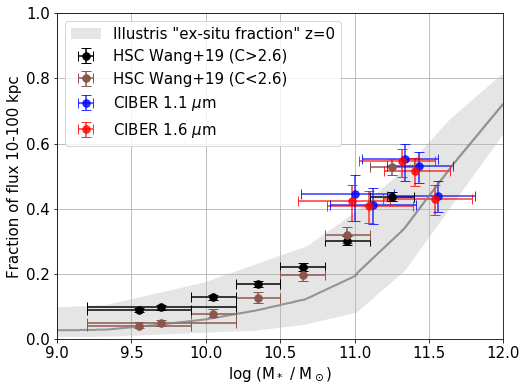

In [39]:
from run_fit import *

r_arr = np.logspace(-1,3,100)
xe2_W19 = gal_profile_model().Wang19_profile(0,3)['params']['sersic2'][2]
sp = np.where((r_arr > 10) & (r_arr<100))[0]

fig, ax = plt.subplots(1,1,figsize=(8,6))

data = np.loadtxt('Illustris_frac/Illustris_fexsitu_med.txt', delimiter=',')
plt.plot(np.log10(data[:,0]),data[:,1],c='grey',lw=2,alpha=0.8)
data_h = np.loadtxt('Illustris_frac/Illustris_fexsitu_high.txt', delimiter=',')
data_l = np.loadtxt('Illustris_frac/Illustris_fexsitu_low.txt', delimiter=',')
plt.fill_between(np.log10(data[:,0]),
                 np.interp(np.log10(data[:,0]),np.log10(data_l[:,0]),data_l[:,1]),
                 np.interp(np.log10(data[:,0]),np.log10(data_h[:,0]),data_h[:,1]),
                         facecolor='k', alpha=0.1, label='Illustris \"ex-situ fraction\" z=0')

# Wang+19 table 1
for i,(R200,Mstr_low, Mstr_high) in enumerate(zip([459.08,288.16,214.80,173.18,142.85,114.64,120.76],
                                                  [11.1,10.8,10.5,10.2,9.9,9.2,9.2],
                                                  [11.4,11.1,10.8,10.5,10.2,9.9,10.2])):
    Mstr = (Mstr_low + Mstr_high)/2
    galprofdat_HSC = gal_profile_model().Wang19_profile(r_arr, im, R200=R200)
    galprofdat_HSC3 = gal_profile_model().Wang19_profile(r_arr, im, R200=R200, extendedness=True)
    p_HSC = galprofdat_HSC['I_arr']
    p_HSC3 = galprofdat_HSC3['I_arr']

    galprofdat_HSC = gal_profile_model().Wang19_profile(r_arr, im, R200=R200, xe2= 0.0165 + 0.0008)
    galprofdat_HSC3 = gal_profile_model().Wang19_profile(r_arr, im, R200=R200, extendedness=True,
                                                        xe3=0.0001 + 0.0019, xe2=0.0231+0.0012)
    p_high_HSC = galprofdat_HSC['I_arr']
    p_high_HSC3 = galprofdat_HSC3['I_arr']

    galprofdat_HSC = gal_profile_model().Wang19_profile(r_arr, im, R200=R200, xe2= 0.0165 - 0.0008)
    galprofdat_HSC3 = gal_profile_model().Wang19_profile(r_arr, im, R200=R200, extendedness=True,
                                                        xe3=0,xe2=0.0231-0.0012)
    p_low_HSC  = galprofdat_HSC['I_arr']
    p_low_HSC3 = galprofdat_HSC3['I_arr']

    fHSC = np.sum(p_HSC[sp]*r_arr[sp]**2)/np.sum(p_HSC*r_arr**2)
    f_low_HSC = np.sum(p_low_HSC[sp]*r_arr[sp]**2)/np.sum(p_low_HSC*r_arr**2)
    f_high_HSC = np.sum(p_high_HSC[sp]*r_arr[sp]**2)/np.sum(p_high_HSC*r_arr**2)
    
    
    fHSC3 = np.sum(p_HSC3[sp]*r_arr[sp]**2)/np.sum(p_HSC3*r_arr**2)
    f_low_HSC3 = np.sum(p_low_HSC3[sp]*r_arr[sp]**2)/np.sum(p_low_HSC3*r_arr**2)
    f_high_HSC3 = np.sum(p_high_HSC3[sp]*r_arr[sp]**2)/np.sum(p_high_HSC3*r_arr**2)
    
    if i == 0:
        ax.errorbar([Mstr], [fHSC], xerr=[[Mstr-Mstr_low],[Mstr_high-Mstr]],
                       yerr=[[fHSC - f_high_HSC],[f_low_HSC - fHSC]],
                        fmt='.', capsize=5, markersize=15, c='k', label = 'HSC Wang+19 (C>2.6)')
        ax.errorbar([Mstr], [fHSC3], xerr=[[Mstr-Mstr_low],[Mstr_high-Mstr]],
                       yerr=[[fHSC3 - f_high_HSC3],[f_low_HSC3 - fHSC3]],
                        fmt='.', capsize=5, markersize=15, c='C5', label = 'HSC Wang+19 (C<2.6)')
    else:
        ax.errorbar([Mstr], [fHSC], xerr=[[Mstr-Mstr_low],[Mstr_high-Mstr]],
                       yerr=[[fHSC - f_high_HSC],[f_low_HSC - fHSC]],
                        fmt='.', capsize=5, markersize=15, c='k')
        ax.errorbar([Mstr], [fHSC3], xerr=[[Mstr-Mstr_low],[Mstr_high-Mstr]],
                       yerr=[[fHSC3 - f_high_HSC3],[f_low_HSC3 - fHSC3]],
                        fmt='.', capsize=5, markersize=15, c='C5')

for i,c in enumerate(['#ff0000','#ff5f00','#ffaf87','#0000ff','#0087ff']):
    im,m_min, m_max = srcinfo[i]['im'],srcinfo[i]['m_min'],srcinfo[i]['m_max']
    M_min, M_max = srcinfo[i]['M_min'],srcinfo[i]['M_max']    
    
    Mstr = np.median(srcinfo[i]['logMstr'])
    Mstr_low = np.percentile(srcinfo[i]['logMstr'], 16)
    Mstr_high = np.percentile(srcinfo[i]['logMstr'], 84)
    xlabel = '<z> = %.2f, %d < m < %d \n %d < M < %d'\
                      %(np.median(srcinfo[i]['z']),m_min,m_max, M_min, M_max)

    for inst in [1,2]:
        Re2 = srcinfo[i]['Re2_'+str(inst)] 
        Re2_low =srcinfo[i]['Re2_low_'+str(inst)]
        Re2_high = srcinfo[i]['Re2_high_'+str(inst)]

        galprofdat = gal_profile_model().Wang19_profile(r_arr, im, Re2=Re2)
        p = galprofdat['I_arr']

        galprofdat = gal_profile_model().Wang19_profile(r_arr, im, Re2=Re2_high)
        p_high = galprofdat['I_arr']

        galprofdat = gal_profile_model().Wang19_profile(r_arr, im, Re2=Re2_low)
        p_low = galprofdat['I_arr']

        if inst == 1:
            f1 = np.sum(p[sp]*r_arr[sp]**2)/np.sum(p*r_arr**2)
            f1_low = np.sum(p_low[sp]*r_arr[sp]**2)/np.sum(p_low*r_arr**2)
            f1_high = np.sum(p_high[sp]*r_arr[sp]**2)/np.sum(p_high*r_arr**2)
            ax.errorbar([Mstr*1.001], [f1], xerr=[[Mstr-Mstr_low],[Mstr_high-Mstr]],
                           yerr=[[f1 - f1_high],[f1_low - f1]], alpha=0.8,
                            fmt='.',capsize=5, markersize=15, c='b', label = r'CIBER 1.1 $\mu$m')
        else:
            f2 = np.sum(p[sp]*r_arr[sp]**2)/np.sum(p*r_arr**2)
            f2_low = np.sum(p_low[sp]*r_arr[sp]**2)/np.sum(p_low*r_arr**2)
            f2_high = np.sum(p_high[sp]*r_arr[sp]**2)/np.sum(p_high*r_arr**2)
            ax.errorbar([Mstr*0.999], [f2], xerr=[[Mstr-Mstr_low],[Mstr_high-Mstr]],
                           yerr=[[f2 - f2_high],[f2_low - f2]], alpha=0.8,
                            fmt='.',capsize=5, markersize=15, c='r', label = r'CIBER 1.6 $\mu$m')
            
    if i==0:
        ax.legend(fontsize=15)
ax.set_ylim([0,1])
ax.set_xlim([9,12])
ax.grid()
ax.set_xlabel('log (M$_*$ / M$_\odot$)', fontsize=15)
ax.set_ylabel("Fraction of flux 10-100 kpc", fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
plt.savefig('plots/paperfig/frac_exsitu.png',
            dpi = 200, bbox_inches='tight')

/Users/ytcheng/ciber/python_ciber/stack_modelfit/utils.py:187: RuntimeWarning: overflow encountered in power
  I_arr = (10**Ie) * np.exp(-bn*((x_arr/xe)**(1/n)-1))


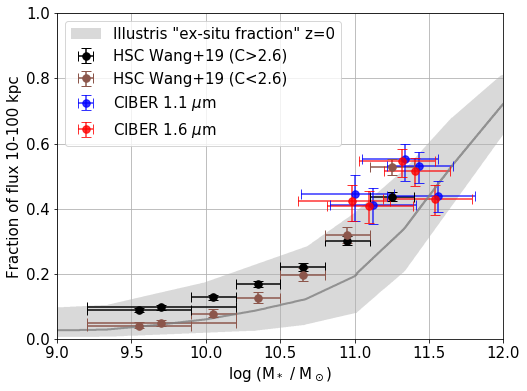

In [38]:
from run_fit import *

r_arr = np.logspace(-1,3,100)
xe2_W19 = gal_profile_model().Wang19_profile(0,3)['params']['sersic2'][2]
sp = np.where((r_arr > 10) & (r_arr<100))[0]

fig, ax = plt.subplots(1,1,figsize=(8,6))

data = np.loadtxt('Illustris_frac/Illustris_fexsitu_med.txt', delimiter=',')
plt.plot(np.log10(data[:,0]),data[:,1],c='grey',lw=2,alpha=0.8)
data_h = np.loadtxt('Illustris_frac/Illustris_fexsitu_high.txt', delimiter=',')
data_l = np.loadtxt('Illustris_frac/Illustris_fexsitu_low.txt', delimiter=',')
plt.fill_between(np.log10(data[:,0]),
                 np.interp(np.log10(data[:,0]),np.log10(data_l[:,0]),data_l[:,1]),
                 np.interp(np.log10(data[:,0]),np.log10(data_h[:,0]),data_h[:,1]),
                         facecolor='k', alpha=0.15, label='Illustris \"ex-situ fraction\" z=0')

# Wang+19 table 1
for i,(R200,Mstr_low, Mstr_high) in enumerate(zip([459.08,288.16,214.80,173.18,142.85,114.64,120.76],
                                                  [11.1,10.8,10.5,10.2,9.9,9.2,9.2],
                                                  [11.4,11.1,10.8,10.5,10.2,9.9,10.2])):
    Mstr = (Mstr_low + Mstr_high)/2
    galprofdat_HSC = gal_profile_model().Wang19_profile(r_arr, im, R200=R200)
    galprofdat_HSC3 = gal_profile_model().Wang19_profile(r_arr, im, R200=R200, extendedness=True)
    p_HSC = galprofdat_HSC['I_arr']
    p_HSC3 = galprofdat_HSC3['I_arr']

    galprofdat_HSC = gal_profile_model().Wang19_profile(r_arr, im, R200=R200, xe2= 0.0165 + 0.0008)
    galprofdat_HSC3 = gal_profile_model().Wang19_profile(r_arr, im, R200=R200, extendedness=True,
                                                        xe3=0.0001 + 0.0019, xe2=0.0231+0.0012)
    p_high_HSC = galprofdat_HSC['I_arr']
    p_high_HSC3 = galprofdat_HSC3['I_arr']

    galprofdat_HSC = gal_profile_model().Wang19_profile(r_arr, im, R200=R200, xe2= 0.0165 - 0.0008)
    galprofdat_HSC3 = gal_profile_model().Wang19_profile(r_arr, im, R200=R200, extendedness=True,
                                                        xe3=0,xe2=0.0231-0.0012)
    p_low_HSC  = galprofdat_HSC['I_arr']
    p_low_HSC3 = galprofdat_HSC3['I_arr']

    fHSC = np.sum(p_HSC[sp]*r_arr[sp]**2)/np.sum(p_HSC*r_arr**2)
    f_low_HSC = np.sum(p_low_HSC[sp]*r_arr[sp]**2)/np.sum(p_low_HSC*r_arr**2)
    f_high_HSC = np.sum(p_high_HSC[sp]*r_arr[sp]**2)/np.sum(p_high_HSC*r_arr**2)
    
    
    fHSC3 = np.sum(p_HSC3[sp]*r_arr[sp]**2)/np.sum(p_HSC3*r_arr**2)
    f_low_HSC3 = np.sum(p_low_HSC3[sp]*r_arr[sp]**2)/np.sum(p_low_HSC3*r_arr**2)
    f_high_HSC3 = np.sum(p_high_HSC3[sp]*r_arr[sp]**2)/np.sum(p_high_HSC3*r_arr**2)
    
    if i == 0:
        ax.errorbar([Mstr], [fHSC], xerr=[[Mstr-Mstr_low],[Mstr_high-Mstr]],
                       yerr=[[fHSC - f_high_HSC],[f_low_HSC - fHSC]],
                        fmt='.', capsize=5, markersize=15, c='k', label = 'HSC Wang+19 (C>2.6)')
        ax.errorbar([Mstr], [fHSC3], xerr=[[Mstr-Mstr_low],[Mstr_high-Mstr]],
                       yerr=[[fHSC3 - f_high_HSC3],[f_low_HSC3 - fHSC3]],
                        fmt='.', capsize=5, markersize=15, c='C5', label = 'HSC Wang+19 (C<2.6)')
    else:
        ax.errorbar([Mstr], [fHSC], xerr=[[Mstr-Mstr_low],[Mstr_high-Mstr]],
                       yerr=[[fHSC - f_high_HSC],[f_low_HSC - fHSC]],
                        fmt='.', capsize=5, markersize=15, c='k')
        ax.errorbar([Mstr], [fHSC3], xerr=[[Mstr-Mstr_low],[Mstr_high-Mstr]],
                       yerr=[[fHSC3 - f_high_HSC3],[f_low_HSC3 - fHSC3]],
                        fmt='.', capsize=5, markersize=15, c='C5')

for i,c in enumerate(['#ff0000','#ff5f00','#ffaf87','#0000ff','#0087ff']):
    im,m_min, m_max = srcinfo[i]['im'],srcinfo[i]['m_min'],srcinfo[i]['m_max']
    M_min, M_max = srcinfo[i]['M_min'],srcinfo[i]['M_max']    
    
    Mstr = np.median(srcinfo[i]['logMstr'])
    Mstr_low = np.percentile(srcinfo[i]['logMstr'], 16)
    Mstr_high = np.percentile(srcinfo[i]['logMstr'], 84)
    xlabel = '<z> = %.2f, %d < m < %d \n %d < M < %d'\
                      %(np.median(srcinfo[i]['z']),m_min,m_max, M_min, M_max)

    for inst in [1,2]:
        Re2 = srcinfo[i]['Re2_'+str(inst)] 
        Re2_low =srcinfo[i]['Re2_low_'+str(inst)]
        Re2_high = srcinfo[i]['Re2_high_'+str(inst)]

        galprofdat = gal_profile_model().Wang19_profile(r_arr, im, Re2=Re2)
        p = galprofdat['I_arr']

        galprofdat = gal_profile_model().Wang19_profile(r_arr, im, Re2=Re2_high)
        p_high = galprofdat['I_arr']

        galprofdat = gal_profile_model().Wang19_profile(r_arr, im, Re2=Re2_low)
        p_low = galprofdat['I_arr']

        if inst == 1:
            f1 = np.sum(p[sp]*r_arr[sp]**2)/np.sum(p*r_arr**2)
            f1_low = np.sum(p_low[sp]*r_arr[sp]**2)/np.sum(p_low*r_arr**2)
            f1_high = np.sum(p_high[sp]*r_arr[sp]**2)/np.sum(p_high*r_arr**2)
            ax.errorbar([Mstr*1.001], [f1], xerr=[[Mstr-Mstr_low],[Mstr_high-Mstr]],
                           yerr=[[f1 - f1_high],[f1_low - f1]], alpha=0.8,
                            fmt='.',capsize=5, markersize=15, c='b', label = r'CIBER 1.1 $\mu$m')
        else:
            f2 = np.sum(p[sp]*r_arr[sp]**2)/np.sum(p*r_arr**2)
            f2_low = np.sum(p_low[sp]*r_arr[sp]**2)/np.sum(p_low*r_arr**2)
            f2_high = np.sum(p_high[sp]*r_arr[sp]**2)/np.sum(p_high*r_arr**2)
            ax.errorbar([Mstr*0.999], [f2], xerr=[[Mstr-Mstr_low],[Mstr_high-Mstr]],
                           yerr=[[f2 - f2_high],[f2_low - f2]], alpha=0.8,
                            fmt='.',capsize=5, markersize=15, c='r', label = r'CIBER 1.6 $\mu$m')
            
    if i==0:
        ax.legend(fontsize=15)
ax.set_ylim([0,1])
ax.set_xlim([9,12])
ax.grid()
ax.set_xlabel('log (M$_*$ / M$_\odot$)', fontsize=15)
ax.set_ylabel("Fraction of flux 10-100 kpc", fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
plt.savefig('plots/paperfig/frac_exsitu.png',
            dpi = 200, bbox_inches='tight')

/Users/ytcheng/ciber/python_ciber/stack_modelfit/utils.py:187: RuntimeWarning: overflow encountered in power
  I_arr = (10**Ie) * np.exp(-bn*((x_arr/xe)**(1/n)-1))


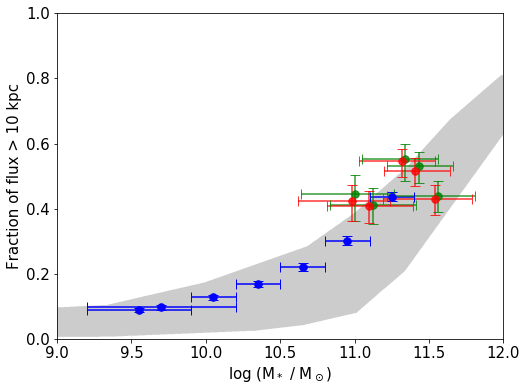

In [37]:
from run_fit import *

r_arr = np.logspace(-1,3,100)
xe2_W19 = gal_profile_model().Wang19_profile(0,3)['params']['sersic2'][2]
sp = np.where((r_arr > 10) & (r_arr<100))[0]

fig, ax = plt.subplots(1,1,figsize=(8,6))

data = np.loadtxt('Illustris_frac/Illustris_fexsitu_med.txt', delimiter=',')
# plt.plot(np.log10(data[:,0]),data[:,1],c='grey',lw=2,alpha=0.8)
data_h = np.loadtxt('Illustris_frac/Illustris_fexsitu_high.txt', delimiter=',')
data_l = np.loadtxt('Illustris_frac/Illustris_fexsitu_low.txt', delimiter=',')
plt.fill_between(np.log10(data[:,0]),
                 np.interp(np.log10(data[:,0]),np.log10(data_l[:,0]),data_l[:,1]),
                 np.interp(np.log10(data[:,0]),np.log10(data_h[:,0]),data_h[:,1]),
                         facecolor='k', alpha=0.2, label='Illustris')

# Wang+19 table 1
for i,(R200,Mstr_low, Mstr_high) in enumerate(zip([459.08,288.16,214.80,173.18,142.85,114.64,120.76],
                                                  [11.1,10.8,10.5,10.2,9.9,9.2,9.2],
                                                  [11.4,11.1,10.8,10.5,10.2,9.9,10.2])):
    Mstr = (Mstr_low + Mstr_high)/2
    galprofdat_HSC = gal_profile_model().Wang19_profile(r_arr, im, R200=R200)
    galprofdat_HSC3 = gal_profile_model().Wang19_profile(r_arr, im, R200=R200, extendedness=True)
    p_HSC = galprofdat_HSC['I_arr']
    p_HSC3 = galprofdat_HSC3['I_arr']

    galprofdat_HSC = gal_profile_model().Wang19_profile(r_arr, im, R200=R200, xe2= 0.0165 + 0.0008)
    galprofdat_HSC3 = gal_profile_model().Wang19_profile(r_arr, im, R200=R200, extendedness=True,
                                                        xe3=0.0001 + 0.0019, xe2=0.0231+0.0012)
    p_high_HSC = galprofdat_HSC['I_arr']
    p_high_HSC3 = galprofdat_HSC3['I_arr']

    galprofdat_HSC = gal_profile_model().Wang19_profile(r_arr, im, R200=R200, xe2= 0.0165 - 0.0008)
    galprofdat_HSC3 = gal_profile_model().Wang19_profile(r_arr, im, R200=R200, extendedness=True,
                                                        xe3=0,xe2=0.0231-0.0012)
    p_low_HSC  = galprofdat_HSC['I_arr']
    p_low_HSC3 = galprofdat_HSC3['I_arr']

    fHSC = np.sum(p_HSC[sp]*r_arr[sp]**2)/np.sum(p_HSC*r_arr**2)
    f_low_HSC = np.sum(p_low_HSC[sp]*r_arr[sp]**2)/np.sum(p_low_HSC*r_arr**2)
    f_high_HSC = np.sum(p_high_HSC[sp]*r_arr[sp]**2)/np.sum(p_high_HSC*r_arr**2)
    
    
    fHSC3 = np.sum(p_HSC3[sp]*r_arr[sp]**2)/np.sum(p_HSC3*r_arr**2)
    f_low_HSC3 = np.sum(p_low_HSC3[sp]*r_arr[sp]**2)/np.sum(p_low_HSC3*r_arr**2)
    f_high_HSC3 = np.sum(p_high_HSC3[sp]*r_arr[sp]**2)/np.sum(p_high_HSC3*r_arr**2)
    
    if i == 0:
        ax.errorbar([Mstr], [fHSC], xerr=[[Mstr-Mstr_low],[Mstr_high-Mstr]],
                       yerr=[[fHSC - f_high_HSC],[f_low_HSC - fHSC]],
                        fmt='.', capsize=5, markersize=15, c='b', label = 'HSC (Wang+19)')
#         ax.errorbar([Mstr], [fHSC3], xerr=[[Mstr-Mstr_low],[Mstr_high-Mstr]],
#                        yerr=[[fHSC3 - f_high_HSC3],[f_low_HSC3 - fHSC3]],
#                         fmt='.', capsize=5, markersize=15, c='C5', label = 'HSC Wang+19 (C<2.6)')
    else:
        ax.errorbar([Mstr], [fHSC], xerr=[[Mstr-Mstr_low],[Mstr_high-Mstr]],
                       yerr=[[fHSC - f_high_HSC],[f_low_HSC - fHSC]],
                        fmt='.', capsize=5, markersize=15, c='b')
#         ax.errorbar([Mstr], [fHSC3], xerr=[[Mstr-Mstr_low],[Mstr_high-Mstr]],
#                        yerr=[[fHSC3 - f_high_HSC3],[f_low_HSC3 - fHSC3]],
#                         fmt='.', capsize=5, markersize=15, c='C5')

for i,c in enumerate(['#ff0000','#ff5f00','#ffaf87','#0000ff','#0087ff']):
    im,m_min, m_max = srcinfo[i]['im'],srcinfo[i]['m_min'],srcinfo[i]['m_max']
    M_min, M_max = srcinfo[i]['M_min'],srcinfo[i]['M_max']    
    
    Mstr = np.median(srcinfo[i]['logMstr'])
    Mstr_low = np.percentile(srcinfo[i]['logMstr'], 16)
    Mstr_high = np.percentile(srcinfo[i]['logMstr'], 84)
    xlabel = '<z> = %.2f, %d < m < %d \n %d < M < %d'\
                      %(np.median(srcinfo[i]['z']),m_min,m_max, M_min, M_max)

    for inst in [1,2]:
        Re2 = srcinfo[i]['Re2_'+str(inst)] 
        Re2_low =srcinfo[i]['Re2_low_'+str(inst)]
        Re2_high = srcinfo[i]['Re2_high_'+str(inst)]

        galprofdat = gal_profile_model().Wang19_profile(r_arr, im, Re2=Re2)
        p = galprofdat['I_arr']

        galprofdat = gal_profile_model().Wang19_profile(r_arr, im, Re2=Re2_high)
        p_high = galprofdat['I_arr']

        galprofdat = gal_profile_model().Wang19_profile(r_arr, im, Re2=Re2_low)
        p_low = galprofdat['I_arr']

        if inst == 1:
            f1 = np.sum(p[sp]*r_arr[sp]**2)/np.sum(p*r_arr**2)
            f1_low = np.sum(p_low[sp]*r_arr[sp]**2)/np.sum(p_low*r_arr**2)
            f1_high = np.sum(p_high[sp]*r_arr[sp]**2)/np.sum(p_high*r_arr**2)
            ax.errorbar([Mstr*1.001], [f1], xerr=[[Mstr-Mstr_low],[Mstr_high-Mstr]],
                           yerr=[[f1 - f1_high],[f1_low - f1]], alpha=0.8,
                            fmt='.',capsize=5, markersize=15, c='g', label = r'CIBER 1.1 $\mu$m')
        else:
            f2 = np.sum(p[sp]*r_arr[sp]**2)/np.sum(p*r_arr**2)
            f2_low = np.sum(p_low[sp]*r_arr[sp]**2)/np.sum(p_low*r_arr**2)
            f2_high = np.sum(p_high[sp]*r_arr[sp]**2)/np.sum(p_high*r_arr**2)
            ax.errorbar([Mstr*0.999], [f2], xerr=[[Mstr-Mstr_low],[Mstr_high-Mstr]],
                           yerr=[[f2 - f2_high],[f2_low - f2]], alpha=0.8,
                            fmt='.',capsize=5, markersize=15, c='r', label = r'CIBER 1.6 $\mu$m')
            
#     if i==0:
#         ax.legend(fontsize=15)
ax.set_ylim([0,1])
ax.set_xlim([9,12])
# ax.grid()
ax.set_xlabel('log (M$_*$ / M$_\odot$)', fontsize=15)
ax.set_ylabel("Fraction of flux > 10 kpc", fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
plt.savefig('plots/slides/frac_exsitu.png',
            dpi = 200, bbox_inches='tight')

/Users/ytcheng/ciber/python_ciber/stack_modelfit/utils.py:187: RuntimeWarning: overflow encountered in power
  I_arr = (10**Ie) * np.exp(-bn*((x_arr/xe)**(1/n)-1))


HSC C>2.6, 11.1 < M* < 11.4, rh = 7.92 kpc, (7.92 arcsec)
HSC C<2.6, 11.1 < M* < 11.4, rh = 10.48 kpc, (10.48 arcsec)
HSC C>2.6, 10.8 < M* < 11.1, rh = 4.98 kpc, (4.98 arcsec)
HSC C<2.6, 10.8 < M* < 11.1, rh = 6.58 kpc, (6.58 arcsec)
HSC C>2.6, 10.5 < M* < 10.8, rh = 3.76 kpc, (3.76 arcsec)
HSC C<2.6, 10.5 < M* < 10.8, rh = 4.98 kpc, (4.98 arcsec)
HSC C>2.6, 10.2 < M* < 10.5, rh = 3.13 kpc, (3.13 arcsec)
HSC C<2.6, 10.2 < M* < 10.5, rh = 3.76 kpc, (3.76 arcsec)
HSC C>2.6, 9.9 < M* < 10.2, rh = 2.60 kpc, (2.60 arcsec)
HSC C<2.6, 9.9 < M* < 10.2, rh = 3.13 kpc, (3.13 arcsec)
HSC C>2.6, 9.2 < M* < 9.9, rh = 1.96 kpc, (1.96 arcsec)
HSC C<2.6, 9.2 < M* < 9.9, rh = 2.60 kpc, (2.60 arcsec)
inst1, bin #0, 11.2 < M* < 11.8, rh = 5.45 kpc (1.50 arcsec)
inst2, bin #0, 11.2 < M* < 11.8, rh = 5.45 kpc (1.50 arcsec)
inst1, bin #1, 11.2 < M* < 11.7, rh = 6.15 kpc (1.23 arcsec)
inst2, bin #1, 11.2 < M* < 11.7, rh = 6.15 kpc (1.23 arcsec)
inst1, bin #2, 11.0 < M* < 11.6, rh = 6.32 kpc (0.97 arcsec)
ins

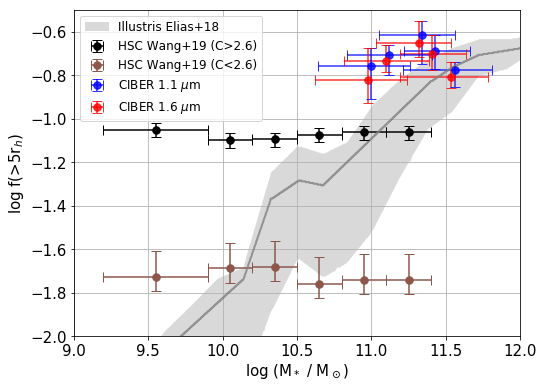

In [60]:
from run_fit import *

r_arr = np.logspace(-1,3,100)
xe2_W19 = gal_profile_model().Wang19_profile(0,3)['params']['sersic2'][2]
sp = np.where((r_arr > 10) & (r_arr<100))[0]

fig, ax = plt.subplots(1,1,figsize=(8,6))

data = np.loadtxt('Illustris_frac/Illustris_f5rh_med.txt', delimiter=',')
plt.plot(data[:,0],data[:,1],c='grey',lw=2,alpha=0.8)
data_h = np.loadtxt('Illustris_frac/Illustris_f5rh_high.txt', delimiter=',')
data_l = np.loadtxt('Illustris_frac/Illustris_f5rh_low.txt', delimiter=',')
plt.fill_between(data[:,0],
                 np.interp(data[:,0],data_l[:,0],data_l[:,1]),
                 np.interp(data[:,0],data_h[:,0],data_h[:,1]),
                         facecolor='k', alpha=0.15, label='Illustris Elias+18')

# Wang+19 table 1
for i,(R200,Mstr_low, Mstr_high,z) in enumerate(zip([459.08,288.16,214.80,173.18,142.85,114.64,120.76],
                                                  [11.1,10.8,10.5,10.2,9.9,9.2,9.2],
                                                  [11.4,11.1,10.8,10.5,10.2,9.9,10.2],
                                                 [0.05,0.07,0.08,0.11,0.14,0.18])):
    # redshifts are fit by eye from Wang+19 Fig. 1
    
    Mstr = (Mstr_low + Mstr_high)/2
    galprofdat_HSC = gal_profile_model().Wang19_profile(r_arr, im, R200=R200)
    galprofdat_HSC3 = gal_profile_model().Wang19_profile(r_arr, im, R200=R200, extendedness=True)
    p_HSC = galprofdat_HSC['I_arr']
    p_HSC3 = galprofdat_HSC3['I_arr']

    galprofdat_HSC = gal_profile_model().Wang19_profile(r_arr, im, R200=R200, xe2= 0.0165 + 0.0008)
    galprofdat_HSC3 = gal_profile_model().Wang19_profile(r_arr, im, R200=R200, extendedness=True,
                                                        xe3=0.0001 + 0.0019, xe2=0.0231+0.0012)
    p_high_HSC = galprofdat_HSC['I_arr']
    p_high_HSC3 = galprofdat_HSC3['I_arr']

    galprofdat_HSC = gal_profile_model().Wang19_profile(r_arr, im, R200=R200, xe2= 0.0165 - 0.0008)
    galprofdat_HSC3 = gal_profile_model().Wang19_profile(r_arr, im, R200=R200, extendedness=True,
                                                        xe3=0,xe2=0.0231-0.0012)
    p_low_HSC  = galprofdat_HSC['I_arr']
    p_low_HSC3 = galprofdat_HSC3['I_arr']
    
    idx_half = np.argmin(np.abs(np.cumsum(p_HSC*r_arr**2)/np.sum(p_HSC*r_arr**2) - 0.5))
    rh_arcsec = r_arr[idx_half]
    rh_kpc = rh_arcsec / cosmo.arcsec_per_kpc_proper(z).value
    sp = np.where((r_arr > 5*rh_arcsec))[0]
    print('HSC C>2.6, %.1f < M* < %.1f, rh = %.2f kpc, (%.2f arcsec)'\
          %(Mstr_low, Mstr_high, r_arr[idx_half], rh_arcsec))
    
    fHSC = np.log10(np.sum(p_HSC[sp]*r_arr[sp]**2)/np.sum(p_HSC*r_arr**2))
    f_low_HSC = np.log10(np.sum(p_low_HSC[sp]*r_arr[sp]**2)/np.sum(p_low_HSC*r_arr**2))
    f_high_HSC = np.log10(np.sum(p_high_HSC[sp]*r_arr[sp]**2)/np.sum(p_high_HSC*r_arr**2))
    
    idx_half = np.argmin(np.abs(np.cumsum(p_HSC3*r_arr**2)/np.sum(p_HSC3*r_arr**2) - 0.5))
    rh_arcsec = r_arr[idx_half]
    rh_kpc = rh_arcsec / cosmo.arcsec_per_kpc_proper(z).value
    sp = np.where((r_arr > 5*rh_arcsec))[0]
    print('HSC C<2.6, %.1f < M* < %.1f, rh = %.2f kpc, (%.2f arcsec)'\
          %(Mstr_low, Mstr_high, r_arr[idx_half], rh_arcsec))

    fHSC3 = np.log10(np.sum(p_HSC3[sp]*r_arr[sp]**2)/np.sum(p_HSC3*r_arr**2))
    f_low_HSC3 = np.log10(np.sum(p_low_HSC3[sp]*r_arr[sp]**2)/np.sum(p_low_HSC3*r_arr**2))
    f_high_HSC3 = np.log10(np.sum(p_high_HSC3[sp]*r_arr[sp]**2)/np.sum(p_high_HSC3*r_arr**2))
    
    if i == 0:
        ax.errorbar([Mstr], [fHSC], xerr=[[Mstr-Mstr_low],[Mstr_high-Mstr]],
                       yerr=[[fHSC - f_high_HSC],[f_low_HSC - fHSC]],
                        fmt='.', capsize=5, markersize=15, c='k', label = 'HSC Wang+19 (C>2.6)')
        ax.errorbar([Mstr], [fHSC3], xerr=[[Mstr-Mstr_low],[Mstr_high-Mstr]],
                       yerr=[[fHSC3 - f_high_HSC3],[f_low_HSC3 - fHSC3]],
                        fmt='.', capsize=5, markersize=15, c='C5', label = 'HSC Wang+19 (C<2.6)')
    else:
        ax.errorbar([Mstr], [fHSC], xerr=[[Mstr-Mstr_low],[Mstr_high-Mstr]],
                       yerr=[[fHSC - f_high_HSC],[f_low_HSC - fHSC]],
                        fmt='.', capsize=5, markersize=15, c='k')
        ax.errorbar([Mstr], [fHSC3], xerr=[[Mstr-Mstr_low],[Mstr_high-Mstr]],
                       yerr=[[fHSC3 - f_high_HSC3],[f_low_HSC3 - fHSC3]],
                        fmt='.', capsize=5, markersize=15, c='C5')

for i,c in enumerate(['#ff0000','#ff5f00','#ffaf87','#0000ff','#0087ff']):
    im,m_min, m_max = srcinfo[i]['im'],srcinfo[i]['m_min'],srcinfo[i]['m_max']
    M_min, M_max = srcinfo[i]['M_min'],srcinfo[i]['M_max']    
    
    Mstr = np.median(srcinfo[i]['logMstr'])
    Mstr_low = np.percentile(srcinfo[i]['logMstr'], 16)
    Mstr_high = np.percentile(srcinfo[i]['logMstr'], 84)
    xlabel = '<z> = %.2f, %d < m < %d \n %d < M < %d'\
                      %(np.median(srcinfo[i]['z']),m_min,m_max, M_min, M_max)
    z = np.median(srcinfo[i]['z'])
    for inst in [1,2]:
        Re2 = srcinfo[i]['Re2_'+str(inst) + '_arcsec']
        Re2_low =srcinfo[i]['Re2_low_'+str(inst) + '_arcsec']
        Re2_high = srcinfo[i]['Re2_high_'+str(inst) + '_arcsec']

        galprofdat = gal_profile_model().Wang19_profile(r_arr, im, Re2=Re2)
        p = galprofdat['I_arr']

        galprofdat = gal_profile_model().Wang19_profile(r_arr, im, Re2=Re2_high)
        p_high = galprofdat['I_arr']

        galprofdat = gal_profile_model().Wang19_profile(r_arr, im, Re2=Re2_low)
        p_low = galprofdat['I_arr']

        idx_half = np.argmin(np.abs(np.cumsum(p*r_arr**2)/np.sum(p*r_arr**2) - 0.5))
        rh_arcsec = np.median(srcinfo[i]['dfpetro']['petroR50_r'])#r_arr[idx_half]
        rh_kpc = rh_arcsec / cosmo.arcsec_per_kpc_proper(z).value
        sp = np.where((r_arr > 5*rh_arcsec))[0]
        print('inst%d, bin #%d, %.1f < M* < %.1f, rh = %.2f kpc (%.2f arcsec)'\
              %(inst,i, Mstr_low, Mstr_high, rh_kpc, rh_arcsec))

        if inst == 1:
            f1 = np.log10(np.sum(p[sp]*r_arr[sp]**2)/np.sum(p*r_arr**2))
            f1_low = np.log10(np.sum(p_low[sp]*r_arr[sp]**2)/np.sum(p_low*r_arr**2))
            f1_high = np.log10(np.sum(p_high[sp]*r_arr[sp]**2)/np.sum(p_high*r_arr**2))
            ax.errorbar([Mstr*1.001], [f1], xerr=[[Mstr-Mstr_low],[Mstr_high-Mstr]],
                           yerr=[[f1 - f1_high],[f1_low - f1]], alpha=0.8,
                            fmt='.',capsize=5, markersize=15, c='b', label = r'CIBER 1.1 $\mu$m')
        else:
            f2 = np.log10(np.sum(p[sp]*r_arr[sp]**2)/np.sum(p*r_arr**2))
            f2_low = np.log10(np.sum(p_low[sp]*r_arr[sp]**2)/np.sum(p_low*r_arr**2))
            f2_high = np.log10(np.sum(p_high[sp]*r_arr[sp]**2)/np.sum(p_high*r_arr**2))
            ax.errorbar([Mstr*0.999], [f2], xerr=[[Mstr-Mstr_low],[Mstr_high-Mstr]],
                           yerr=[[f2 - f1_high],[f2_low - f2]], alpha=0.8,
                            fmt='.',capsize=5, markersize=15, c='r', label = r'CIBER 1.6 $\mu$m')
            
    if i==0:
        ax.legend(fontsize=12,loc=2)
ax.set_ylim([-2,-0.5])
ax.set_xlim([9,12])
ax.grid()
ax.set_xlabel('log (M$_*$ / M$_\odot$)', fontsize=15)
ax.set_ylabel(r'log f(>5r$_h$)', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
# plt.savefig('plots/paperfig/frac_5rh.png',
#             dpi = 200, bbox_inches='tight')

plt.savefig('/Users/ytcheng/Desktop/frac_5rh_petro50.png',
            dpi = 200, bbox_inches='tight')

https://iopscience.iop.org/article/10.1086/519787/pdf

https://arxiv.org/pdf/0805.2965.pdf

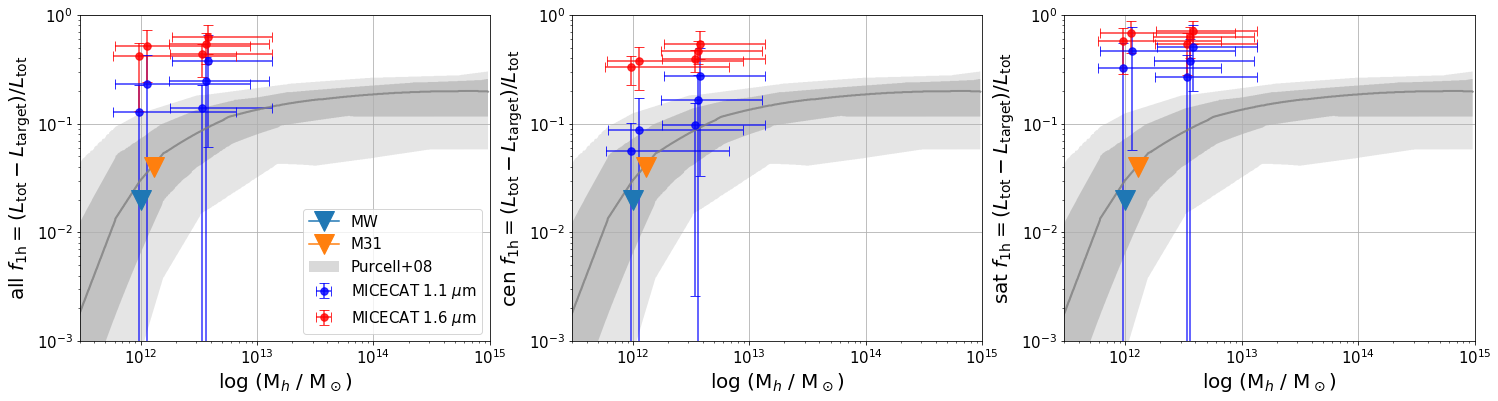

In [61]:
from run_fit import *

r_arr = np.logspace(-1,3,100)
xe2_W19 = gal_profile_model().Wang19_profile(0,3)['params']['sersic2'][2]
sp = np.where((r_arr > 10) & (r_arr<100))[0]

fig, ax = plt.subplots(1,3,figsize=(25,6))

for i in range(3):
    data = np.loadtxt('Illustris_frac/Purcell08_med.txt', delimiter=',')
    ax[i].loglog(10**data[:,0],10**data[:,1],c='grey',lw=2,alpha=0.8)
    data_h = np.loadtxt('Illustris_frac/Purcell08_68high.txt', delimiter=',')
    data_l = np.loadtxt('Illustris_frac/Purcell08_68low.txt', delimiter=',')
    ax[i].fill_between(10**data[:,0],
                     10**np.interp(data[:,0],data_l[:,0],data_l[:,1]),
                     10**np.interp(data[:,0],data_h[:,0],data_h[:,1]),
                             facecolor='k', alpha=0.15, label='Purcell+08')
    data_h = np.loadtxt('Illustris_frac/Purcell08_95high.txt', delimiter=',')
    data_l = np.loadtxt('Illustris_frac/Purcell08_95low.txt', delimiter=',')
    ax[i].fill_between(10**data[:,0],
                     10**np.interp(data[:,0],data_l[:,0],data_l[:,1]),
                     10**np.interp(data[:,0],data_h[:,0],data_h[:,1]),
                             facecolor='k', alpha=0.1)

    ax[i].plot([1e12], [0.02], marker='v', markersize=20, label='MW')
    ax[i].plot([1.3e12], [0.04], marker='v', markersize=20, label='M31')

for i,c in enumerate(['#ff0000','#ff5f00','#ffaf87','#0000ff','#0087ff']):
    im,m_min, m_max = srcinfo[i]['im'],srcinfo[i]['m_min'],srcinfo[i]['m_max']
    M_min, M_max = srcinfo[i]['M_min'],srcinfo[i]['M_max']    
    
    Mh = 10**np.median(srcinfo[i]['logMh'])
    Mh_low = 10**np.percentile(srcinfo[i]['logMh'], 16)
    Mh_high = 10**np.percentile(srcinfo[i]['logMh'], 84)
    
    for inst in [1,2]:
        f1hc_arr = np.array([])
        f1hs_arr = np.array([])
        for icat in range(10):
            fname = 'micecat_data/f1h_test_icat%d.pkl'%(icat)
            with open(fname, "rb") as f:
                f1h_dict = pickle.load(f)
            if inst == 1:
                f1hc_arr = np.concatenate((f1hc_arr,f1h_dict[i]['f1h_I_masked_c']))
                f1hs_arr = np.concatenate((f1hs_arr,f1h_dict[i]['f1h_I_masked_s']))
            else:
                f1hc_arr = np.concatenate((f1hc_arr,f1h_dict[i]['f1h_H_masked_c']))
                f1hs_arr = np.concatenate((f1hs_arr,f1h_dict[i]['f1h_H_masked_s']))
            
        f = np.percentile(np.concatenate((f1hc_arr,f1hs_arr)), 50)
        f_low = np.percentile(np.concatenate((f1hc_arr,f1hs_arr)), 16)
        f_high = np.percentile(np.concatenate((f1hc_arr,f1hs_arr)), 84)
        if inst == 1:
            ax[0].errorbar([Mh*1.001], [f], xerr=[[Mh-Mh_low],[Mh_high-Mh]],
                           yerr=[[f_high - f],[f - f_low]], alpha=0.8,
                            fmt='.',capsize=5, markersize=15, c='b', label = r'MICECAT 1.1 $\mu$m')
        else:
            ax[0].errorbar([Mh*0.999], [f], xerr=[[Mh-Mh_low],[Mh_high-Mh]],
                           yerr=[[f_high - f],[f - f_low]], alpha=0.8,
                            fmt='.',capsize=5, markersize=15, c='r', label = r'MICECAT 1.6 $\mu$m')
            
        f = np.percentile(f1hc_arr, 50)
        f_low = np.percentile(f1hc_arr, 16)
        f_high = np.percentile(f1hc_arr, 84)
        if inst == 1:
            ax[1].errorbar([Mh*1.001], [f], xerr=[[Mh-Mh_low],[Mh_high-Mh]],
                           yerr=[[f_high - f],[f - f_low]], alpha=0.8,
                            fmt='.',capsize=5, markersize=15, c='b', label = r'MICECAT 1.1 $\mu$m')
        else:
            ax[1].errorbar([Mh*0.999], [f], xerr=[[Mh-Mh_low],[Mh_high-Mh]],
                           yerr=[[f_high - f],[f - f_low]], alpha=0.8,
                            fmt='.',capsize=5, markersize=15, c='r', label = r'MICECAT 1.6 $\mu$m')

        f = np.percentile(f1hs_arr, 50)
        f_low = np.percentile(f1hs_arr, 16)
        f_high = np.percentile(f1hs_arr, 84)
        if inst == 1:
            ax[2].errorbar([Mh*1.001], [f], xerr=[[Mh-Mh_low],[Mh_high-Mh]],
                           yerr=[[f_high - f],[f - f_low]], alpha=0.8,
                            fmt='.',capsize=5, markersize=15, c='b', label = r'MICECAT 1.1 $\mu$m')
        else:
            ax[2].errorbar([Mh*0.999], [f], xerr=[[Mh-Mh_low],[Mh_high-Mh]],
                           yerr=[[f_high - f],[f - f_low]], alpha=0.8,
                            fmt='.',capsize=5, markersize=15, c='r', label = r'MICECAT 1.6 $\mu$m')

    if i==0:
        ax[0].legend(fontsize=15)   
ax[0].set_ylim([1e-3,1])
ax[0].set_xlim([3e11,1e15])
ax[0].grid()
ax[0].set_xlabel('log (M$_h$ / M$_\odot$)', fontsize=20)
ax[0].set_ylabel(r"all $f_{\rm 1h} = (L_{\rm tot} - L_{\rm target})/L_{\rm tot}$", fontsize=20)
ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)

ax[1].set_ylim([1e-3,1])
ax[1].set_xlim([3e11,1e15])
ax[1].grid()
ax[1].set_xlabel('log (M$_h$ / M$_\odot$)', fontsize=20)
ax[1].set_ylabel(r"cen $f_{\rm 1h} = (L_{\rm tot} - L_{\rm target})/L_{\rm tot}$", fontsize=20)
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)

ax[2].set_ylim([1e-3,1])
ax[2].set_xlim([3e11,1e15])
ax[2].grid()
ax[2].set_xlabel('log (M$_h$ / M$_\odot$)', fontsize=20)
ax[2].set_ylabel(r"sat $f_{\rm 1h} = (L_{\rm tot} - L_{\rm target})/L_{\rm tot}$", fontsize=20)
ax[2].tick_params(axis='x', labelsize=15)
ax[2].tick_params(axis='y', labelsize=15)

plt.savefig('/Users/ytcheng/Desktop/fIHL_micecat.png',
            dpi = 200, bbox_inches='tight')

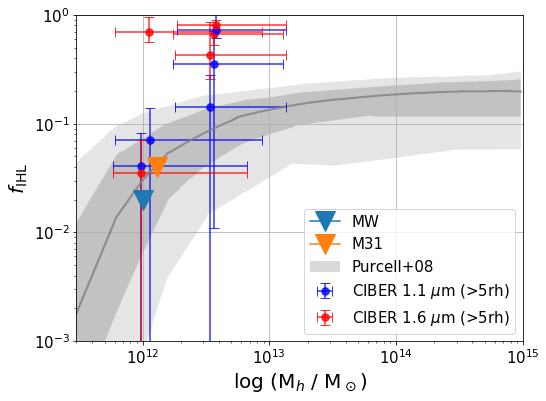

In [32]:
from run_fit import *

r_arr = np.logspace(-1,3,100)
xe2_W19 = gal_profile_model().Wang19_profile(0,3)['params']['sersic2'][2]
sp = np.where((r_arr > 10) & (r_arr<100))[0]

fig, ax = plt.subplots(1,1,figsize=(8,6))

data = np.loadtxt('Illustris_frac/Purcell08_med.txt', delimiter=',')
plt.loglog(10**data[:,0],10**data[:,1],c='grey',lw=2,alpha=0.8)
data_h = np.loadtxt('Illustris_frac/Purcell08_68high.txt', delimiter=',')
data_l = np.loadtxt('Illustris_frac/Purcell08_68low.txt', delimiter=',')
plt.fill_between(10**data[:,0],
                 10**np.interp(data[:,0],data_l[:,0],data_l[:,1]),
                 10**np.interp(data[:,0],data_h[:,0],data_h[:,1]),
                         facecolor='k', alpha=0.15, label='Purcell+08')
data_h = np.loadtxt('Illustris_frac/Purcell08_95high.txt', delimiter=',')
data_l = np.loadtxt('Illustris_frac/Purcell08_95low.txt', delimiter=',')
plt.fill_between(10**data[:,0],
                 10**np.interp(data[:,0],data_l[:,0],data_l[:,1]),
                 10**np.interp(data[:,0],data_h[:,0],data_h[:,1]),
                         facecolor='k', alpha=0.1)

plt.plot([1e12], [0.02], marker='v', markersize=20, label='MW')
plt.plot([1.3e12], [0.04], marker='v', markersize=20, label='M31')

for i,c in enumerate(['#ff0000','#ff5f00','#ffaf87','#0000ff','#0087ff']):
    if i!=0:
        continue
    im,m_min, m_max = srcinfo[i]['im'],srcinfo[i]['m_min'],srcinfo[i]['m_max']
    M_min, M_max = srcinfo[i]['M_min'],srcinfo[i]['M_max']    
    
    Mh = 10**np.median(srcinfo[i]['logMh'])
    Mh_low = 10**np.percentile(srcinfo[i]['logMh'], 16)
    Mh_high = 10**np.percentile(srcinfo[i]['logMh'], 84)

    for inst in [1,2]:
        param_fit = fit_stacking_mcmc(inst, ifield, im, m_min=m_min, m_max=m_max,
                                             Mabs_min=M_min, Mabs_max=M_max)
        Re2 = srcinfo[i]['Re2_'+str(inst)] 
        Re2_low =srcinfo[i]['Re2_low_'+str(inst)]
        Re2_high = srcinfo[i]['Re2_high_'+str(inst)]
        A1h = srcinfo[i]['A1h_'+str(inst)] 
        A1h_low =srcinfo[i]['A1h_low_'+str(inst)]
        A1h_high = srcinfo[i]['A1h_high_'+str(inst)]
        A2h = srcinfo[i]['A1h_'+str(inst)] 
        A2h_low =srcinfo[i]['A1h_low_'+str(inst)]
        A2h_high = srcinfo[i]['A1h_high_'+str(inst)]

        galprofdat = gal_profile_model().Wang19_profile(r_arr, im, Re2=Re2)
        p = galprofdat['I_arr']
        modelprof = param_fit.get_profexcess_model(Re2=Re2,
                                                   A1h=A1h,
                                                   A2h=A2h) 
        norm = modelprof['normg']/np.interp(param_fit.rbins[0],r_arr,p)
        p *= norm
        
        galprofdat = gal_profile_model().Wang19_profile(r_arr, im, Re2=Re2_high)
        p_high = galprofdat['I_arr']
        modelprof = param_fit.get_profexcess_model(Re2=Re2_high,
                                                   A1h=A1h_low,
                                                   A2h=A2h_low) 
        norm = modelprof['normg']/np.interp(param_fit.rbins[0],r_arr,p_high)
        p_high *= norm

        galprofdat = gal_profile_model().Wang19_profile(r_arr, im, Re2=Re2_low)
        modelprof = param_fit.get_profexcess_model(Re2=Re2_low,
                                                   A1h=A1h_high,
                                                   A2h=A2h_high)
        p_low = galprofdat['I_arr']
        norm = modelprof['normg']/np.interp(param_fit.rbins[0],r_arr,p_low)
        p_low *= norm

        T1h = 10**np.interp(np.log10(r_arr),np.log10(srcinfo[i]['MC1h_rbins'+str(inst)]),
                  np.log10(srcinfo[i]['MC1h_avg'+str(inst)]))
        p1h = T1h * srcinfo[i]['A1h_'+str(inst)]
        p1h_low = T1h * srcinfo[i]['A1h_low_'+str(inst)]
        p1h_high = T1h * srcinfo[i]['A1h_high_'+str(inst)]
        
        Ltot = np.sum(p*r_arr**2)+np.sum(p1h*r_arr**2)
        L1h =  np.sum(p1h*r_arr**2)

        Ltot_low = np.sum(p_high*r_arr**2)+np.sum(p1h_low*r_arr**2)
        L1h_low = np.sum(p1h_low*r_arr**2)

        Ltot_high = np.sum(p_low*r_arr**2)+np.sum(p1h_high*r_arr**2)
        L1h_high = np.sum(p1h_high*r_arr**2)

#         idx_half = np.argmin(np.abs(np.cumsum(p*r_arr**2)/np.sum(p*r_arr**2) - 0.5))
#         sp = np.where((r_arr > 5*r_arr[idx_half]))[0] 
        
        if inst == 1:
#             f1 = np.sum(p[sp]*r_arr[sp]**2)/np.sum(p*r_arr**2 + p1h*r_arr**2)
#             f1_low = np.sum(p_low[sp]*r_arr[sp]**2)/np.sum(p_low*r_arr**2 + p1h_high*r_arr**2)
#             f1_high = np.sum(p_high[sp]*r_arr[sp]**2)/np.sum(p_high*r_arr**2 + p1h_low*r_arr**2)
            f1 = L1h/Ltot
            f1_low = L1h_low/Ltot_low
            f1_high = L1h_high/Ltot_high
            ax.errorbar([Mh*1.001], [f1], xerr=[[Mh-Mh_low],[Mh_high-Mh]],
                           yerr=[[f1_high - f1],[f1 - f1_low]], alpha=0.8,
                            fmt='.',capsize=5, markersize=15, c='b', label = r'CIBER 1.1 $\mu$m (>5rh)')
        else:
#             f2 = np.sum(p[sp]*r_arr[sp]**2)/np.sum(p*r_arr**2)
#             f2_low = np.sum(p_low[sp]*r_arr[sp]**2)/np.sum(p_low*r_arr**2)
#             f2_high = np.sum(p_high[sp]*r_arr[sp]**2)/np.sum(p_high*r_arr**2)
            f2 = L1h/Ltot
            f2_low = L1h_low/Ltot_low
            f2_high = L1h_high/Ltot_high
            ax.errorbar([Mh*0.999], [f2], xerr=[[Mh-Mh_low],[Mh_high-Mh]],
                           yerr=[[f2_high - f2],[f2 - f2_low]], alpha=0.8,
                            fmt='.',capsize=5, markersize=15, c='r', label = r'CIBER 1.6 $\mu$m (>5rh)')
            
    if i==0:
        ax.legend(fontsize=15)
ax.set_ylim([1e-3,1])
ax.set_xlim([3e11,1e15])
ax.grid()
ax.set_xlabel('log (M$_h$ / M$_\odot$)', fontsize=20)
ax.set_ylabel(r"$f_{\rm IHL}$", fontsize=20)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
# plt.savefig('plots/paperfig/fIHL.png',
#             dpi = 200, bbox_inches='tight')

/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:81: RuntimeWarning: divide by zero encountered in log10


0 0.027663420362507754 0.12431755646760316
0 -0.0655518668204219 -0.10432834629536748
1 0.023603996131456244 -0.010378298082168762
1 -0.09690811428882815 -0.06917933231115253
2 0.25825156687938966 0.08504078269091203
2 -0.0756193139081649 -0.08330801607706789
3 0.006222977248242905 0.005117998897129177
3 -0.16529535024117975 -0.005773481197650281
4 0.014268062196797085 0.35063529927494524
4 -0.09101465306776635 -0.15634670834915942


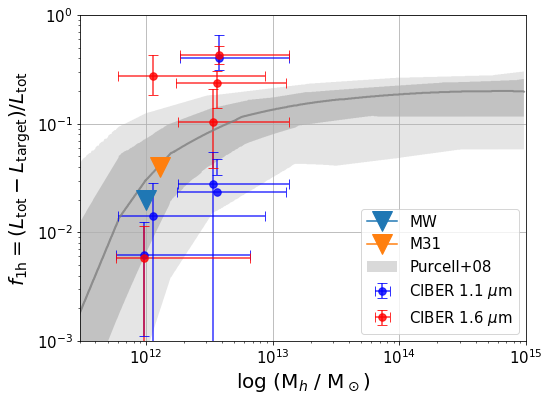

In [66]:
from run_fit import *

r_arr = np.logspace(-1,3,100)
xe2_W19 = gal_profile_model().Wang19_profile(0,3)['params']['sersic2'][2]
sp = np.where((r_arr > 10) & (r_arr<100))[0]

fig, ax = plt.subplots(1,1,figsize=(8,6))

data = np.loadtxt('Illustris_frac/Purcell08_med.txt', delimiter=',')
plt.loglog(10**data[:,0],10**data[:,1],c='grey',lw=2,alpha=0.8)
data_h = np.loadtxt('Illustris_frac/Purcell08_68high.txt', delimiter=',')
data_l = np.loadtxt('Illustris_frac/Purcell08_68low.txt', delimiter=',')
plt.fill_between(10**data[:,0],
                 10**np.interp(data[:,0],data_l[:,0],data_l[:,1]),
                 10**np.interp(data[:,0],data_h[:,0],data_h[:,1]),
                         facecolor='k', alpha=0.15, label='Purcell+08')
data_h = np.loadtxt('Illustris_frac/Purcell08_95high.txt', delimiter=',')
data_l = np.loadtxt('Illustris_frac/Purcell08_95low.txt', delimiter=',')
plt.fill_between(10**data[:,0],
                 10**np.interp(data[:,0],data_l[:,0],data_l[:,1]),
                 10**np.interp(data[:,0],data_h[:,0],data_h[:,1]),
                         facecolor='k', alpha=0.1)

plt.plot([1e12], [0.02], marker='v', markersize=20, label='MW')
plt.plot([1.3e12], [0.04], marker='v', markersize=20, label='M31')

for i,c in enumerate(['#ff0000','#ff5f00','#ffaf87','#0000ff','#0087ff']):
    im,m_min, m_max = srcinfo[i]['im'],srcinfo[i]['m_min'],srcinfo[i]['m_max']
    M_min, M_max = srcinfo[i]['M_min'],srcinfo[i]['M_max']    
    
    Mh = 10**np.median(srcinfo[i]['logMh'])
    Mh_low = 10**np.percentile(srcinfo[i]['logMh'], 16)
    Mh_high = 10**np.percentile(srcinfo[i]['logMh'], 84)

    for inst in [1,2]:
        param_fit = fit_stacking_mcmc(inst, ifield, im, m_min=m_min, m_max=m_max,
                                             Mabs_min=M_min, Mabs_max=M_max)
        Re2 = srcinfo[i]['Re2_'+str(inst)] 
        Re2_low =srcinfo[i]['Re2_low_'+str(inst)]
        Re2_high = srcinfo[i]['Re2_high_'+str(inst)]
        A1h = srcinfo[i]['A1h_'+str(inst)] 
        A1h_low =srcinfo[i]['A1h_low_'+str(inst)]
        A1h_high = srcinfo[i]['A1h_high_'+str(inst)]
        A2h = srcinfo[i]['A1h_'+str(inst)] 
        A2h_low =srcinfo[i]['A1h_low_'+str(inst)]
        A2h_high = srcinfo[i]['A1h_high_'+str(inst)]

        modelprof = param_fit.get_profexcess_model(Re2=Re2,
                                                   A1h=A1h,
                                                   A2h=A2h)
        profgal = modelprof['profgal'] - modelprof['prof1h'] - modelprof['prof2h']
        prof1h = modelprof['prof1h']
        rbins = modelprof['rbins']
        sp = np.where(profgal>0)[0]
        profgal_interp = 10**np.interp(np.log10(r_arr),np.log10(rbins[sp]), np.log10(profgal[sp]))
        prof1h_interp = 10**np.interp(np.log10(r_arr),np.log10(rbins), np.log10(prof1h))
        Ltot = np.sum(profgal_interp*r_arr**2)+np.sum(prof1h_interp*r_arr**2)
        L1h =  np.sum(prof1h_interp*r_arr**2)

        
        modelprof = param_fit.get_profexcess_model(Re2=Re2_low,
                                                   A1h=A1h_high,
                                                   A2h=A2h_high)
        profgal = modelprof['profgal'] - modelprof['prof1h'] - modelprof['prof2h']
        prof1h = modelprof['prof1h']
        rbins = modelprof['rbins']
        sp = np.where(profgal>0)[0]
        profgal_interp = 10**np.interp(np.log10(r_arr),np.log10(rbins[sp]), np.log10(profgal[sp]))
        prof1h_interp = 10**np.interp(np.log10(r_arr),np.log10(rbins), np.log10(prof1h))
        Ltot_low = np.sum(profgal_interp*r_arr**2)+np.sum(prof1h_interp*r_arr**2)
        L1h_low =  np.sum(prof1h_interp*r_arr**2)

        modelprof = param_fit.get_profexcess_model(Re2=Re2_high,
                                                   A1h=A1h_low,
                                                   A2h=A2h_low)
        profgal = modelprof['profgal'] - modelprof['prof1h'] - modelprof['prof2h']
        prof1h = modelprof['prof1h']
        rbins = modelprof['rbins']
        sp = np.where(profgal>0)[0]
        profgal_interp = 10**np.interp(np.log10(r_arr),np.log10(rbins[sp]), np.log10(profgal[sp]))
        prof1h_interp = 10**np.interp(np.log10(r_arr),np.log10(rbins), np.log10(prof1h))
        Ltot_high = np.sum(profgal_interp*r_arr**2)+np.sum(prof1h_interp*r_arr**2)
        L1h_high =  np.sum(prof1h_interp*r_arr**2)
         
        if inst == 1:
            f1 = L1h/Ltot
            f1_low = L1h_low/Ltot_low
            f1_high = L1h_high/Ltot_high
            if f1_low > f1_high:
                f1_high1, f1_low1 = f1_high, f1_low
                f1_high, f1_low = f1_low1, f1_high1
            print(i,f1-f1_low,f1_high-f1)
            ax.errorbar([Mh*1.001], [f1], xerr=[[Mh-Mh_low],[Mh_high-Mh]],
                           yerr=[[f1_high - f1],[f1 - f1_low]], alpha=0.8,
                            fmt='.',capsize=5, markersize=15, c='b', label = r'CIBER 1.1 $\mu$m')
        else:
            f2 = L1h/Ltot
            f2_low = L1h_low/Ltot_low
            f2_high = L1h_high/Ltot_high
            if f1_low > f1_high:
                f1_high1, f1_low1 = f1_high, f1_low
                f1_high, f1_low = f1_low1, f1_high1
            print(i,f2-f2_low,f2_high-f2)
            ax.errorbar([Mh*0.999], [f2], xerr=[[Mh-Mh_low],[Mh_high-Mh]],
                           yerr=[[f2_high - f2],[f2 - f2_low]], alpha=0.8,
                            fmt='.',capsize=5, markersize=15, c='r', label = r'CIBER 1.6 $\mu$m')
            
    if i==0:
        ax.legend(fontsize=15)
ax.set_ylim([1e-3,1])
ax.set_xlim([3e11,1e15])
ax.grid()
ax.set_xlabel('log (M$_h$ / M$_\odot$)', fontsize=20)
ax.set_ylabel(r"$f_{\rm 1h} = (L_{\rm tot} - L_{\rm target})/L_{\rm tot}$", fontsize=20)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
# plt.savefig('plots/paperfig/fIHL.png',
#             dpi = 200, bbox_inches='tight')
plt.savefig('/Users/ytcheng/Desktop/fIHL_1h.png',
            dpi = 200, bbox_inches='tight')

In [3]:
# from run_fit import *

# data_dict = {}
# for inst in [1,2]:
#     data_dict[inst] = {}
#     for i,(im,M_min,M_max) in enumerate(zip([1,2,3,2,3],[-23,-23,-23,-22,-22],[-22,-22,-22,-21,-21])):
#         m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
#         data_dict[inst][i] = {}
#         savename='mcmc_3par_joint_m%d_%d_Mabs%d_%d.npy'%(m_min,m_max,M_min,M_max)
#         fitparamdat = get_mcmc_fit_params_3par(inst,im, ifield=None,savename=savename)
#         Re2, A1h, A2h = fitparamdat['Re2'], fitparamdat['A1h'], fitparamdat['A2h'],
#         Re2_low, A1h_low, A2h_low \
#         = fitparamdat['Re2_low'], fitparamdat['A1h_low'], fitparamdat['A2h_low']
#         Re2_high, A1h_high, A2h_high \
#         = fitparamdat['Re2_high'], fitparamdat['A1h_high'], fitparamdat['A2h_high']

#         profgal_arr,profpsf_arr,profgalint_arr = 0,0,0
#         profgal_arr_low,profpsf_arr_low,profgalint_arr_low = 0,0,0
#         profgal_arr_high,profpsf_arr_high,profgalint_arr_high = 0,0,0

#         for ifield in [4,5,6,7,8]:
#             print(inst, i, ifield)
#             param_fit = fit_stacking_mcmc(1, ifield, im, m_min=m_min, m_max=m_max,
#                                          Mabs_min=M_min, Mabs_max=M_max)

#             modelprof = param_fit.get_profexcess_model(Re2=Re2, A1h=A1h, A2h=A2h)
#             profgal_arr += modelprof['profgal']
#             profpsf_arr += modelprof['profpsf']
#             norm_int = param_fit.get_gal_profile_norm(Re2=Re2, A1h=A1h, A2h=A2h)
#             profint = gal_profile_model().Wang19_profile(param_fit.rbins, im, Re2=Re2, A1h=A1h, A2h=A2h)
#             profgalint_arr += profint['I_arr']/profint['I_arr'][0] * modelprof['normg'] * norm_int

#             modelprof = param_fit.get_profexcess_model(Re2=Re2_low, A1h=A1h, A2h=A2h)
#             profgal_arr_low += modelprof['profgal']
#             profpsf_arr_low += modelprof['profpsf']
#             norm_int = param_fit.get_gal_profile_norm(Re2=Re2_low, A1h=A1h, A2h=A2h)
#             profint = gal_profile_model().Wang19_profile(param_fit.rbins, im, Re2=Re2, A1h=A1h, A2h=A2h)
#             profgalint_arr_low += profint['I_arr']/profint['I_arr'][0] * modelprof['normg'] * norm_int

#             modelprof = param_fit.get_profexcess_model(Re2=Re2_high, A1h=A1h, A2h=A2h)
#             profgal_arr_high += modelprof['profgal']
#             profpsf_arr_high += modelprof['profpsf']
#             norm_int = param_fit.get_gal_profile_norm(Re2=Re2_high, A1h=A1h, A2h=A2h)
#             profint = gal_profile_model().Wang19_profile(param_fit.rbins, im, Re2=Re2, A1h=A1h, A2h=A2h)
#             profgalint_arr_high += profint['I_arr']/profint['I_arr'][0] * modelprof['normg'] * norm_int


#         data_dict[inst][i]['profgal_arr'] = profgal_arr / 5
#         data_dict[inst][i]['profpsf_arr'] = profpsf_arr / 5
#         data_dict[inst][i]['profgalint_arr'] = profgalint_arr / 5

#         data_dict[inst][i]['profgal_arr_high'] = profgal_arr_high / 5
#         data_dict[inst][i]['profpsf_arr_high'] = profpsf_arr_high / 5
#         data_dict[inst][i]['profgalint_arr_high'] = profgalint_arr_high / 5

#         data_dict[inst][i]['profgal_arr_low'] = profgal_arr_low / 5
#         data_dict[inst][i]['profpsf_arr_low'] = profpsf_arr_low / 5
#         data_dict[inst][i]['profgalint_arr_low'] = profgalint_arr_low / 5

#         data_dict[inst][i]['profex'] = data_dict[inst][i]['profgal_arr'] - \
#                     data_dict[inst][i]['profpsf_arr']
#         data_dict[inst][i]['profex_low'] = data_dict[inst][i]['profgal_arr_low'] - \
#                     data_dict[inst][i]['profpsf_arr_low']
#         data_dict[inst][i]['profex_high'] = data_dict[inst][i]['profgal_arr_high'] - \
#                     data_dict[inst][i]['profpsf_arr_high']

#         modelprof = param_fit.get_profexcess_model(Re2=Re2, A1h=A1h, A2h=A2h)
#         data_dict[inst][i]['prof1h'] = modelprof['prof1h']
#         modelprof = param_fit.get_profexcess_model(Re2=Re2, A1h=A1h_low, A2h=A2h)
#         data_dict[inst][i]['prof1h_low'] = modelprof['prof1h']
#         modelprof = param_fit.get_profexcess_model(Re2=Re2, A1h=A1h_high, A2h=A2h)
#         data_dict[inst][i]['prof1h_high'] = modelprof['prof1h']

#     data_dict['rbins'] = param_fit.rbins
#     data_dict['rbinedges'] = param_fit.rbinedges

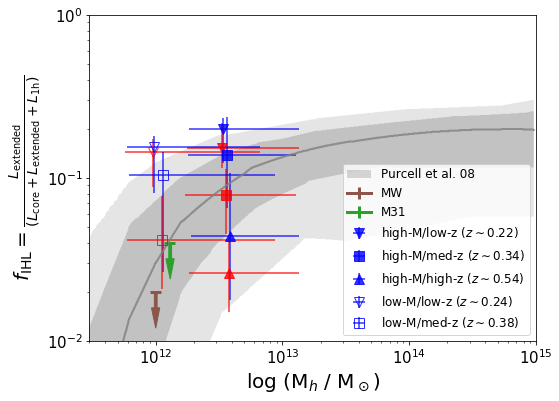

In [88]:
from run_fit import *

r_arr = np.logspace(-1,3,100)
xe2_W19 = gal_profile_model().Wang19_profile(0,3)['params']['sersic2'][2]
sp = np.where((r_arr > 10) & (r_arr<100))[0]

fig, ax = plt.subplots(1,1,figsize=(8,6))

data = np.loadtxt('Illustris_frac/Purcell08_med.txt', delimiter=',')
plt.loglog(10**data[:,0],10**data[:,1],c='grey',lw=2,alpha=0.8)
data_h = np.loadtxt('Illustris_frac/Purcell08_68high.txt', delimiter=',')
data_l = np.loadtxt('Illustris_frac/Purcell08_68low.txt', delimiter=',')
plt.fill_between(10**data[:,0],
                 10**np.interp(data[:,0],data_l[:,0],data_l[:,1]),
                 10**np.interp(data[:,0],data_h[:,0],data_h[:,1]),
                         facecolor='k', alpha=0.15, label='Purcell et al. 08')
data_h = np.loadtxt('Illustris_frac/Purcell08_95high.txt', delimiter=',')
data_l = np.loadtxt('Illustris_frac/Purcell08_95low.txt', delimiter=',')
plt.fill_between(10**data[:,0],
                 10**np.interp(data[:,0],data_l[:,0],data_l[:,1]),
                 10**np.interp(data[:,0],data_h[:,0],data_h[:,1]),
                         facecolor='k', alpha=0.1)

plt.errorbar([1e12], [0.02], xerr=[1e12*0.1], yerr=[0],
             lw=3, color='C5', label='MW')
plt.errorbar([1.3e12], [0.04], xerr=[1.3e12*0.1], yerr=[0],
             lw=3, color='C2', label='M31')
plt.arrow(1e12, 0.02, 0, -0.02*0.4, width=0.5e11, length_includes_head=True, color='C5', 
         head_width=1.5e11, head_length=0.02*0.2, overhang=0)
plt.arrow(1.3e12, 0.04, 0, -0.04*0.4, width=0.5e11*1.3, length_includes_head=True, color='C2', 
         head_width=1.5e11*1.3, head_length=0.04*0.2, overhang=0)
    
r_arr = data_dict['rbins']
for i,(fmt,mfc,name) in enumerate(zip(['v','s','^','v','s'],[None, None, None, 'none', 'none'],
                                        ['high-M/low-z','high-M/med-z','high-M/high-z',
                                         'low-M/low-z','low-M/med-z'])):
    im,m_min, m_max = srcinfo[i]['im'],srcinfo[i]['m_min'],srcinfo[i]['m_max']
    M_min, M_max = srcinfo[i]['M_min'],srcinfo[i]['M_max']    
    
    Mh = 10**np.median(srcinfo[i]['logMh'])
    Mh_low = 10**np.percentile(srcinfo[i]['logMh'], 16)
    Mh_high = 10**np.percentile(srcinfo[i]['logMh'], 84)

    for inst in [1,2]:
        Ltot = np.sum((data_dict[inst][i]['profgal_arr']+data_dict[inst][i]['prof1h'])*r_arr**2)
        Lihl =  np.sum(data_dict[inst][i]['profex']*r_arr**2)
        Ltot_low = np.sum((data_dict[inst][i]['profgal_arr_low']+\
                           data_dict[inst][i]['prof1h_high'])*r_arr**2)
        Lihl_low =  np.sum(data_dict[inst][i]['profex_low']*r_arr**2)
        Ltot_high = np.sum((data_dict[inst][i]['profgal_arr_high']+\
                            data_dict[inst][i]['prof1h_low'])*r_arr**2)
        Lihl_high =  np.sum(data_dict[inst][i]['profex_high']*r_arr**2)
        f = Lihl/Ltot
        f_low = Lihl_low/Ltot_low
        f_high = Lihl_high/Ltot_high

        if inst == 1:
            
            ax.errorbar([Mh*1.01], [f], xerr=[[Mh-Mh_low],[Mh_high-Mh]],
                           yerr=[[f - f_low],[f_high - f]], alpha=0.8,
                            fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='b', 
                        label = name + r' ($z\sim %.2f$)'%np.median(srcinfo[i]['z']))
        else:
            ax.errorbar([Mh*0.99], [f], xerr=[[Mh-Mh_low],[Mh_high-Mh]],
                           yerr=[[f - f_low],[f_high - f]], alpha=0.8,
                    fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='r')
            
ax.legend(fontsize=12)
ax.set_ylim([1e-2,1])
ax.set_xlim([3e11,1e15])
# ax.grid()
ax.set_xlabel('log (M$_h$ / M$_\odot$)', fontsize=20)
ax.set_ylabel(r"$f_{\rm IHL} = \frac{L_{\rm extended}}{(L_{\rm core}+L_{\rm extended}+L_{\rm 1h})}$",
              fontsize=20)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
plt.savefig('/Users/ytcheng/Desktop/fIHL.png',
            dpi = 200, bbox_inches='tight')

In [11]:
from run_fit import *
# from reduction import *
# data_maps = {1: image_reduction(1), 2: image_reduction(2)}
srcinfo = {}
for i,(im,M_min,M_max) in enumerate(zip([1,2,3,2,3],[-23,-23,-23,-22,-22],[-22,-22,-22,-21,-21])):
    m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
    srcinfo[i] = {'im':im, 'm_min':m_min, 'm_max':m_max, 'M_min':M_min, 'M_max':M_max}
    srcinfo[i]['df'] = pd.DataFrame()
    for ifield in [4,5,6,7,8]:
        dfpetro = pd.read_csv('/Volumes/Drive/ciber/data/SDSScats/%s_petro.csv'\
                      %fieldnamedict[ifield],skiprows=1, low_memory=False)
        mask_inst1, mask_inst2 = load_processed_images(data_maps,
                              return_names=[(1,ifield,'mask_inst'),(2,ifield,'mask_inst')])
        field = fieldnamedict[ifield]
        srcdat = ps_src_select(1, ifield, m_min, m_max, 
            [mask_inst1, mask_inst2], Mabs_min=M_min, Mabs_max=M_max, sample_type='all')
        dfpsi = pd.read_csv(mypaths['PScatdat'] + fieldnamedict[ifield] + '.csv')
        dfpsi = dfpsi.iloc[srcdat['idxg_arr']]
        dfpsi, dfpetroi = match_catalog_by_coord(dfpsi,dfpetro)
        dfpsi=dfpsi.reset_index(drop=True)
        dfpetroi=dfpetroi.reset_index(drop=True)
        dfpsi = dfpsi.join(dfpetroi,lsuffix='_ps', rsuffix='_petro')
        srcinfo[i]['df'] = pd.concat([srcinfo[i]['df'], dfpsi])

In [21]:
for i in range(5):
    df = srcinfo[i]['df']
    df['C'] = np.array(df['petroR90_r']/df['petroR50_r'])
    print(len(df.loc[df['C']>2.6])/len(df))

0.6783310901749664
0.533751962323391
0.25833638695492855
0.3617021276595745
0.21249151391717583


In [18]:
# from run_fit import *

# data = {}
# for i,(im,M_min,M_max) in enumerate(zip([1,2,3,2,3],[-23,-23,-23,-22,-22],[-22,-22,-22,-21,-21])):
#     m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
#     data[i] = {}
#     savename='mcmc_3par_joint_m%d_%d_Mabs%d_%d.npy'%(m_min,m_max,M_min,M_max)
#     profgal_arr1,profpsf_arr1,profgalint_arr1 = 0,0,0
#     profgal_arr2,profpsf_arr2,profgalint_arr2 = 0,0,0
#     profgal_arr1_low,profpsf_arr1_low,profgalint_arr1_low = 0,0,0
#     profgal_arr2_low,profpsf_arr2_low,profgalint_arr2_low = 0,0,0
#     profgal_arr1_high,profpsf_arr1_high,profgalint_arr1_high = 0,0,0
#     profgal_arr2_high,profpsf_arr2_high,profgalint_arr2_high = 0,0,0

#     for ifield in [4,5,6,7,8]:
#         print(i,ifield)
#         fitparamdat = get_mcmc_fit_params_3par(1,im, ifield=None,savename=savename)
#         Re2, A1h, A2h = fitparamdat['Re2'], fitparamdat['A1h'], fitparamdat['A2h'],
#         Re2_low, A1h_low, A2h_low \
#         = fitparamdat['Re2_low'], fitparamdat['A1h_low'], fitparamdat['A2h_low']
#         Re2_high, A1h_high, A2h_high \
#         = fitparamdat['Re2_high'], fitparamdat['A1h_high'], fitparamdat['A2h_high']
#         param_fit = fit_stacking_mcmc(1, ifield, im, m_min=m_min, m_max=m_max,
#                                      Mabs_min=M_min, Mabs_max=M_max)

#         modelprof = param_fit.get_profexcess_model(Re2=Re2, A1h=A1h, A2h=A2h)
#         profgal_arr1 += modelprof['profgal']
#         profpsf_arr1 += modelprof['profpsf']
#         norm_int = param_fit.get_gal_profile_norm(Re2=Re2, A1h=A1h, A2h=A2h)
#         profint = gal_profile_model().Wang19_profile(param_fit.rbins, im, Re2=Re2, A1h=A1h, A2h=A2h)
#         profgalint_arr1 += profint['I_arr']/profint['I_arr'][0] * modelprof['normg'] * norm_int

#         modelprof = param_fit.get_profexcess_model(Re2=Re2_low, A1h=A1h, A2h=A2h)
#         profgal_arr1_low += modelprof['profgal']
#         profpsf_arr1_low += modelprof['profpsf']
#         norm_int = param_fit.get_gal_profile_norm(Re2=Re2_low, A1h=A1h, A2h=A2h)
#         profint = gal_profile_model().Wang19_profile(param_fit.rbins, im, Re2=Re2, A1h=A1h, A2h=A2h)
#         profgalint_arr1_low += profint['I_arr']/profint['I_arr'][0] * modelprof['normg'] * norm_int
        
#         modelprof = param_fit.get_profexcess_model(Re2=Re2_high, A1h=A1h, A2h=A2h)
#         profgal_arr1_high += modelprof['profgal']
#         profpsf_arr1_high += modelprof['profpsf']
#         norm_int = param_fit.get_gal_profile_norm(Re2=Re2_high, A1h=A1h, A2h=A2h)
#         profint = gal_profile_model().Wang19_profile(param_fit.rbins, im, Re2=Re2, A1h=A1h, A2h=A2h)
#         profgalint_arr1_high += profint['I_arr']/profint['I_arr'][0] * modelprof['normg'] * norm_int
        

#         fitparamdat = get_mcmc_fit_params_3par(2, im, ifield=None,savename=savename)
#         Re2, A1h, A2h = fitparamdat['Re2'], fitparamdat['A1h'], fitparamdat['A2h']
#         param_fit = fit_stacking_mcmc(2, ifield, im, m_min=m_min, m_max=m_max,
#                                      Mabs_min=M_min, Mabs_max=M_max)
        
#         modelprof = param_fit.get_profexcess_model(Re2=Re2, A1h=A1h, A2h=A2h)
#         profgal_arr2 += modelprof['profgal']
#         profpsf_arr2 += modelprof['profpsf']
#         norm_int = param_fit.get_gal_profile_norm(Re2=Re2, A1h=A1h, A2h=A2h)
#         profint = gal_profile_model().Wang19_profile(param_fit.rbins, im, Re2=Re2, A1h=A1h, A2h=A2h)
#         profgalint_arr2 += profint['I_arr']/profint['I_arr'][0] * modelprof['normg'] * norm_int

#         modelprof = param_fit.get_profexcess_model(Re2=Re2_low, A1h=A1h, A2h=A2h)
#         profgal_arr2_low += modelprof['profgal']
#         profpsf_arr2_low += modelprof['profpsf']
#         norm_int = param_fit.get_gal_profile_norm(Re2=Re2_low, A1h=A1h, A2h=A2h)
#         profint = gal_profile_model().Wang19_profile(param_fit.rbins, im, Re2=Re2, A1h=A1h, A2h=A2h)
#         profgalint_arr2_low += profint['I_arr']/profint['I_arr'][0] * modelprof['normg'] * norm_int
        
#         modelprof = param_fit.get_profexcess_model(Re2=Re2_high, A1h=A1h, A2h=A2h)
#         profgal_arr2_high += modelprof['profgal']
#         profpsf_arr2_high += modelprof['profpsf']
#         norm_int = param_fit.get_gal_profile_norm(Re2=Re2_high, A1h=A1h, A2h=A2h)
#         profint = gal_profile_model().Wang19_profile(param_fit.rbins, im, Re2=Re2, A1h=A1h, A2h=A2h)
#         profgalint_arr2_high += profint['I_arr']/profint['I_arr'][0] * modelprof['normg'] * norm_int
        
    
#     data[i]['profgal_arr1'] = profgal_arr1 / 5
#     data[i]['profpsf_arr1'] = profpsf_arr1 / 5
#     data[i]['profgalint_arr1'] = profgalint_arr1 / 5
#     data[i]['profgal_arr2'] = profgal_arr2 / 5
#     data[i]['profpsf_arr2'] = profpsf_arr2 / 5
#     data[i]['profgalint_arr2'] = profgalint_arr2 / 5
    
#     data[i]['profgal_arr1_high'] = profgal_arr1_high / 5
#     data[i]['profpsf_arr1_high'] = profpsf_arr1_high / 5
#     data[i]['profgalint_arr1_high'] = profgalint_arr1_high / 5
#     data[i]['profgal_arr2_high'] = profgal_arr2_high / 5
#     data[i]['profpsf_arr2_high'] = profpsf_arr2_high / 5
#     data[i]['profgalint_arr2_high'] = profgalint_arr2_high / 5

#     data[i]['profgal_arr1_low'] = profgal_arr1_low / 5
#     data[i]['profpsf_arr1_low'] = profpsf_arr1_low / 5
#     data[i]['profgalint_arr1_low'] = profgalint_arr1_low / 5
#     data[i]['profgal_arr2_low'] = profgal_arr2_low / 5
#     data[i]['profpsf_arr2_low'] = profpsf_arr2_low / 5
#     data[i]['profgalint_arr2_low'] = profgalint_arr2_low / 5
    
#     data[i]['profex1'] = data[i]['profgal_arr1']  - data[i]['profpsf_arr1']
#     data[i]['profex2'] = data[i]['profgal_arr2']  - data[i]['profpsf_arr2']
#     data[i]['profex1_low'] = data[i]['profgal_arr1_low']  - data[i]['profpsf_arr1_low']
#     data[i]['profex2_low'] = data[i]['profgal_arr2_low']  - data[i]['profpsf_arr2_low']
#     data[i]['profex1_high'] = data[i]['profgal_arr1_high']  - data[i]['profpsf_arr1_high']
#     data[i]['profex2_high'] = data[i]['profgal_arr2_high']  - data[i]['profpsf_arr2_high']

# data['rbins'] = param_fit.rbins
# data['rbinedges'] = param_fit.rbinedges

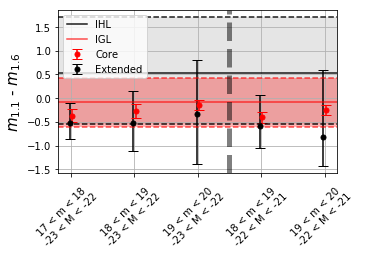

In [36]:
fig, ax = plt.subplots(1,1,figsize=(5,3))

x_arr = np.arange(5)
for i,(im,M_min,M_max) in enumerate(zip([1,2,3,2,3],[-23,-23,-23,-22,-22],[-22,-22,-22,-21,-21])):
    m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
    
    SNRnorm1, SNRnorm2 = 0, 0
    for ifield in [4,5,6,7,8]:
        stackdat = stacking(1, ifield, m_min=m_min, m_max=m_max, Mabs_min=M_min, Mabs_max=M_max,
                        load_from_file=True).stackdat
        SNRnorm1 += stackdat['profcb'][0]/np.sqrt(stackdat['cov']['profcb'][0][0])
        stackdat = stacking(2, ifield, m_min=m_min, m_max=m_max, Mabs_min=M_min, Mabs_max=M_max,
                        load_from_file=True).stackdat
        SNRnorm2 += stackdat['profcb'][0]/np.sqrt(stackdat['cov']['profcb'][0][0])
    
    SNRnorm1 /= 5
    SNRnorm2 /= 5

    rbins,rbinedges = data['rbins'], data['rbinedges']
    drs = np.diff(rbinedges)
    
    Fpsf1 = np.sum(data[i]['profpsf_arr1']*2*np.pi*rbins*drs)
    Fpsf1 = Fpsf1 * (u.nW*u.arcsec**2/u.m**2/u.sr)/ (band_info(1).nu * u.GHz)
    m_psf1 = -2.5 * np.log10(Fpsf1.to(u.Jy).value / 3631)
    Fpsf2 = np.sum(data[i]['profpsf_arr2']*2*np.pi*rbins*drs)
    Fpsf2 = Fpsf2 * (u.nW*u.arcsec**2/u.m**2/u.sr)/ (band_info(1).nu * u.GHz)
    m_psf2 = -2.5 * np.log10(Fpsf2.to(u.Jy).value / 3631)

    Fpsf1_low = Fpsf1 * (1-1/SNRnorm1)
    m_psf1_low = -2.5 * np.log10(Fpsf1_low.to(u.Jy).value / 3631)
    Fpsf2_low = Fpsf2 * (1-1/SNRnorm2)
    m_psf2_low = -2.5 * np.log10(Fpsf2_low.to(u.Jy).value / 3631)

    Fpsf1_high = Fpsf1 * (1+1/SNRnorm1)
    m_psf1_high = -2.5 * np.log10(Fpsf1_high.to(u.Jy).value / 3631)
    Fpsf2_high = Fpsf2 * (1+1/SNRnorm2)
    m_psf2_high = -2.5 * np.log10(Fpsf2_high.to(u.Jy).value / 3631)

    Fgal1 = np.sum(data[i]['profgal_arr1']*2*np.pi*rbins*drs)
    Fgal1 = Fgal1 * (u.nW*u.arcsec**2/u.m**2/u.sr)/ (band_info(1).nu * u.GHz)
    m_gal1 = -2.5 * np.log10(Fgal1.to(u.Jy).value / 3631)
    Fgal2 = np.sum(data[i]['profgal_arr2']*2*np.pi*rbins*drs)
    Fgal2 = Fgal2 * (u.nW*u.arcsec**2/u.m**2/u.sr)/ (band_info(1).nu * u.GHz)
    m_gal2 = -2.5 * np.log10(Fgal2.to(u.Jy).value / 3631)

    Fgal1_low = np.sum(data[i]['profgal_arr1_low']*2*np.pi*rbins*drs)
    Fgal1_low = Fgal1_low * (u.nW*u.arcsec**2/u.m**2/u.sr)/ (band_info(1).nu * u.GHz)
    m_gal1_low = -2.5 * np.log10(Fgal1_low.to(u.Jy).value / 3631)
    Fgal2_low = np.sum(data[i]['profgal_arr2_low']*2*np.pi*rbins*drs)
    Fgal2_low = Fgal2_low * (u.nW*u.arcsec**2/u.m**2/u.sr)/ (band_info(1).nu * u.GHz)
    m_gal2_low = -2.5 * np.log10(Fgal2_low.to(u.Jy).value / 3631)

    Fgal1_high = np.sum(data[i]['profgal_arr1_high']*2*np.pi*rbins*drs)
    Fgal1_high = Fgal1_high * (u.nW*u.arcsec**2/u.m**2/u.sr)/ (band_info(1).nu * u.GHz)
    m_gal1_high = -2.5 * np.log10(Fgal1_high.to(u.Jy).value / 3631)
    Fgal2_high = np.sum(data[i]['profgal_arr2_high']*2*np.pi*rbins*drs)
    Fgal2_high = Fgal2_high * (u.nW*u.arcsec**2/u.m**2/u.sr)/ (band_info(1).nu * u.GHz)
    m_gal2_high = -2.5 * np.log10(Fgal2_high.to(u.Jy).value / 3631)

    m_ex1 = -2.5 * np.log10((Fgal1-Fpsf1).to(u.Jy).value / 3631)
    m_ex2 = -2.5 * np.log10((Fgal2-Fpsf2).to(u.Jy).value / 3631)
    m_ex1_high = -2.5 * np.log10((Fgal1_low-Fpsf1).to(u.Jy).value / 3631)
    m_ex2_high = -2.5 * np.log10((Fgal2_low-Fpsf2).to(u.Jy).value / 3631)
    m_ex1_low = -2.5 * np.log10((Fgal1_high-Fpsf1).to(u.Jy).value / 3631)
    m_ex2_low = -2.5 * np.log10((Fgal2_high-Fpsf2).to(u.Jy).value / 3631)
    
    dm_psf = m_psf1 - m_psf2
    dm_psf_low = m_psf1_high - m_psf2_low
    dm_psf_high = m_psf1_low - m_psf2_high
    dm_ex = m_ex1 - m_ex2
    dm_ex_high = m_ex1_high - m_ex2_low
    dm_ex_low = m_ex1_low - m_ex2_high
    
    if i==0:
        ax.errorbar(x_arr[i]+0.02, [dm_psf], [[dm_psf - dm_psf_low],[dm_psf_high-dm_psf]],
                        fmt='.', capsize=5, markersize=10, c='r', label = 'Core')
        ax.errorbar(x_arr[i]-0.02, [dm_ex], [[dm_ex - dm_ex_low],[dm_ex_high-dm_ex]],
                        fmt='.', capsize=5, markersize=10, c='k', label = 'Extended')
    else:       
        ax.errorbar(x_arr[i]+0.02, [dm_psf], [[dm_psf - dm_psf_low],[dm_psf_high-dm_psf]],
                        fmt='.', capsize=5, markersize=10, c='r')
        ax.errorbar(x_arr[i]-0.02, [dm_ex], [[dm_ex - dm_ex_low],[dm_ex_high-dm_ex]],
                        fmt='.', capsize=5, markersize=10, c='k')    

ax.axhline(-2.5*np.log10((7.0)/(11.4)),c='k',ls='-',alpha=0.9,label='IHL')
ax.axhline(-2.5*np.log10((7.0+4.0)/(11.4-4.8)),c='k',ls='--',alpha=0.9)
ax.axhline(-2.5*np.log10((7.0-3.5)/(11.4+5.4)),c='k',ls='--',alpha=0.9)
ax.fill_between([-1,5],[-2.5*np.log10((7.0+4.0)/(11.4-4.8)),-2.5*np.log10((7.0+4.0)/(11.4-4.8))],
               [-2.5*np.log10((7.0-3.5)/(11.4+5.4)),-2.5*np.log10((7.0-3.5)/(11.4+5.4))],
                facecolor='k', alpha=0.1)

ax.axhline(-2.5*np.log10((9.7+3.0)/(9.0-1.7)),c='r',ls='--',alpha=0.7)
ax.axhline(-2.5*np.log10((9.7)/(9.0)),c='r',ls='-',alpha=0.7,label='IGL')
ax.axhline(-2.5*np.log10((9.7-1.9)/(9.0+2.6)),c='r',ls='--',alpha=0.7)
ax.fill_between([-1,5],[-2.5*np.log10((9.7+3.0)/(9.0-1.7)),-2.5*np.log10((9.7+3.0)/(9.0-1.7))],
               [-2.5*np.log10((9.7-1.9)/(9.0+2.6)),-2.5*np.log10((9.7-1.9)/(9.0+2.6))],
                facecolor='r', alpha=0.3)

ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(xlabel_arr,rotation = 45)
ax.axvline(2.5, c='k',lw=5, ls='--',alpha=0.5)
ax.set_xlim([-0.2,4.2])
ax.grid()
ax.legend(loc=2,fontsize=10)
ax.set_ylabel("$m_{1.1}$ - $m_{1.6}$", fontsize=15)
plt.savefig('plots/paperfig/color_IHL_IGL.png',
            dpi = 300, bbox_inches='tight')

Petrosian Mag

https://www.sdss.org/dr12/algorithms/magnitudes/

http://skyserver.sdss.org/dr13/en/help/browser/browser.aspx#&&history=description+PhotoObj+V

In [9]:
# from run_fit import *
# # from reduction import *
# # data_maps = {1: image_reduction(1), 2: image_reduction(2)}
# srcinfo = {}
# for i,(im,M_min,M_max) in enumerate(zip([1,2,3,2,3],[-23,-23,-23,-22,-22],[-22,-22,-22,-21,-21])):
#     m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
#     srcinfo[i] = {'im':im, 'm_min':m_min, 'm_max':m_max, 'M_min':M_min, 'M_max':M_max}
#     srcinfo[i]['df'] = pd.DataFrame()
#     for ifield in [4,5,6,7,8]:
#         dfpetro = pd.read_csv('/Volumes/Drive/ciber/data/SDSScats/%s_petro.csv'\
#                       %fieldnamedict[ifield],skiprows=1, low_memory=False)
#         mask_inst1, mask_inst2 = load_processed_images(data_maps,
#                               return_names=[(1,ifield,'mask_inst'),(2,ifield,'mask_inst')])
#         field = fieldnamedict[ifield]
#         srcdat = ps_src_select(1, ifield, m_min, m_max, 
#             [mask_inst1, mask_inst2], Mabs_min=M_min, Mabs_max=M_max, sample_type='all')
#         dfpsi = pd.read_csv(mypaths['PScatdat'] + fieldnamedict[ifield] + '.csv')
#         dfpsi = dfpsi.iloc[srcdat['idxg_arr']]
#         dfpsi, dfpetroi = match_catalog_by_coord(dfpsi,dfpetro)
#         dfpsi=dfpsi.reset_index(drop=True)
#         dfpetroi=dfpetroi.reset_index(drop=True)
#         dfpsi = dfpsi.join(dfpetroi,lsuffix='_ps', rsuffix='_petro')
#         srcinfo[i]['df'] = pd.concat([srcinfo[i]['df'], dfpsi])

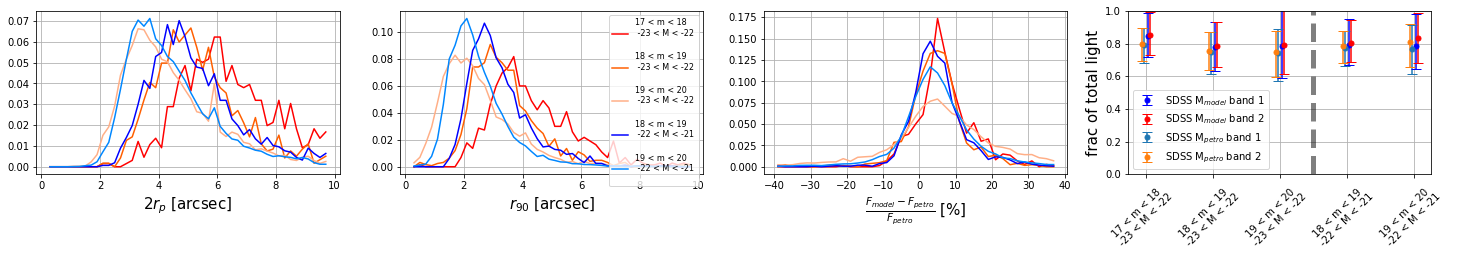

In [60]:
fig, ax = plt.subplots(1,4,figsize=(25,3))
r_arr = np.logspace(-1,3,100)

f1p_arr = np.zeros([3,5])
f2p_arr = np.zeros([3,5])
f1m_arr = np.zeros([3,5])
f2m_arr = np.zeros([3,5])
xlabel_arr = []
for i,(im,M_min,M_max,c) in enumerate(zip([1,2,3,2,3],[-23,-23,-23,-22,-22],[-22,-22,-22,-21,-21],
                                         ['#ff0000','#ff5f00','#ffaf87','#0000ff','#0087ff'])):
    m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
    xlabel_arr.append('%d < m < %d \n %d < M < %d \n'%(m_min,m_max, M_min, M_max))

    df = srcinfo[i]['df']
    
    rbinedges = np.arange(0.2,10,0.2)
    rbins = (rbinedges[1:] + rbinedges[:-1]) / 2
    rps = df['petroRad_i'].loc[df['petroRad_i']>0]
    h, _ = np.histogram(2*rps, bins = rbinedges)
    ax[0].plot(rbins, h/np.sum(h),c=c)
    h, _ = np.histogram(df['petroR90_r'].loc[df['petroR90_r']>0], bins = rbinedges)
    ax[1].plot(rbins, h/np.sum(h),c=c,label=xlabel_arr[-1])
    
    fbinedges = np.arange(-40,40,2)
    fbins = (fbinedges[1:] + fbinedges[:-1]) / 2
    F_model_petro = 10**(-(df['r'] - df['petroMag_r'])/2.5)
    h, _ = np.histogram((F_model_petro-1)*100, bins = fbinedges)
    ax[2].plot(fbins, h/np.sum(h),c=c)    
    for inst in [1,2]:
        savename='mcmc_3par_joint_m%d_%d_Mabs%d_%d.npy'%(m_min,m_max,M_min,M_max)
        fitparamdat = get_mcmc_fit_params_3par(inst,im, ifield=None,savename=savename)
        Re2 = fitparamdat['Re2']
        Re2_low = fitparamdat['Re2_low']
        Re2_high = fitparamdat['Re2_high']

        galprofdat = gal_profile_model().Wang19_profile(r_arr, im, Re2=Re2)
        p = galprofdat['I_arr']
        p = p/np.sum(p*r_arr**2)
        galprofdat = gal_profile_model().Wang19_profile(r_arr, im, Re2=Re2_high)
        p_high = galprofdat['I_arr']
        p_high = p_high/np.sum(p_high*r_arr**2)
        galprofdat = gal_profile_model().Wang19_profile(r_arr, im, Re2=Re2_low)
        p_low = galprofdat['I_arr']
        p_low = p_low/np.sum(p_low*r_arr**2)
        Fpetro = np.array([np.sum(p[r_arr<2*rp]*r_arr[r_arr<2*rp]**2) for rp in rps])
        Fpetro_low = np.array([np.sum(p_low[r_arr<2*rp]*r_arr[r_arr<2*rp]**2) for rp in rps])
        Fpetro_high = np.array([np.sum(p_high[r_arr<2*rp]*r_arr[r_arr<2*rp]**2) for rp in rps])
        Fmodel = Fpetro * F_model_petro
        Fmodel_low = Fpetro_low * F_model_petro
        Fmodel_high = Fpetro_high * F_model_petro        
        
        if inst == 1:
            f1p_arr[:,i] = np.median(Fpetro),np.percentile(Fpetro_high,16),np.percentile(Fpetro_low,84)
            f1m_arr[:,i] = np.median(Fmodel),np.percentile(Fmodel_high,16),np.percentile(Fmodel_low,84)
        else:
            f2p_arr[:,i] = np.median(Fpetro),np.percentile(Fpetro_high,16),np.percentile(Fpetro_low,84)
            f2m_arr[:,i] = np.median(Fmodel),np.percentile(Fmodel_high,16),np.percentile(Fmodel_low,84)
            
x_arr = np.arange(5)
ax[3].errorbar(x_arr+0.03, f1m_arr[0],[f1m_arr[0] - f1m_arr[2],
                                       f1m_arr[1] - f1m_arr[0]],
                fmt='.', capsize=5, markersize=10, c='b', label = r'SDSS M$_{model}$ band 1')
ax[3].errorbar(x_arr+0.06, f2m_arr[0],[f2m_arr[0] - f2m_arr[2],
                                       f2m_arr[1] - f2m_arr[0]],
                fmt='.', capsize=5, markersize=10, c='r', label = r'SDSS M$_{model}$ band 2')
ax[3].errorbar(x_arr-0.03, f1p_arr[0],[f1p_arr[0] - f1p_arr[2],
                                       f1p_arr[1] - f1p_arr[0]],
                fmt='.', capsize=5, markersize=10, c='C0', label = r'SDSS M$_{petro}$ band 1')
ax[3].errorbar(x_arr-0.06, f2p_arr[0],[f2p_arr[0] - f2p_arr[2],
                                       f2p_arr[1] - f2p_arr[0]],
                fmt='.', capsize=5, markersize=10, c='C1', label = r'SDSS M$_{petro}$ band 2')
ax[3].legend()
ax[3].set_xticks([0,1,2,3,4])
ax[3].set_ylim([0,1])
ax[3].set_xticklabels(xlabel_arr,rotation = 45)
ax[3].axvline(2.5, c='k',lw=5, ls='--',alpha=0.5)
ax[3].grid()
ax[3].set_ylabel("frac of total light", fontsize=15)


ax[0].grid()
ax[0].set_xlabel(r'2$r_p$ [arcsec]',fontsize=15)

ax[1].grid()
ax[1].set_xlabel(r'$r_{90}$ [arcsec]',fontsize=15)
ax[1].legend(fontsize=8)

ax[2].grid()
ax[2].set_xlabel(r'$\frac{F_{model}-F_{petro}}{F_{petro}}$ [%]',fontsize=15)

plt.savefig('/Users/ytcheng/Desktop/petro.png',
            dpi = 150, bbox_inches='tight')

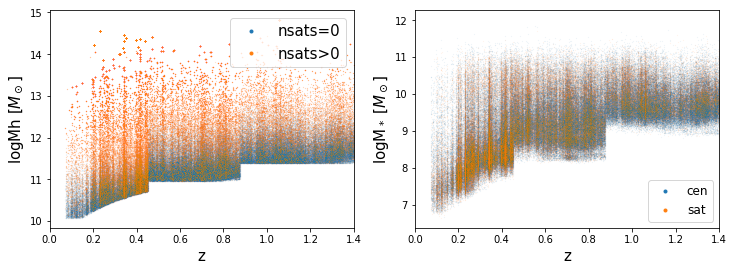

In [151]:
# df1 = get_micecat_df(0,return_full=True)
fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot([-1],[12],'C0.',label='nsats=0')
ax[0].plot([-1],[12],'C1.',label='nsats>0')
ax[0].legend(fontsize=15)
ax[0].plot(df1['z_cgal'].loc[df1['nsats']==0],
           df1['lmhalo'].loc[df1['nsats']==0],'C0.',markersize=0.05)
ax[0].plot(df1['z_cgal'].loc[df1['nsats']!=0],
           df1['lmhalo'].loc[df1['nsats']!=0],'C1.',markersize=0.05)
ax[0].set_xlim([0,1.4])
ax[0].set_xlabel('z',fontsize=15)
ax[0].set_ylabel(r'logMh [$M_\odot$]',fontsize=15)

ax[1].plot([-1],[12],'C0.',label='cen')
ax[1].plot([-1],[12],'C1.',label='sat')
ax[1].legend(fontsize=12)
ax[1].plot(df1['z_cgal'].loc[df1['flag_central']==0],
           df1['lmstellar'].loc[df1['flag_central']==0],'C0.',markersize=0.05)
ax[1].plot(df1['z_cgal'].loc[df1['flag_central']==1],
           df1['lmstellar'].loc[df1['flag_central']==1],'C1.',markersize=0.05)
ax[1].set_xlim([0,1.4])
ax[1].set_xlabel('z',fontsize=15)
ax[1].set_ylabel(r'logM$_*$ [$M_\odot$]',fontsize=15)
plt.savefig('/Users/ytcheng/Desktop/micecat.png',dpi = 150, bbox_inches='tight')

MICECAT field 0, 0 < ra < 2, 0 < dec < 2
0.37313124516756435 nW / (m2 sr) 0.9563177282969985 nW / (m2 sr)
0.4864786252416789 nW / (m2 sr) 1.3138116194182672 nW / (m2 sr)
0.45990191420909293 nW / (m2 sr) 1.266390135821784 nW / (m2 sr)
0.37905594107265544 nW / (m2 sr) 0.9324948207127849 nW / (m2 sr)
0.4674406622111228 nW / (m2 sr) 1.187620588136101 nW / (m2 sr)


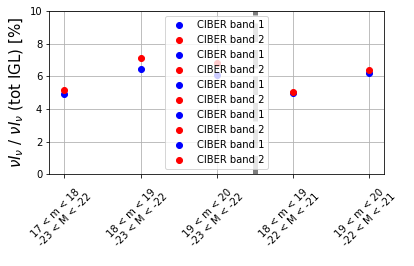

In [31]:
from srcmap import *
from mask import *
from power_spec import *
from micecat import *

# df = get_micecat_df(0)
dfc = df.loc[df['flag_central']==0]
dfs = df.copy()
dfs['Fnu_I'] = 3631 * 10**(-df['I'] / 2.5)
dfs['Fnu_H'] = 3631 * 10**(-df['H'] / 2.5)
dfs1 = dfs.groupby('unique_halo_id')[['Fnu_I','Fnu_H']].sum()
dfc = dfc.join(dfs1, on='unique_halo_id', how='inner')
dfc['I'] = -2.5 * np.log10(dfc['Fnu_I']/3631)
dfc['H'] = -2.5 * np.log10(dfc['Fnu_H']/3631)

fig, ax = plt.subplots(1,1, figsize=(6,3))

nuInu1 = ((band_info(1).nu * u.GHz)*(np.sum(dfs['Fnu_I']) * u.Jy) / (4 * u.deg**2)).to(u.nW/u.m**2/u.sr)
nuInu2 = ((band_info(2).nu * u.GHz)*(np.sum(dfs['Fnu_H']) * u.Jy) / (4 * u.deg**2)).to(u.nW/u.m**2/u.sr)
xlabel_arr = []
for i,(im,M_min,M_max) in enumerate(zip([1,2,3,2,3],[-23,-23,-23,-22,-22],[-22,-22,-22,-21,-21])):
    m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
    xlabel_arr.append('%d < m < %d \n %d < M < %d \n'%(m_min,m_max, M_min, M_max))

    dfi = dfs.loc[(dfs['I']>=m_min) & (dfs['I']<m_max) &(dfs['M_I']>=M_min) & (dfs['M_I']<M_max)]
    nuInu1i = ((band_info(1).nu * u.GHz)*(np.sum(dfi['Fnu_I']) * u.Jy) /\
              (4 * u.deg**2)).to(u.nW/u.m**2/u.sr)
    nuInu2i = ((band_info(2).nu * u.GHz)*(np.sum(dfi['Fnu_H']) * u.Jy) /\
              (4 * u.deg**2)).to(u.nW/u.m**2/u.sr)
    print(nuInu1i,nuInu2i)
    ax.plot(i, nuInu1i/nuInu1 * 100, 'bo',label='CIBER band 1')
    ax.plot(i, nuInu2i/nuInu2 * 100, 'ro',label='CIBER band 2')

ax.set_xticks([0,1,2,3,4])
ax.set_ylim([0,10])
ax.set_xticklabels(xlabel_arr,rotation = 45)
ax.axvline(2.5, c='k',lw=5, ls='--',alpha=0.5)
ax.legend()
ax.set_ylabel(r'$\nu I_\nu$ / $\nu I_\nu$ (tot IGL) [%]',fontsize=15)
ax.grid()
# plt.savefig('/Users/ytcheng/Desktop/EBLfrac.png',dpi = 150, bbox_inches='tight')

***

In [21]:
from run_fit import *
import corner
from PIL import Image

for inst in [1,2]:

    for ifield in [0,4,5,6,7,8]:
        for im,(m_min,m_max) in enumerate(zip(np.concatenate((magbindict['m_min'],[17]))
                                              ,np.concatenate((magbindict['m_max'],[20])))):
            subsub = True if im==0 else False
            if im == 4:
                R200 = gal_profile_model().Wang19_profile(0,3)['params']['R200']
            else:
                R200 = gal_profile_model().Wang19_profile(0,im)['params']['R200']

            xe2_W19 = gal_profile_model().Wang19_profile(0,3)['params']['sersic2'][2]
            Re2_W19 = R200 * xe2_W19

            if ifield==0:
                savedir = mypaths['alldat'] + 'TM' + str(inst) + '/'
                savename = 'mcmc_3par_joint' + \
                '_m' + str(m_min) + '_' + str(m_max) + '.npy'
            else:
                savedir = mypaths['alldat'] + 'TM' + str(inst) + '/'
                savename = 'mcmc_3par_' + fieldnamedict[ifield] + \
                '_m' + str(m_min) + '_' + str(m_max) + '.npy'

            if subsub:
                savename = savename[:-4] + '_sub.npy'

            samples = np.load(savedir + savename)
            steps, nwalkers, nparams = samples.shape

            flatsamps = samples.copy()
            flatsamps[:,:,0] = flatsamps[:,:,0] * R200
            # chain rejection
            chain_use_idx = []
            Nchain = flatsamps.shape[1]
            for i in range(Nchain):
                if not np.any(flatsamps[100:,i,1]>100):
                    chain_use_idx.append(i)
            flatsamps = flatsamps[150:,chain_use_idx,:].reshape((-1,3))

            bins0 = np.linspace(np.min(flatsamps[:,0]), np.max(flatsamps[:,0]), 20)
            bins1 = np.linspace(np.min(flatsamps[:,1]), np.max(flatsamps[:,1]), 20)
            bins2 = np.linspace(np.min(flatsamps[:,2]), np.max(flatsamps[:,2]), 20)

            if ifield==0:
                truths_arr = np.median(flatsamps, axis=0)
                vmax0 = 2*np.max(flatsamps[:,0])
                vmax1 = 2*np.max(flatsamps[:,1])
                vmax2 = 2*np.max(flatsamps[:,2])

            levels= 1.0 - np.exp(-0.5 * np.arange(1, 2.1, 1) ** 2)
            figure = corner.corner(flatsamps, levels = levels,fill_contours=True,plot_datapoints=False,
                                   bins=[bins0, bins1, bins2],label_kwargs={'fontsize':'xx-large'},
                                   range=[(0,vmax0),(0,vmax1),(0,vmax2)],
                                   title_kwargs={'fontsize':'x-large'},
                                   show_titles=True,labels=["$R_{e_2}$", r"$A_{\rm 1h}$", r"$A_{\rm 2h}$"],
                                   #truths=[Re2_W19,1,1])
                                   truths=truths_arr)
            if ifield==0:
                plt.savefig('plots/TM%d/mcmc_joint_m%d_%d.png'\
                            %(inst,m_min, m_max), dpi=150)
            else:
                plt.savefig('plots/TM%d/mcmc_%s_m%d_%d.png'\
                            %(inst,fieldnamedict[ifield], m_min, m_max), dpi=150)

            plt.close()


    #combine four mag plots into one plot
    for ifield in [0,4,5,6,7,8]:
        result = Image.new("RGB", (4000,800))    
        for im,(m_min,m_max) in enumerate(zip(np.concatenate((magbindict['m_min'],[17]))
                                              ,np.concatenate((magbindict['m_max'],[20])))):
            fieldname = 'joint' if ifield==0 else fieldnamedict[ifield]
            fname = 'plots/TM%d/mcmc_%s_m%d_%d.png'\
                            %(inst, fieldname, m_min, m_max)
            path = os.path.expanduser(fname)
            img = Image.open(path)
            img.thumbnail((800, 800), Image.ANTIALIAS)
            x = im * 800
            y = 0
            w, h = img.size
            result.paste(img, (x, y, x + w, y + h))
            os.remove(fname)

        result.save(os.path.expanduser('plots/TM%d/mcmc_%s_3par.png'%(inst,fieldname)))

In [28]:
from run_fit import *
import corner
from PIL import Image

for inst in [2]:
    for ifield in [0,4,5,6,7,8]:
        for i,(im,M_min,M_max) in enumerate(zip([1,2,3,2,3],
                                                [-23,-23,-23,-22,-22],
                                                [-22,-22,-22,-21,-21])):
            m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
            if ifield==0:
                savedir = mypaths['alldat'] + 'TM' + str(inst) + '/'
                savename='mcmc_3par_joint_m%d_%d_Mabs%d_%d.npy'%(m_min,m_max,M_min,M_max)
            else:
                savedir = mypaths['alldat'] + 'TM' + str(inst) + '/'
                savename='mcmc_3par_%s_m%d_%d_Mabs%d_%d.npy'%(fieldnamedict[ifield],
                                                              m_min,m_max,M_min,M_max)
            
            R200 = gal_profile_model().Wang19_profile(0,im)['params']['R200']
            xe2_W19 = gal_profile_model().Wang19_profile(0,3)['params']['sersic2'][2]
            Re2_W19 = R200 * xe2_W19

            samples = np.load(savedir + savename)
            steps, nwalkers, nparams = samples.shape

            flatsamps = samples.copy()
            flatsamps[:,:,0] = flatsamps[:,:,0] * R200
            
            # chain rejection
            chain_use_idx = []
            Nchain = flatsamps.shape[1]
            for i in range(Nchain):
                if not np.any(flatsamps[100:,i,1]>100):
                    chain_use_idx.append(i)
            flatsamps = flatsamps[150:,chain_use_idx,:].reshape((-1,3))

            bins0 = np.linspace(np.min(flatsamps[:,0]), np.max(flatsamps[:,0]), 20)
            bins1 = np.linspace(np.min(flatsamps[:,1]), np.max(flatsamps[:,1]), 20)
            bins2 = np.linspace(np.min(flatsamps[:,2]), np.max(flatsamps[:,2]), 20)

            if ifield==0:
                truths_arr = np.median(flatsamps, axis=0)
                vmax0 = 2*np.max(flatsamps[:,0])
                vmax1 = 2*np.max(flatsamps[:,1])
                vmax2 = 2*np.max(flatsamps[:,2])

            levels= 1.0 - np.exp(-0.5 * np.arange(1, 2.1, 1) ** 2)
            figure = corner.corner(flatsamps, levels = levels,fill_contours=True,plot_datapoints=False,
                                   bins=[bins0, bins1, bins2],label_kwargs={'fontsize':'xx-large'},
                                   range=[(0,vmax0),(0,vmax1),(0,vmax2)],
                                   title_kwargs={'fontsize':'x-large'},
                                   show_titles=True,labels=["$R_{e_2}$", r"$A_{\rm 1h}$", r"$A_{\rm 2h}$"],
                                   #truths=[Re2_W19,1,1])
                                   truths=truths_arr)
            if ifield==0:
                plt.savefig('plots/TM%d/mcmc_joint_m%d_%d_M%d_%d.png'\
                            %(inst,m_min, m_max, M_min, M_max), dpi=150)
            else:
                plt.savefig('plots/TM%d/mcmc_%s_m%d_%d_M%d_%d.png'\
                            %(inst,fieldnamedict[ifield], m_min, m_max, M_min, M_max), dpi=150)

            plt.close()


    #combine four mag plots into one plot
    for ifield in [0,4,5,6,7,8]:
        result = Image.new("RGB", (4000,800))    
        for i,(im,M_min,M_max) in enumerate(zip([1,2,3,2,3],
                                                [-23,-23,-23,-22,-22],
                                                [-22,-22,-22,-21,-21])):
            m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
            fieldname = 'joint' if ifield==0 else fieldnamedict[ifield]
            fname = 'plots/TM%d/mcmc_%s_m%d_%d_M%d_%d.png'\
                            %(inst, fieldname, m_min, m_max, M_min, M_max)
            path = os.path.expanduser(fname)
            img = Image.open(path)
            img.thumbnail((800, 800), Image.ANTIALIAS)
            x = i * 800
            y = 0
            w, h = img.size
            result.paste(img, (x, y, x + w, y + h))
            os.remove(fname)

        result.save(os.path.expanduser('plots/TM%d/mcmc_%s_3par_Mag.png'%(inst,fieldname)))

In [7]:
from run_fit import *
import corner
from PIL import Image

sigma = 2
levels= 1.0 - np.exp(-0.5 * np.array([sigma]) ** 2)

for inst in [1,2]:

    for im,(m_min,m_max) in enumerate(zip(np.concatenate((magbindict['m_min'],[17]))
                                          ,np.concatenate((magbindict['m_max'],[20])))):
        figure, ax = plt.subplots(3,3,figsize=(12,12))
        subsub = True if im==0 else False
        if im == 4:
            R200 = gal_profile_model().Wang19_profile(0,3)['params']['R200']
        else:
            R200 = gal_profile_model().Wang19_profile(0,im)['params']['R200']

        xe2_W19 = gal_profile_model().Wang19_profile(0,3)['params']['sersic2'][2]
        Re2_W19 = R200 * xe2_W19
        
        for ifield in [0,4,5,6,7,8]:
            if ifield==0:
                savedir = mypaths['alldat'] + 'TM' + str(inst) + '/'
                savename = 'mcmc_3par_joint' + \
                '_m' + str(m_min) + '_' + str(m_max) + '.npy'
                c = 'k'
            else:
                savedir = mypaths['alldat'] + 'TM' + str(inst) + '/'
                savename = 'mcmc_3par_' + fieldnamedict[ifield] + \
                '_m' + str(m_min) + '_' + str(m_max) + '.npy'
                c = 'C' + str(ifield-4)

            if subsub:
                savename = savename[:-4] + '_sub.npy'

            samples = np.load(savedir + savename)
            steps, nwalkers, nparams = samples.shape

            flatsamps = samples.copy()
            flatsamps[:,:,0] = flatsamps[:,:,0] * R200
            # chain rejection
            chain_use_idx = []
            Nchain = flatsamps.shape[1]
            for i in range(Nchain):
                if not np.any(flatsamps[100:,i,1]>100):
                    chain_use_idx.append(i)
            flatsamps = flatsamps[150:,chain_use_idx,:].reshape((-1,3))

            bins0 = np.linspace(np.min(flatsamps[:,0]), np.max(flatsamps[:,0]), 20)
            bins1 = np.linspace(np.min(flatsamps[:,1]), np.max(flatsamps[:,1]), 20)
            bins2 = np.linspace(np.min(flatsamps[:,2]), np.max(flatsamps[:,2]), 20)

            if ifield==0:
                truths_arr = np.median(flatsamps, axis=0)
                vmax0 = 2*np.max(flatsamps[:,0])
                vmax1 = 2*np.max(flatsamps[:,1])
                vmax2 = 2*np.max(flatsamps[:,2])
            
            figure = corner.corner(flatsamps, levels = levels,fill_contours=False,color=c,
                                   plot_datapoints=False,
                                   bins=[bins0, bins1, bins2],label_kwargs={'fontsize':'xx-large'},
                                   range=[(0,vmax0),(0,vmax1),(0,vmax2)],
                                   title_kwargs={'fontsize':'x-large'},
                                   show_titles=True,labels=["$R_{e_2}$", r"$A_{\rm 1h}$", r"$A_{\rm 2h}$"],
                                   fig=figure)

        figure.savefig('plots/TM%d/mcmc_m%d_%d_%dsig.png'\
                    %(inst, m_min, m_max, sigma), dpi=150)
        plt.close(figure)
        
    #combine four mag plots into one plot
    result = Image.new("RGB", (4000,800))    
    for im,(m_min,m_max) in enumerate(zip(np.concatenate((magbindict['m_min'],[17]))
                                          ,np.concatenate((magbindict['m_max'],[20])))):
        fieldname = 'joint' if ifield==0 else fieldnamedict[ifield]
        fname = 'plots/TM%d/mcmc_m%d_%d_%dsig.png'\
                        %(inst, m_min, m_max, sigma)
        path = os.path.expanduser(fname)
        img = Image.open(path)
        img.thumbnail((800, 800), Image.ANTIALIAS)
        x = im * 800
        y = 0
        w, h = img.size
        result.paste(img, (x, y, x + w, y + h))
        os.remove(fname)

    result.save(os.path.expanduser('plots/TM%d/mcmc_%dsig_3par.png'%(inst,sigma)))

In [11]:
from run_fit import *
import corner
from PIL import Image

sigma = 1
levels= 1.0 - np.exp(-0.5 * np.array([sigma]) ** 2)

for inst in [1,2]:
    for i,(im,M_min,M_max) in enumerate(zip([1,2,3,2,3],
                                            [-23,-23,-23,-22,-22],
                                            [-22,-22,-22,-21,-21])):
        figure, ax = plt.subplots(3,3,figsize=(12,12))
        m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
        R200 = gal_profile_model().Wang19_profile(0,im)['params']['R200']
        xe2_W19 = gal_profile_model().Wang19_profile(0,3)['params']['sersic2'][2]
        Re2_W19 = R200 * xe2_W19
        
        for ifield in [0,4,5,6,7,8]:
            if ifield==0:
                savedir = mypaths['alldat'] + 'TM' + str(inst) + '/'
                savename='mcmc_3par_joint_m%d_%d_Mabs%d_%d.npy'%(m_min,m_max,M_min,M_max)
                c = 'k'
            else:
                savedir = mypaths['alldat'] + 'TM' + str(inst) + '/'
                savename='mcmc_3par_%s_m%d_%d_Mabs%d_%d.npy'%(fieldnamedict[ifield],
                                                              m_min,m_max,M_min,M_max)
                c = 'C' + str(ifield-4)

            samples = np.load(savedir + savename)
            steps, nwalkers, nparams = samples.shape

            flatsamps = samples.copy()
            flatsamps[:,:,0] = flatsamps[:,:,0] * R200
            # chain rejection
            chain_use_idx = []
            Nchain = flatsamps.shape[1]
            for i in range(Nchain):
                if not np.any(flatsamps[100:,i,1]>100):
                    chain_use_idx.append(i)
            flatsamps = flatsamps[150:,chain_use_idx,:].reshape((-1,3))

            bins0 = np.linspace(np.min(flatsamps[:,0]), np.max(flatsamps[:,0]), 20)
            bins1 = np.linspace(np.min(flatsamps[:,1]), np.max(flatsamps[:,1]), 20)
            bins2 = np.linspace(np.min(flatsamps[:,2]), np.max(flatsamps[:,2]), 20)

            if ifield==0:
                truths_arr = np.median(flatsamps, axis=0)
                vmax0 = 2*np.max(flatsamps[:,0])
                vmax1 = 2*np.max(flatsamps[:,1])
                vmax2 = 2*np.max(flatsamps[:,2])
            
            figure = corner.corner(flatsamps, levels = levels,fill_contours=False,color=c,
                                   plot_datapoints=False,
                                   bins=[bins0, bins1, bins2],label_kwargs={'fontsize':'xx-large'},
                                   range=[(0,vmax0),(0,vmax1),(0,vmax2)],
                                   title_kwargs={'fontsize':'x-large'},
                                   show_titles=True,labels=["$R_{e_2}$", r"$A_{\rm 1h}$", r"$A_{\rm 2h}$"],
                                   fig=figure)

        figure.savefig('plots/TM%d/mcmc_m%d_%d_M%d_%d_%dsig.png'\
                    %(inst, m_min, m_max, M_min, M_max, sigma), dpi=150)
        plt.close(figure)
        
    #combine four mag plots into one plot
    result = Image.new("RGB", (4000,800))    
    for i,(im,M_min,M_max) in enumerate(zip([1,2,3,2,3],
                                            [-23,-23,-23,-22,-22],
                                            [-22,-22,-22,-21,-21])):
        m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
        fieldname = 'joint' if ifield==0 else fieldnamedict[ifield]
        fname = 'plots/TM%d/mcmc_m%d_%d_M%d_%d_%dsig.png'\
                        %(inst, m_min, m_max, M_min, M_max, sigma)
        path = os.path.expanduser(fname)
        img = Image.open(path)
        img.thumbnail((800, 800), Image.ANTIALIAS)
        x = i * 800
        y = 0
        w, h = img.size
        result.paste(img, (x, y, x + w, y + h))
        os.remove(fname)

    result.save(os.path.expanduser('plots/TM%d/mcmc_%dsig_3par_Mag.png'%(inst,sigma)))

***

In [ ]:
fit_stacking_mcmc(2, 6, 0, subsub=True, cov_method='bootstrap').run_mcmc()

In [1]:
from run_fit import *
inst = 2
ifield = 6
im = 0
filt_order = filt_order_dict[inst]
subsub = True
cov_method = 'bootstrap'

param_fit = fit_stacking_mcmc(inst, ifield, im, subsub=subsub, cov_method='bootstrap')
param_fit.get_profgal_model_interp()

Pre-computing model profiles for interpolation...


In [2]:
R200 = gal_profile_model().Wang19_profile(0,im)['params']['R200']
xe2_arr = np.logspace(-4,0,100)
Re2_arr = xe2_arr * R200
A2h_arr = np.linspace(0,200,100)
A1h_arr = np.linspace(0,50,100)

Covi = param_fit.covsub_inv
chi2_arr = np.zeros([len(Re2_arr),len(A1h_arr),len(A2h_arr)])
for i,xe2 in enumerate(xe2_arr):
    for j,A1h in enumerate(A1h_arr):
        for k,A2h in enumerate(A2h_arr):
            modelprof = param_fit.get_profexcess_model(fast=True, xe2=xe2, A1h=A1h, A2h=A2h)
            D = modelprof['profex_sub'] + modelprof['prof1h_sub'] +\
            modelprof['prof2h_sub'] - param_fit.profex_sub
            chi2 = param_fit.get_chi2(xe2=xe2, A1h=A1h, A2h=A2h)
            chi2_arr[i,j,k] = chi2

In [3]:
param_fit.get_chi2_pte(chi2=np.min(chi2_arr)),param_fit.covsub_inv_debias

((1.859990944905079, 0.9321141855770398, 6, 20.45990039395587),
 0.09090909090909091)

[0.010199] [17.17171717] [0.] 20.45990039395587


Text(0.5, 0, '$r$')

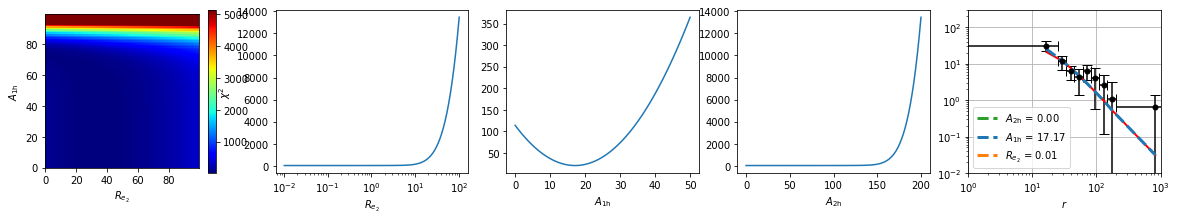

In [5]:
Re2_best_idx, A1h_best_idx, A2h_best_idx = np.where(chi2_arr==np.min(chi2_arr))
Re2_best, A1h_best, A2h_best = Re2_arr[Re2_best_idx], A1h_arr[A1h_best_idx], A2h_arr[A2h_best_idx]
print(Re2_best, A1h_best, A2h_best, np.min(chi2_arr))

fig, ax = plt.subplots(1,5,figsize=(20,3))
imageclip(chi2_arr[:,:,A2h_best_idx].reshape(chi2_arr.shape[0],chi2_arr.shape[1]), ax=ax[0])
ax[1].semilogx(Re2_arr, chi2_arr[:, A1h_best_idx, A2h_best_idx].flatten())
ax[2].plot(A1h_arr, chi2_arr[Re2_best_idx,:,A2h_best_idx].flatten())
ax[3].plot(A2h_arr, chi2_arr[:,A1h_best_idx,A2h_best_idx].flatten())

r_arr = param_fit.rsubbins
rbinedges = param_fit.rsubbinedges
profd_arr = param_fit.profex_sub
profd_err = np.sqrt(np.diag(param_fit.covsub))
modelprof = param_fit.get_profexcess_model(Re2=Re2_best, A1h=A1h_best, A2h=A2h_best, fast=True)
profex_arr = modelprof['profex_sub']
prof1h_arr = modelprof['prof1h_sub']
prof2h_arr = modelprof['prof2h_sub']
profm_arr = profex_arr + prof1h_arr + prof2h_arr
plot_err_log(r_arr, 
             profd_arr,
             profd_err,
             xedges = rbinedges,
             ax=ax[4], color='k')
ax[4].loglog(r_arr, profm_arr,'r-', lw=2)
ax[4].loglog(r_arr, prof2h_arr,'C2--', lw=3, label=r'$A_{\rm 2h}$ = %.2f'%A2h_best)
ax[4].loglog(r_arr, prof1h_arr,'C0--', lw=3, label=r'$A_{\rm 1h}$ = %.2f'%A1h_best)
ax[4].loglog(r_arr, profex_arr,'C1--', lw=3, label=r'$R_{e_2}$ = %.2f'%Re2_best)
ax[4].set_ylim([1e-2,3e2])
ax[4].set_xlim([1e0,1e3])
ax[4].grid()
ax[4].legend()
ax[0].set_xlabel(r'$R_{e_2}$')
ax[0].set_ylabel(r'$A_{\rm 1h}$')
ax[1].set_xlabel(r'$R_{e_2}$')
ax[1].set_ylabel(r'$\chi^2$')
ax[2].set_xlabel(r'$A_{\rm 1h}$')
ax[3].set_xlabel(r'$A_{\rm 2h}$')
ax[4].set_xlabel(r'$r$')

# plt.savefig('/Users/ytcheng/Desktop/grid.png', dpi = 100, bbox_inches='tight')

In [2]:
from run_fit import *
fit_stacking_mcmc(2, 6, 0, subsub=True, cov_method='bootstrap').run_mcmc()
# fit_stacking_mcmc(2,7,2,Mabs_min=-23, Mabs_max=-22, cov_method='bootstrap').run_mcmc(savename='mcmc_3par_BootesA_m18_19_Mabs-23_-22.npy')
# fit_stacking_mcmc(2,4,1,Mabs_min=-23, Mabs_max=-22, cov_method='bootstrap').run_mcmc(savename='mcmc_3par_elat10_m17_18_Mabs-23_-22.npy')

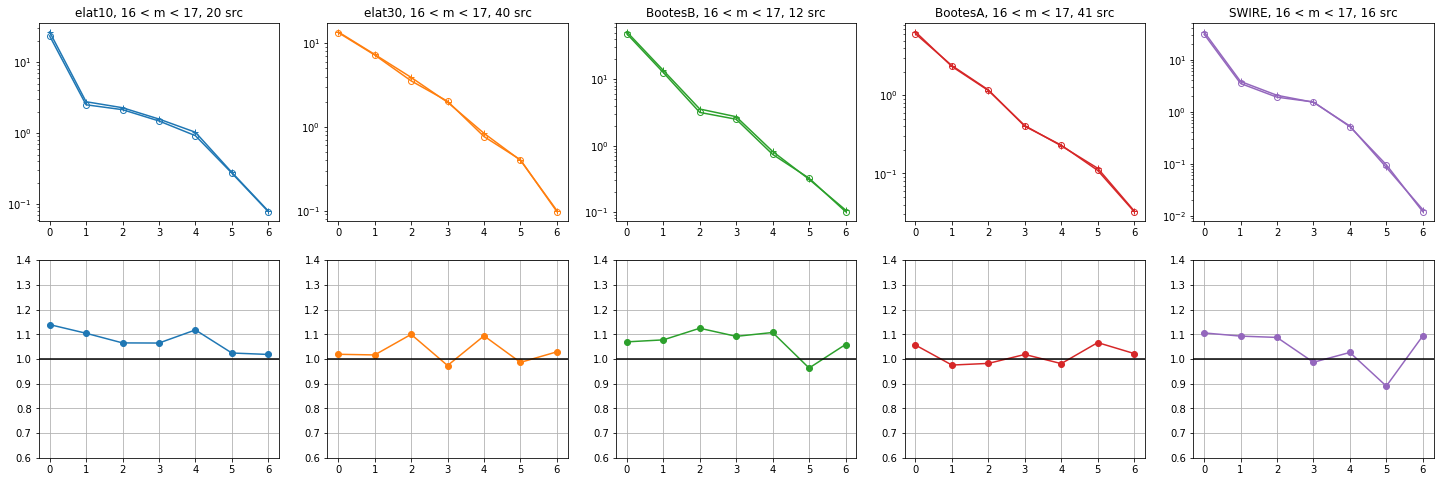

In [1]:
from stack import *
from run_fit import *

inst = 2
im = 0
m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
subsub = True if im==0 else False

fig, ax = plt.subplots(2,5,figsize=(25,8))
for i,ifield in enumerate([4,5,6,7,8]):
    stackdat = stacking(inst, ifield, m_min, m_max, load_from_file=True,
                        BGsub=False, subsub=subsub, cov_method='jackknife').stackdat
    covjack, covsubjack = stackdat['cov']['profcb'], stackdat['cov']['profcbsub']

    stackdat = stacking(inst, ifield, m_min, m_max, load_from_file=True,
                        BGsub=False, subsub=subsub, cov_method='bootstrap').stackdat
    covboot, covsubboot = stackdat['cov']['profcb'], stackdat['cov']['profcbsub']
    
    U, sb, VT = np.linalg.svd(covsubboot)
    ax[0][i].semilogy(sb,'o-',c='C'+str(ifield-4), fillstyle='none')
    U, sj, VT = np.linalg.svd(covsubjack)
    ax[0][i].semilogy(sj,'+-',c='C'+str(ifield-4))
    ax[0][i].set_title('%s, %d < m < %d, %d src'\
                       %(fieldnamedict[ifield],m_min, m_max, stackdat['Nsrc']))
    
    ax[1][i].plot(sj/sb,'o-', c='C'+str(ifield-4))
    ax[1][i].set_ylim([0.6,1.4])
    ax[1][i].axhline(1,c='k')
    ax[1][i].grid()

plt.savefig('/Users/ytcheng/Desktop/SVD_TM%d_m%d_%d_7bins.png'\
            %(inst,m_min,m_max), dpi = 150, bbox_inches='tight')

In [24]:
    
run_stacking(2,7,16,17, subsub=True, loaddir='/Users/ytcheng/Desktop/',savemaps=True)

# stackdat = run_stacking(2,6,16,17, subsub=True,loaddir='/Users/ytcheng/Desktop/',load_from_file=True)

stackdat = np.load('/Users/ytcheng/Desktop/stackdat_TM2_BootesB_16_17_filt5.npy',allow_pickle='TRUE').item()

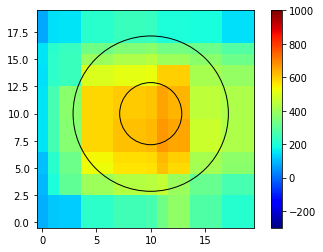

In [39]:
size=10
fig, ax = plt.subplots(1,1)
imageclip(stackdat['cbmapstack'][1200-size:1200+size,1200-size:1200+size],vmin=-300,vmax=1000,ax=ax)
draw_circle = plt.Circle((size, size), 50/7,fill=False)
ax.add_artist(draw_circle)
draw_circle = plt.Circle((size, size), 20/7,fill=False)
ax.add_artist(draw_circle)

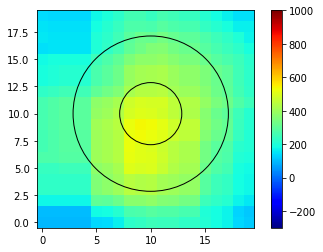

In [41]:
stackdat = np.load('/Users/ytcheng/Desktop/stackdat_TM2_BootesA_16_17_filt5.npy',allow_pickle='TRUE').item()
size=10
fig, ax = plt.subplots(1,1)
imageclip(stackdat['cbmapstack'][1200-size:1200+size,1200-size:1200+size],vmin=-300,vmax=1000,ax=ax)
draw_circle = plt.Circle((size, size), 50/7,fill=False)
ax.add_artist(draw_circle)
draw_circle = plt.Circle((size, size), 20/7,fill=False)
ax.add_artist(draw_circle)

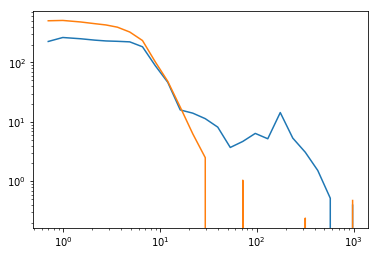

In [42]:
plt.loglog(stackdat['rbins'], stackdat['sub'][7]['profcb'])
plt.loglog(stackdat['rbins'], stackdat['profcb'])

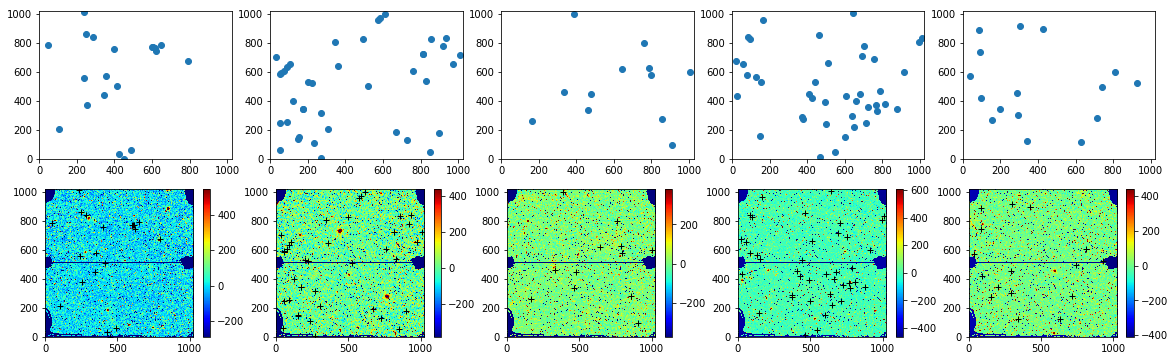

In [166]:
from reduction import *
# data_maps = {1: image_reduction(1), 2: image_reduction(2)}
inst = 2

fig, ax = plt.subplots(2,5,figsize=(20,6))
data = {}
for ifield in [4,5,6,7,8]:
    data[ifield] = {}
    
    cbmap, psmap, strmask, strnum, mask_inst1, mask_inst2 = \
    load_processed_images(data_maps, return_names=[(inst,ifield,'cbmap'), 
                                        (inst,ifield,'psmap'),
                                       (inst,ifield,'strmask'), 
                                       (inst,ifield,'strnum'),
                                       (1,ifield,'mask_inst'),
                                       (2,ifield,'mask_inst')])

    srcdat = ps_src_select(inst,ifield,16,17,[mask_inst1, mask_inst2], sample_type='all')
    mask_inst = mask_inst1 if inst==1 else mask_inst2
    
    data[ifield]['mavgs'] = np.array([])
    rs = get_mask_radius_th(ifield, srcdat['ms_arr'])
    for x, y, r, z in zip(srcdat['xg_arr'], srcdat['yg_arr'], rs, srcdat['zg_arr']):
        xc, yc = int(np.round(x)),int(np.round(y))
        radmap = make_radius_map(cbmap, xc, yc) # large pix units
        sp1 = np.where((radmap < r/7) & (strnum==1) & (mask_inst==1))

        mmap = cbmap * mask_inst * strmask
        mmap[sp1] = cbmap[sp1]
        sp = np.where((mmap!=0) & (radmap>50/7) & (radmap<100/7))
        mavg = np.mean(mmap[sp])
        data[ifield]['mavgs'] = np.concatenate((data[ifield]['mavgs'], mmap[sp]))
        
    ax[0][ifield-4].plot(srcdat['xg_arr'],srcdat['yg_arr'],'o')
    ax[0][ifield-4].set_xlim([0,1024])
    ax[0][ifield-4].set_ylim([0,1024])
    
    cbfilt = image_poly_filter(cbmap, strmask*mask_inst, degree=filt_order_dict[inst])
    ax[1][ifield-4].plot(srcdat['xg_arr'],srcdat['yg_arr'],'k+')
    imageclip(cbfilt, ax=ax[1][ifield-4])

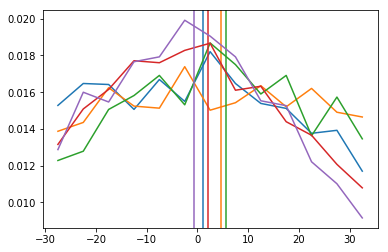

In [151]:
for ifield in [4,5,6,7,8]:
    binedges = np.arange(-30,40,5)
    bins = (binedges[1:]+binedges[:-1])/2
    h,_ = np.histogram(data[ifield]['mavgs'], bins=binedges,density=True)
    
    plt.plot(bins, h, c='C'+str(ifield-4))
    plt.axvline(np.mean(data[ifield]['mavgs']),c='C'+str(ifield-4))

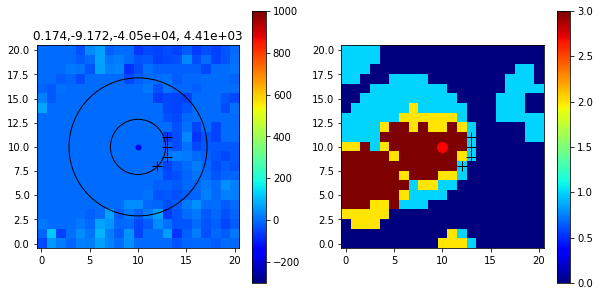

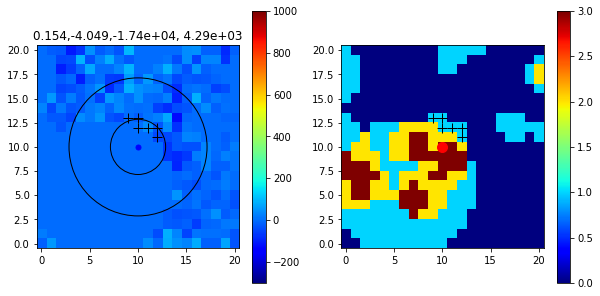

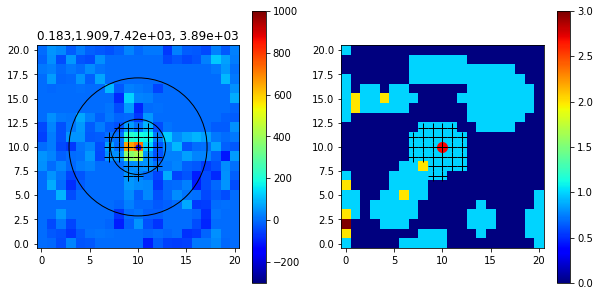

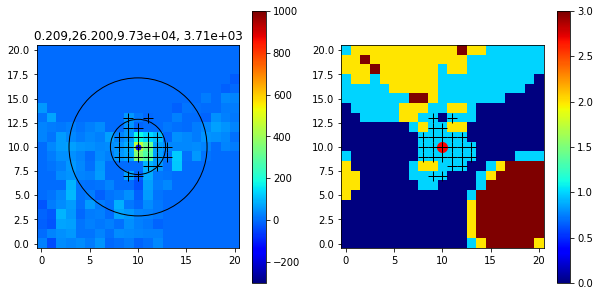

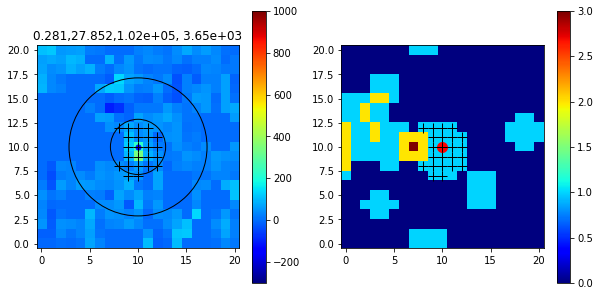

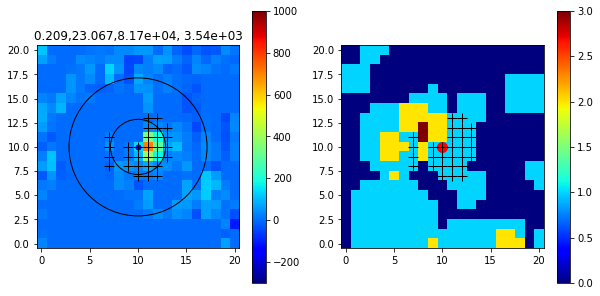

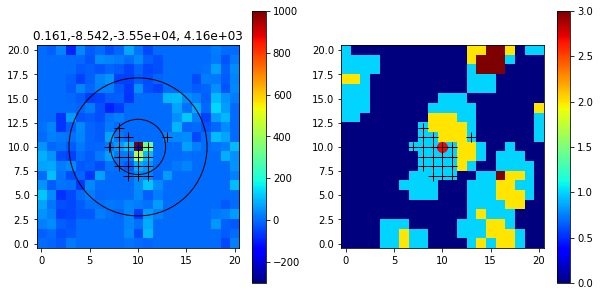

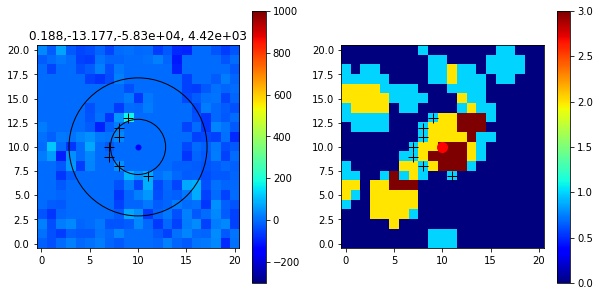

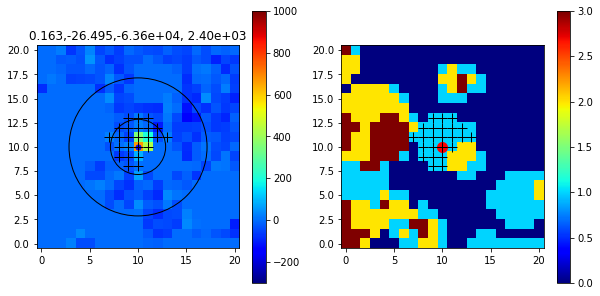

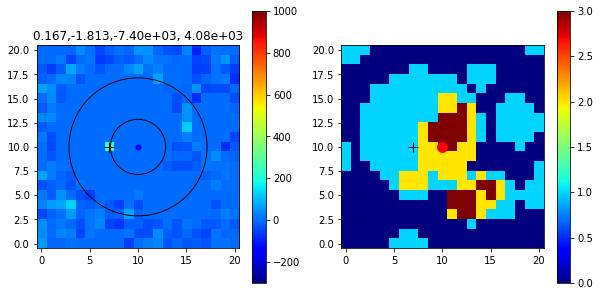

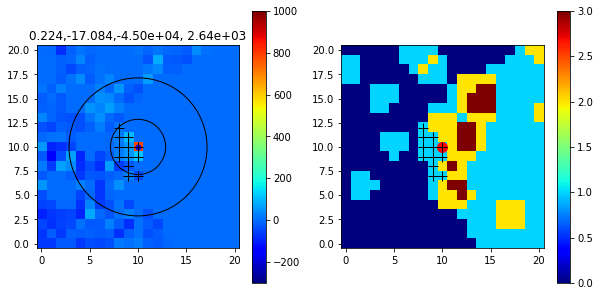

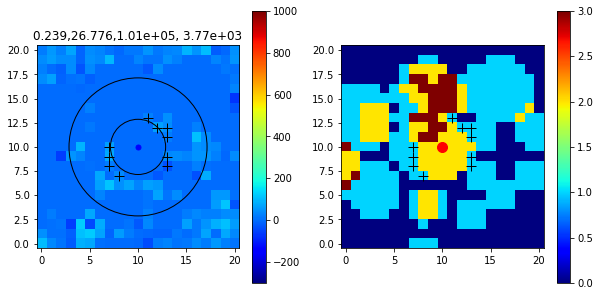

In [155]:
from reduction import *
# data_maps = {1: image_reduction(1), 2: image_reduction(2)}
inst = 2
ifield = 6
cbmap, psmap, strmask, strnum, mask_inst1, mask_inst2 = \
load_processed_images(data_maps, return_names=[(inst,ifield,'cbmap'), 
                                    (inst,ifield,'psmap'),
                                   (inst,ifield,'strmask'), 
                                   (inst,ifield,'strnum'),
                                   (1,ifield,'mask_inst'),
                                   (2,ifield,'mask_inst')])

srcdat = ps_src_select(inst,ifield,16,17,[mask_inst1, mask_inst2], sample_type='all')
mask_inst = mask_inst1 if inst==1 else mask_inst2


rs = get_mask_radius_th(ifield, srcdat['ms_arr'])
for x, y, r, z in zip(srcdat['xg_arr'], srcdat['yg_arr'], rs, srcdat['zg_arr']):
    xc, yc = int(np.round(x)),int(np.round(y))
    radmap = make_radius_map(cbmap, xc, yc) # large pix units
    sp1 = np.where((radmap < r/7) & (strnum==1) & (mask_inst==1))
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    mmap = cbmap * mask_inst * strmask
    mmap[sp1] = cbmap[sp1]
    sp = np.where((mmap!=0) & (radmap>20) & (radmap<50))
    mavg = np.mean(mmap[sp])
    mavghit = mavg * len(sp[0])
    imageclip(mmap[xc-10:xc+11,yc-10:yc+11], vmin=-300,vmax=1000, ax=ax[0])
    ax[0].plot([10],[10],'bo',markersize=5)
    draw_circle = plt.Circle((10, 10), 50/7,fill=False)
    ax[0].add_artist(draw_circle)
    draw_circle = plt.Circle((10, 10), 20/7,fill=False)
    ax[0].add_artist(draw_circle)
    ax[0].set_title('%.3f,%.3f,%.2e, %.2e'%(z,mavg,mavghit, mavghit/mavg))
    imageclip(strnum[xc-10:xc+11,yc-10:yc+11], ax=ax[1], vmin=0, vmax=3)
    ax[1].plot([10],[10],'ro',markersize=10)
    ax[0].plot(sp1[1]-yc+10,sp1[0]-xc+10,'k+',markersize=10)
    ax[1].plot(sp1[1]-yc+10,sp1[0]-xc+10,'k+',markersize=10)

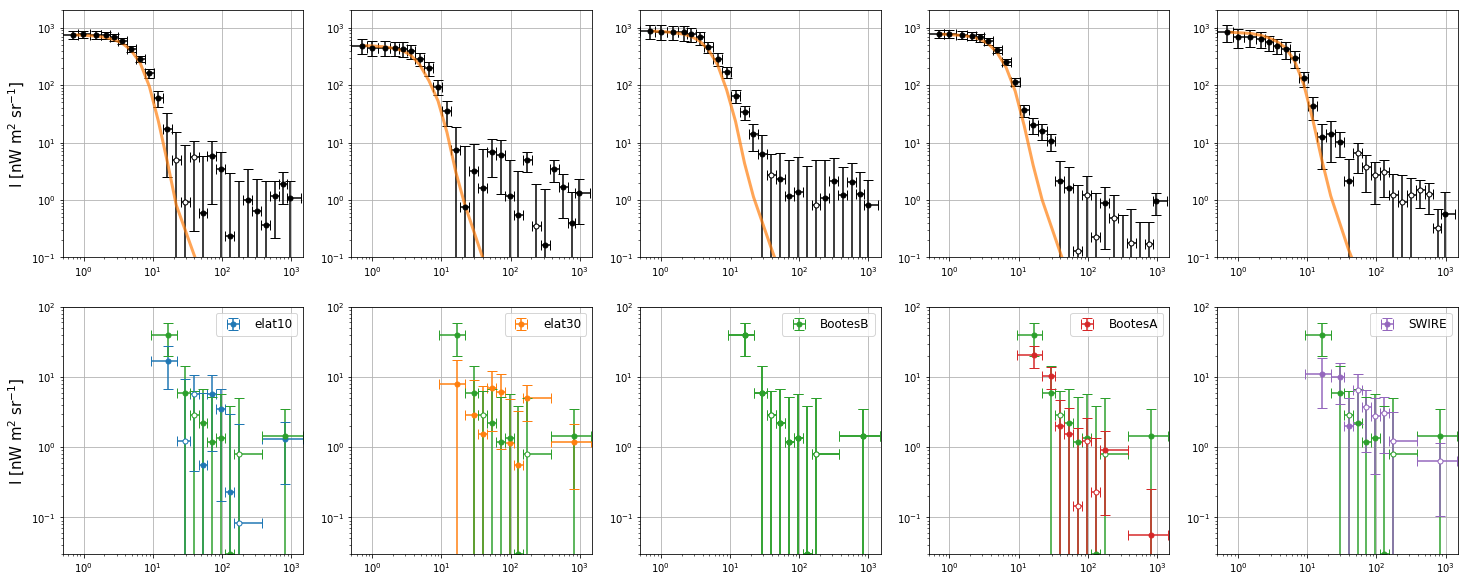

In [30]:
fig, ax = plt.subplots(2, 5, figsize=(25,10))
inst = 1
m_min, m_max = 16,17
subsub = True if m_min==16 else False
for ifield in [4,5,6,7,8]:
    stackdat = stacking(inst, ifield, m_min, m_max,
            load_from_file=True, BGsub=False, subsub=subsub).stackdat
    
    plot_err_log(stackdat['rbins'], 
                 stackdat['profcb'],
                 np.sqrt(np.diag(stackdat['cov']['profcb'])),
                 ax=ax[0][ifield-4], color='k',
                 label= r'$\Sigma_{\rm stack}$ (%d galaxies)'% stackdat['Nsrc'])
    ax[0][ifield-4].loglog(stackdat['rbins'],stackdat['PSF']['profcb'],
                  'C1', alpha=0.7, lw=3, label=r'$PSF_{\rm stack}$')
    ax[0][ifield-4].set_ylim([1e-1,2e3])
    ax[0][ifield-4].set_xlim([5e-1,1.5e3])
    ax[0][ifield-4].grid()    
    ax[0][0].set_ylabel('I [nW m$^2$ sr$^{-1}$]', fontsize=15)

    plot_err_log(stackdat['rsubbins'], 
                 stackdat['ex']['profcbsub'],
                 np.sqrt(np.diag(stackdat['excov']['profcbsub'])),
                 ax=ax[1][ifield-4], color='C'+str(ifield-4),
                 label=fieldnamedict[ifield])

    if ifield==6:
        for i in range(5):
            plot_err_log(stackdat['rsubbins'], 
                         stackdat['ex']['profcbsub'],
                         np.sqrt(np.diag(stackdat['excov']['profcbsub'])),
                         ax=ax[1][i], color='C'+str(ifield-4))

    ax[1][ifield-4].set_ylim([3e-2,1e2])
    ax[1][ifield-4].set_xlim([5e-1,1.5e3])
    ax[1][0].set_ylabel('I [nW m$^2$ sr$^{-1}$]', fontsize=15)
    ax[1][ifield-4].grid()    
    ax[1][ifield-4].legend(fontsize=12)
    
plt.savefig('/Users/ytcheng/Desktop/profiles_TM%d_m%d_%d.png'%(inst, m_min,m_max),
            dpi = 150, bbox_inches='tight')

***
# NYU-VAGC

only ~ 200 gal per CIBER field has successful SED fit, so it's not very useful

In [416]:
from astropy.table import Table

hdu_list= fits.open(mypaths['ciberdir'] + 'doc/20170617_Stacking/maps/NYU_VAGC/' + \
                    'kcorrect.none.model.z0.00.fits')
df = Table(hdu_list[1].data)

In [ ]:
ifield = 7
m_min, m_max = 18,19
mask_inst1, mask_inst2 = load_processed_images(data_maps,
                      return_names=[(1,ifield,'mask_inst'),(2,ifield,'mask_inst')])
field = fieldnamedict[ifield]
srcdat = ps_src_select(1, ifield, m_min, m_max, 
    [mask_inst1, mask_inst2], sample_type='all')

df0 = pd.read_csv(mypaths['PScatdat'] + fieldnamedict[ifield] + '.csv')
df0 = df0.iloc[srcdat['idxg_arr']]

In [582]:
sp = np.where((df['RA']>=241.0) & (df['RA']<244.7) & (df['DEC']>=53.6) & (df['DEC']<55.9))[0]
df = df[sp]

# catalogk = (np.stack([np.array(df['RA']),np.array(df['DEC'])]).T * np.pi/180).tolist()
# psk = [[item[0], item[1]] for item in catalogk]
# catalogp = (df0[['ra','dec']].values * np.pi/180).tolist()
# psp = [[item[0], item[1]] for item in catalogp]
# kdt = cKDTree(psk)
# obj = kdt.query_ball_point(psp, (0.7 * u.arcsec).to(u.rad).value)
# Nmatch = np.array([len(obj_i) for obj_i in obj])
# np.sum(Nmatch)/len(Nmatch)

In [583]:
len(np.where(df['MASS']!=0)[0])

215

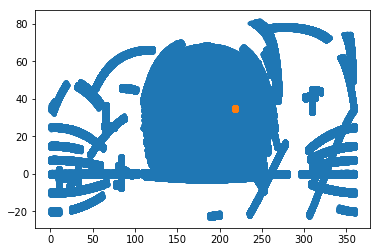

In [559]:
plt.plot(df['RA'],df['DEC'],'.')
plt.plot(df0['ra'],df0['dec'],'.')

In [551]:
i=0
dsq = (ra - df0.iloc[i]['ra'])**2 + (dec - df0.iloc[i]['dec'])**2
df[np.argmin(dsq)]

RA,DEC,ABMAGGIES [8],ABMAGGIES_IVAR [8],Z,ABSMAG [8],ABSMAG_IVAR [8],KCORRECT [8],MTOL [8],MASS,INTSFH,METS,B300,B1000,COEFFS [5]
float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
242.94944465760423,55.306714065837966,6.338634e-09 .. 0.0,8.846317e+17 .. 0.0,-1.0,26505.953 .. 26501.45,30.151243 .. 0.0,0.0 .. 0.0,7.124352 .. 0.22208786,0.0,0.0,0.039702233,1.2442564e-07,0.4030629,1.078997e-05 .. 3.756278e-12


***
# Trials on Source Binning

In [2]:
from stack_ancillary import *
from run_fit import *
# from reduction import *
# data_maps = {1: image_reduction(1), 2: image_reduction(2)}

srcdict = {}
m_data = (np.array(magbindict['m_min']) + np.array(magbindict['m_max'])) / 2
Re2_data1 = np.zeros_like(m_data)
Re2_data2 = np.zeros_like(m_data)
for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
    subsub = True if im==0 else False
    fitparamdat = get_mcmc_fit_params_3par(1,im, ifield=None, subsub=subsub)
    Re2_data1[im] = fitparamdat['Re2']
    fitparamdat = get_mcmc_fit_params_3par(2,im, ifield=None, subsub=subsub)
    Re2_data2[im] = fitparamdat['Re2']
Re2_interp_func1 = scipy.interpolate.interp1d(m_data, Re2_data1, fill_value='extrapolate')
Re2_interp_func2 = scipy.interpolate.interp1d(m_data, Re2_data2, fill_value='extrapolate')
srcdict = {'m_data':m_data, 'Re2_data1':Re2_data1, 'Re2_data2':Re2_data2,
          'Re2_interp_func1':Re2_interp_func1, 'Re2_interp_func2':Re2_interp_func2}
    
for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
    srcdict[im] = {'z':np.array([]), 'm':np.array([])}
    for i,ifield in enumerate([4,5,6,7,8]):
        mask_inst1, mask_inst2 = load_processed_images(data_maps,
                              return_names=[(1,ifield,'mask_inst'),(2,ifield,'mask_inst')])
        field = fieldnamedict[ifield]
        srcdat = ps_src_select(1, ifield, m_min, m_max, 
            [mask_inst1, mask_inst2], sample_type='all')
        srcdict[im]['z'] = np.concatenate((srcdict[im]['z'],np.array(srcdat['zg_arr'])))
        srcdict[im]['m'] = np.concatenate((srcdict[im]['m'],np.array(srcdat['mg_arr'])))
        
    DA_Mpc = cosmo.angular_diameter_distance(srcdict[im]['z']).value
    srcdict[im]['kpc_per_arcsec'] = DA_Mpc * (u.Mpc/u.rad).to(u.kpc/u.arcsec)
    srcdict[im]['Re2_arcsec1'] = srcdict['Re2_interp_func1'](srcdict[im]['m'])
    srcdict[im]['Re2_kpc1'] = srcdict[im]['Re2_arcsec1'] srcdict[im]['kpc_per_arcsec']
    srcdict[im]['Re2_arcsec2'] = srcdict['Re2_interp_func2'](srcdict[im]['m'])
    srcdict[im]['Re2_kpc2'] = srcdict[im]['Re2_arcsec2'] srcdict[im]['kpc_per_arcsec']

    zs = srcdict[im]['z']
    ms = srcdict[im]['m']
    DM = 5 * np.log10((cosmo.luminosity_distance(zs) / (10 * u.pc)).decompose()).value
    Ms = ms - DM + (2.5 * np.log10(1+zs))
    srcdict[im]['M'] = ms - DM + (2.5 * np.log10(1+zs))

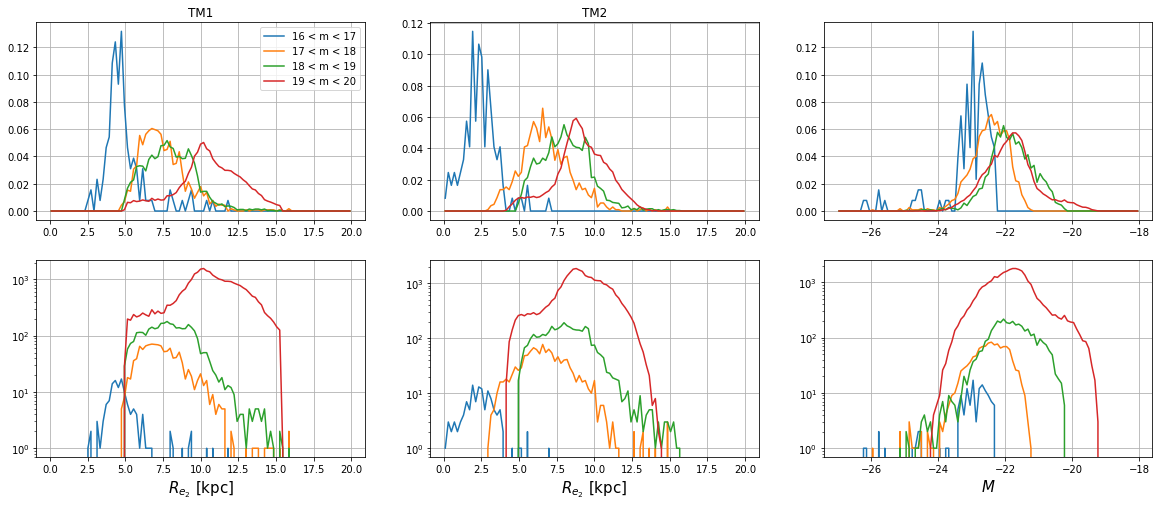

In [3]:
fig, ax = plt.subplots(2,3, figsize=(20,8))
Rbinedges = np.linspace(0,20,100)
Rbins = (Rbinedges[1:] + Rbinedges[:-1])/2
Mbinedges = np.linspace(-27,-18,100)
Mbins = (Mbinedges[1:] + Mbinedges[:-1])/2
for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
    hist = np.histogram(srcdict[im]['Re2_kpc1'], bins=Rbinedges)[0]
    ax[0][0].plot(Rbins, hist/np.sum(hist),label='%d < m < %d'%(m_min, m_max))
    ax[1][0].semilogy(Rbins, hist,label='%d < m < %d'%(m_min, m_max))
    hist = np.histogram(srcdict[im]['Re2_kpc2'], bins=Rbinedges)[0]
    ax[0][1].plot(Rbins, hist/np.sum(hist),label='%d < m < %d'%(m_min, m_max))
    ax[1][1].semilogy(Rbins, hist,label='%d < m < %d'%(m_min, m_max))
    hist = np.histogram(srcdict[im]['M'], bins=Mbinedges)[0]
    ax[0][2].plot(Mbins, hist/np.sum(hist))    
    ax[1][2].semilogy(Mbins, hist)    

ax[0][0].legend()
ax[0][0].set_title('TM1')
ax[0][0].grid()
ax[0][1].set_title('TM2')
ax[0][1].grid()
ax[0][2].grid()

ax[1][0].set_xlabel(r"$R_{e_2}$ [kpc]",fontsize=15)
ax[1][0].grid()
ax[1][1].set_xlabel(r"$R_{e_2}$ [kpc]",fontsize=15)
ax[1][1].grid()
ax[1][2].set_xlabel(r"$M$",fontsize=15)
ax[1][2].grid()
plt.savefig('/Users/ytcheng/Desktop/Re2_M_hist.png', dpi = 150)

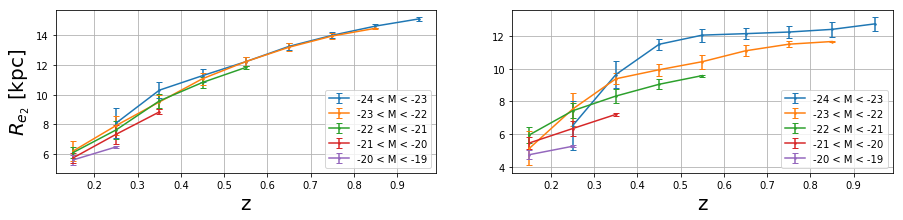

In [288]:
fig, ax = plt.subplots(1,2, figsize=(15,3))

zs = np.concatenate((srcdict[1]['z'],srcdict[2]['z'],srcdict[3]['z']))
Re2s1 = np.concatenate((srcdict[1]['Re2_kpc1'],srcdict[2]['Re2_kpc1'],srcdict[3]['Re2_kpc1']))
Re2s2 = np.concatenate((srcdict[1]['Re2_kpc2'],srcdict[2]['Re2_kpc2'],srcdict[3]['Re2_kpc2']))
ms = np.concatenate((srcdict[1]['m'],srcdict[2]['m'],srcdict[3]['m']))
Ms = np.concatenate((srcdict[1]['M'],srcdict[2]['M'],srcdict[3]['M']))

Msbinedges = np.arange(-24,-18,1)
Msbins = (Msbinedges[1:] + Msbinedges[:-1])/2
zbinedges = np.arange(0,1.1,0.1)
zbins = (zbinedges[1:] + zbinedges[:-1])/2
for i,(Ms_min, Ms_max) in enumerate(zip(Msbinedges[:-1], Msbinedges[1:])):
    sp = np.where((Ms>=Ms_min) & (Ms<Ms_max))[0]
    if len(sp)==0:
        continue
    zi, Re21i, Re22i = zs[sp], Re2s1[sp], Re2s2[sp]
    Re21_arr = []
    Re22_arr = []
    Re21_err = []
    Re22_err = []
    z_arr = []
    for iz,(z_min,z_max) in enumerate(zip(zbinedges[:-1], zbinedges[1:])):
        spz = np.where((zi>=z_min) & (zi<z_max))[0]
        if len(spz)==0:
            continue
        z_arr.append(zbins[iz])
        Re21_arr.append(np.mean(Re21i[spz]))
        Re22_arr.append(np.mean(Re22i[spz]))
        Re21_err.append(np.std(Re21i[spz]))
        Re22_err.append(np.std(Re22i[spz]))
    ax[0].errorbar(z_arr, Re21_arr,Re21_err, fmt ='.-', 
                   capsize=3,markersize=3, label='%d < M < %d'%(Ms_min, Ms_max))
    ax[1].errorbar(z_arr, Re22_arr,Re22_err, fmt ='.-', 
                   capsize=3,markersize=3, label='%d < M < %d'%(Ms_min, Ms_max))
ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()
ax[0].set_xlabel('z',fontsize=20)
ax[1].set_xlabel('z',fontsize=20)
ax[0].set_ylabel(r"$R_{e_2}$ [kpc]",fontsize=20)
plt.savefig('/Users/ytcheng/Desktop/Re2_z.png', dpi = 150)

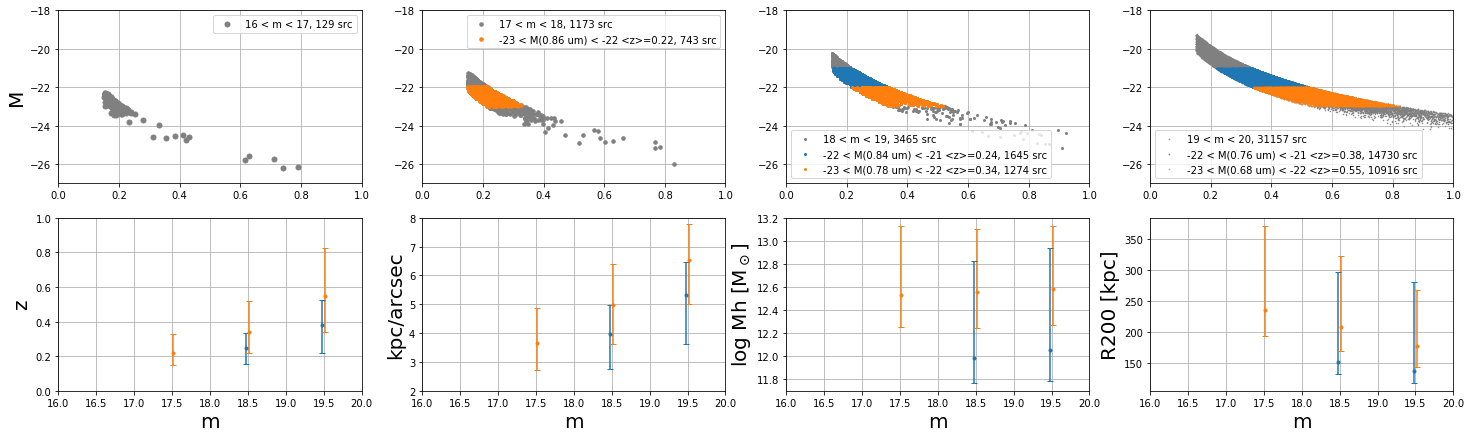

In [104]:
# from micecat import *
# icat = 0
# df = get_micecat_df(icat)
# DM = 5 * np.log10((cosmo.luminosity_distance(df['z_cgal']) / (10 * u.pc)).decompose()).value
# df['M_I'] = df['I'] - DM + (2.5 * np.log10(1+df['z_cgal']))
# rhoc_arr = np.array(cosmo.critical_density(df['z_cgal']).to(u.M_sun / u.Mpc**3))
# Rvir = ((3 * (10**df['lmhalo'])) / (4 * np.pi * 200 * rhoc_arr))**(1./3) # Mpc comoving
# df['Rvir'] = Rvir * 1e3  / (1+df['z_cgal']) # kpc physical

Msbinedges = np.arange(-21,-24,-1)
fig, ax = plt.subplots(2,4, figsize=(25,7))
for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
    zs = srcdict[im]['z']
    kpc_per_arcsecs = srcdict[im]['kpc_per_arcsec'] 
    Re2s1s = srcdict[im]['Re2_kpc1']
    Re2s2s = srcdict[im]['Re2_kpc2']
    ms = srcdict[im]['m']
    Ms = srcdict[im]['M']
    
    ax[0][im].plot(zs, Ms,'.',markersize=10 - 3*im, c='grey',
                   label='%d < m < %d, %d src'%(m_min,m_max,len(zs)))
    for i,(Ms_min,Ms_max) in enumerate(zip(Msbinedges[1:],Msbinedges[:-1])):
        xoff = 0.999 + i*0.002
        sp = np.where((Ms>=Ms_min) & (Ms<Ms_max))[0]
        if im == 0:
            continue
        if im==1 and Ms_min==-22:
            continue
            
        dfi = df.loc[(df['I']>=m_min) & (df['I']<m_max) & (df['M_I']>=Ms_min) & (df['M_I']<Ms_max)]
        
        zavg = np.mean(zs[sp])
        kpc_per_arcsecavg = np.mean(kpc_per_arcsecs[sp])
        N = len(sp)
        wl_rest = band_info(1).wl / (1+zavg)        
        ax[0][im].plot(zs[sp], Ms[sp], '.',markersize=10 - 3*im, c='C'+str(i),
                       label='%d < M(%.2f um) < %d <z>=%.2f, %d src'%(Ms_min,wl_rest, Ms_max,zavg,N))
        ax[1][0].errorbar((m_min+m_max)/2*xoff,[zavg],
                           np.array([[zavg-np.min(zs[sp]),np.max(zs[sp])-zavg]]).T,
                          c='C'+str(i), fmt='.',capsize=3)
        ax[1][1].errorbar((m_min+m_max)/2*xoff,[kpc_per_arcsecavg],
                           np.array([[kpc_per_arcsecavg-np.min(kpc_per_arcsecs[sp]),
                                           np.max(kpc_per_arcsecs[sp])-kpc_per_arcsecavg]]).T,
                          c='C'+str(i), fmt='.',capsize=3)
        ax[1][2].errorbar((m_min+m_max)/2*xoff,[np.median(dfi['lmhalo'])],
                           np.array([[np.median(dfi['lmhalo'])-np.percentile(dfi['lmhalo'],16),
                                           np.percentile(dfi['lmhalo'],84)-np.median(dfi['lmhalo'])]]).T,
                          c='C'+str(i), fmt='.',capsize=3)
        ax[1][3].errorbar((m_min+m_max)/2*xoff,[np.median(dfi['Rvir'])],
                           np.array([[np.median(dfi['Rvir'])-np.percentile(dfi['Rvir'],16),
                                           np.percentile(dfi['Rvir'],84)-np.median(dfi['Rvir'])]]).T,
                          c='C'+str(i), fmt='.',capsize=3)

    ax[1][im].set_xlim([16,20])
    ax[0][im].set_xlim([0,1])
    ax[0][im].set_ylim([-27,-18])
    ax[0][im].grid()
    ax[0][im].legend()
    
ax[1][0].set_ylim([0,1])
ax[1][1].set_ylim([2,8])
ax[1][0].grid()
ax[1][1].grid()
ax[1][2].grid()
ax[1][3].grid()
ax[1][0].set_ylabel('z',fontsize=20)
ax[1][1].set_ylabel('kpc/arcsec',fontsize=20)
ax[1][2].set_ylabel(r'log Mh [M$_\odot$]',fontsize=20)
ax[1][3].set_ylabel('R200 [kpc]',fontsize=20)
ax[0][0].set_ylabel('M',fontsize=20)
ax[1][0].set_xlabel('m',fontsize=20)
ax[1][1].set_xlabel('m',fontsize=20)
ax[1][2].set_xlabel('m',fontsize=20)
ax[1][3].set_xlabel('m',fontsize=20)
plt.savefig('/Users/ytcheng/Desktop/Mbins.png', dpi = 150)

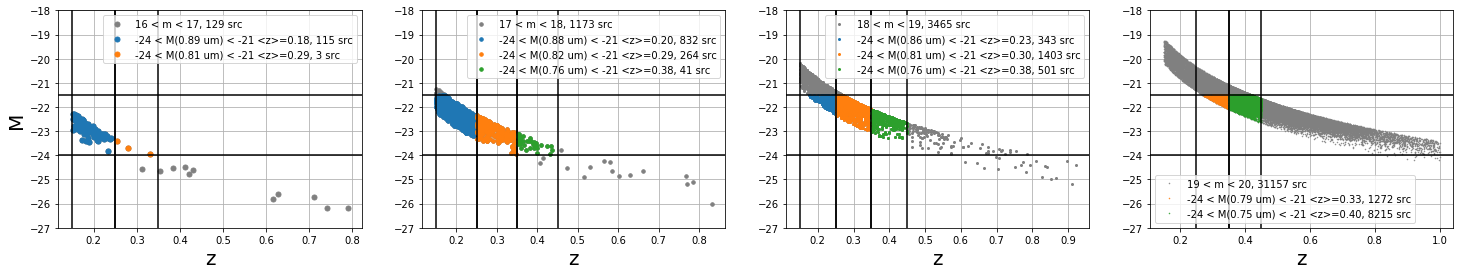

In [8]:
Ms_min, Ms_max = -24, -21.5
zbinedges = np.arange(0.15,0.55,0.1)
fig, ax = plt.subplots(1,4, figsize=(25,4))
for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
    zs = srcdict[im]['z']
    kpc_per_arcsecs = 1/cosmo.arcsec_per_kpc_proper(zs).value
    Re2s1s = srcdict[im]['Re2_kpc1']
    Re2s2s = srcdict[im]['Re2_kpc2']
    ms = srcdict[im]['m']
    Ms = srcdict[im]['M']
    
    ax[im].plot(zs, Ms,'.',markersize=10 - 3*im, c='grey',
                   label='%d < m < %d, %d src'%(m_min,m_max,len(zs)))
                   
    for i,(z_min,z_max) in enumerate(zip(zbinedges[:-1],zbinedges[1:])):
        sp = np.where((zs>=z_min) & (zs<z_max) & (Ms>=Ms_min) & (Ms<Ms_max))[0]
        if len(sp)==0:
            continue  
        zavg = np.mean(zs[sp])
        kpc_per_arcsecavg = np.mean(kpc_per_arcsecs[sp])
        N = len(sp)
        wl_rest = band_info(1).wl / (1+zavg)        
        ax[im].plot(zs[sp], Ms[sp], '.',markersize=10 - 3*im, c='C'+str(i),
                       label='%d < M(%.2f um) < %d <z>=%.2f, %d src'%(Ms_min,wl_rest, Ms_max,zavg,N))
        ax[im].axvline(z_min,c='k')
        ax[im].axvline(z_max,c='k')
    ax[im].axhline(Ms_min,c='k')
    ax[im].axhline(Ms_max,c='k')
    ax[im].set_ylim([-27,-18])
    ax[im].set_xlabel('z',fontsize=20)
    ax[im].grid()
    ax[im].legend()
ax[0].set_ylabel('M',fontsize=20)
plt.savefig('/Users/ytcheng/Desktop/Mbins.png', dpi = 150)

/Users/ytcheng/ciber/python_ciber/stack_modelfit/utils.py:187: RuntimeWarning: overflow encountered in power
  I_arr = (10**Ie) * np.exp(-bn*((x_arr/xe)**(1/n)-1))


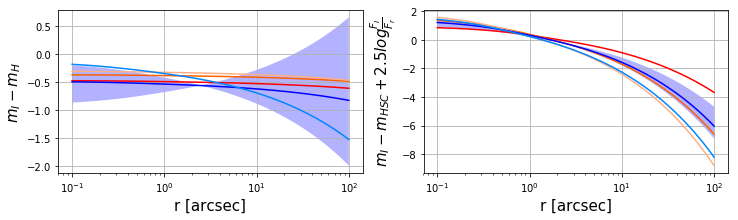

In [93]:
fig, ax = plt.subplots(1,2,figsize=(12,3))

r_arr = np.logspace(-1,2,100)
for i,(im,M_min,M_max,c) in enumerate(zip([1,2,3,2,3],[-23,-23,-23,-22,-22],[-22,-22,-22,-21,-21],
                                         ['#ff0000','#ff5f00','#ffaf87','#0000ff','#0087ff'])):
    m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]

    p_HSC = gal_profile_model().Wang19_profile(r_arr, im)['I_arr']
    p_HSC3 = gal_profile_model().Wang19_profile(r_arr, im, extendedness=True)['I_arr']
    
    W19params = gal_profile_model().Wang19_params(im,extendedness=False)
    xe2 = np.max((W19params['sersic2'][2]-W19params['sersic2_err'][2]))
    p_low_HSC = gal_profile_model().Wang19_profile(r_arr, im, xe2=xe2)['I_arr']
    W19params = gal_profile_model().Wang19_params(im,extendedness=True)
    xe2 = np.max((W19params['sersic2'][2]-W19params['sersic2_err'][2]))
    xe3 = np.max((W19params['sersic3'][2]-W19params['sersic3_err'][2]))
    p_low_HSC3 = gal_profile_model().Wang19_profile(r_arr, im, 
                                                         extendedness=True, xe2=xe2, xe3=xe3)['I_arr']

    W19params = gal_profile_model().Wang19_params(im,extendedness=False)
    xe2 = W19params['sersic2'][2]+W19params['sersic2_err'][2]
    p_high_HSC = gal_profile_model().Wang19_profile(r_arr, im, xe2=xe2)['I_arr']
    W19params = gal_profile_model().Wang19_params(im,extendedness=True)
    xe2 = W19params['sersic2'][2]+W19params['sersic2_err'][2]
    xe3 = W19params['sersic3'][2]+W19params['sersic3_err'][2]
    p_high_HSC3 = gal_profile_model().Wang19_profile(r_arr, im, 
                                                         extendedness=True, xe2=xe2, xe3=xe3)['I_arr']
    
    savename='mcmc_3par_joint_m%d_%d_Mabs%d_%d.npy'%(m_min,m_max,M_min,M_max)
    fitparamdat = get_mcmc_fit_params_3par(1,im, ifield=None,savename=savename)
    p1 = gal_profile_model().Wang19_profile(r_arr, im, Re2=fitparamdat['Re2'])['I_arr']
    p1_high = gal_profile_model().Wang19_profile(r_arr, im, Re2=fitparamdat['Re2_high'])['I_arr']
    p1_low = gal_profile_model().Wang19_profile(r_arr, im, Re2=fitparamdat['Re2_low'])['I_arr']
    prof_avg, prof_avg_w = 0,0
    for ifield in [4,5,6,7,8]:
        stackdat = stacking(1, ifield, m_min, m_max, 
                            Mabs_min=M_min, Mabs_max=M_max,
                    load_from_file=True, BGsub=False, subsub=False).stackdat
        prof_avg += stackdat['profcb'] / np.diag(stackdat['cov']['profcb'])
        prof_avg_w += 1 / np.diag(stackdat['cov']['profcb'])
    prof_avg1 = prof_avg / prof_avg_w

    savename='mcmc_3par_joint_m%d_%d_Mabs%d_%d.npy'%(m_min,m_max,M_min,M_max)
    fitparamdat = get_mcmc_fit_params_3par(2,im, ifield=None,savename=savename)
    p2 = gal_profile_model().Wang19_profile(r_arr, im, Re2=fitparamdat['Re2'])['I_arr']
    p2_high = gal_profile_model().Wang19_profile(r_arr, im, Re2=fitparamdat['Re2_high'])['I_arr']
    p2_low = gal_profile_model().Wang19_profile(r_arr, im, Re2=fitparamdat['Re2_low'])['I_arr']
    prof_avg, prof_avg_w = 0,0
    for ifield in [4,5,6,7,8]:
        stackdat = stacking(2, ifield, m_min, m_max, 
                            Mabs_min=M_min, Mabs_max=M_max,
                    load_from_file=True, BGsub=False, subsub=False).stackdat
        prof_avg += stackdat['profcb'] / np.diag(stackdat['cov']['profcb'])
        prof_avg_w += 1 / np.diag(stackdat['cov']['profcb'])
    prof_avg2 = prof_avg / prof_avg_w

    Fr = np.mean(prof_avg1[:3]/prof_avg2[:3])
    pr = (p1/np.sum(p1*r_arr**2))/(p2/np.sum(p2*r_arr**2))
    pr_low = (p1_low/np.sum(p1_low*r_arr**2))/(p2_high/np.sum(p2_high*r_arr**2))
    pr_high = (p1_high/np.sum(p1_high*r_arr**2))/(p2_low/np.sum(p2_low*r_arr**2))
    ax[0].semilogx(r_arr, -2.5*np.log10(pr*Fr),c=c)
    if i==3:
        ax[0].fill_between(r_arr, -2.5*np.log10(pr_low*Fr), -2.5*np.log10(pr_high*Fr),
                        facecolor=c, alpha=0.3)


    pr = (p1/np.sum(p1*r_arr**2))/(p_HSC/np.sum(p_HSC*r_arr**2))
    pr_low = (p1_low/np.sum(p1_low*r_arr**2))/(p_high_HSC/np.sum(p_high_HSC*r_arr**2))
    pr_high = (p1_high/np.sum(p1_high*r_arr**2))/(p_low_HSC/np.sum(p_low_HSC*r_arr**2))
    ax[1].semilogx(r_arr, -2.5*np.log10(pr),c=c)
    if i==3:
        ax[1].fill_between(r_arr, -2.5*np.log10(pr_low), -2.5*np.log10(pr_high),
                    facecolor=c, alpha=0.3)

ax[0].set_xlabel('r [arcsec]',fontsize=15)
ax[1].set_xlabel('r [arcsec]',fontsize=15)
ax[0].set_ylabel('$m_I-m_H$',fontsize=15)
ax[1].set_ylabel(r'$m_I-m_{HSC} + 2.5log\frac{F_I}{F_r}$',fontsize=15)
ax[0].grid()
ax[1].grid()
plt.savefig('/Users/ytcheng/Desktop/color.png',
            dpi = 150, bbox_inches='tight')

/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in true_divide
/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in true_divide
/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in true_divide
/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in log10


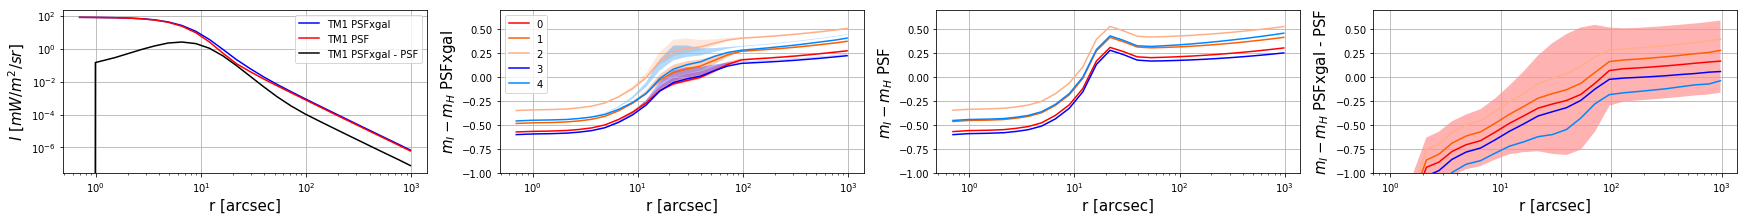

In [56]:
fig, ax = plt.subplots(1,4,figsize=(30,3))
for i,(im,M_min,M_max,c) in enumerate(zip([1,2,3,2,3],[-23,-23,-23,-22,-22],
                                          [-22,-22,-22,-21,-21],
                                         ['#ff0000','#ff5f00','#ffaf87','#0000ff','#0087ff'])):
    
    if i==4:
        ax[0].loglog(data['rbins'], data[i]['profgal_arr1'],'b',label='TM1 PSFxgal')
        ax[0].loglog(data['rbins'], data[i]['profpsf_arr1'],'r',label='TM1 PSF')
        ax[0].loglog(data['rbins'], data[i]['profex1'],'k',label='TM1 PSFxgal - PSF')
     
    ax[1].semilogx(data['rbins'], 
                   -2.5*np.log10(data[i]['profgal_arr1']/data[i]['profgal_arr2']),c=c,label=i)
    ax[1].fill_between(data['rbins'], 
                       -2.5*np.log10(data[i]['profgal_arr1_low']/data[i]['profgal_arr2_low']),
                       -2.5*np.log10(data[i]['profgal_arr1_high']/data[i]['profgal_arr2_high']),
                        facecolor=c, alpha=0.3)

    ax[2].semilogx(data['rbins'], -2.5*np.log10(data[i]['profpsf_arr1']/data[i]['profpsf_arr2']),c=c)
    ax[2].fill_between(data['rbins'], 
                       -2.5*np.log10(data[i]['profpsf_arr1_low']/data[i]['profpsf_arr2_high']),
                       -2.5*np.log10(data[i]['profpsf_arr1_high']/data[i]['profpsf_arr2_low']),
                        facecolor=c, alpha=0.3)
    
    ex1 = data[i]['profgal_arr1'] - data[i]['profpsf_arr1'] / \
    data[i]['profpsf_arr1'][0]*data[i]['profgal_arr1'][0]
    ex2 = data[i]['profgal_arr2'] - data[i]['profpsf_arr2'] / \
    data[i]['profpsf_arr2'][0]*data[i]['profgal_arr2'][0]
    ex1_low = data[i]['profgal_arr1_low'] - data[i]['profpsf_arr1_low'] / \
    data[i]['profpsf_arr1_low'][0]*data[i]['profgal_arr1_low'][0]
    ex2_low = data[i]['profgal_arr2_low'] - data[i]['profpsf_arr2_low'] / \
    data[i]['profpsf_arr2_low'][0]*data[i]['profgal_arr2_low'][0]
    ex1_high = data[i]['profgal_arr1_high'] - data[i]['profpsf_arr1_high'] / \
    data[i]['profpsf_arr1_high'][0]*data[i]['profgal_arr1_high'][0]
    ex2_high = data[i]['profgal_arr2_high'] - data[i]['profpsf_arr2_high'] / \
    data[i]['profpsf_arr2_high'][0]*data[i]['profgal_arr2_high'][0]
    
    ax[3].semilogx(data['rbins'], -2.5*np.log10(ex1/ex2),c=c)
    if i==0:
        ax[3].fill_between(data['rbins'], 
                           -2.5*np.log10(ex1_low/ex2_high),
                           -2.5*np.log10(ex1_high/ex2_low),
                            facecolor=c, alpha=0.3)
ax[1].set_ylim([-1,0.7])
ax[2].set_ylim([-1,0.7])
ax[3].set_ylim([-1,0.7])
ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[3].grid()
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('r [arcsec]',fontsize=15)
ax[1].set_xlabel('r [arcsec]',fontsize=15)
ax[2].set_xlabel('r [arcsec]',fontsize=15)
ax[3].set_xlabel('r [arcsec]',fontsize=15)
ax[0].set_ylabel(r'$I$ [$mW/m^2/sr$]',fontsize=15)
ax[1].set_ylabel('$m_I-m_H$ PSFxgal',fontsize=15)
ax[2].set_ylabel('$m_I-m_H$ PSF',fontsize=15)
ax[3].set_ylabel('$m_I-m_H$ PSFxgal - PSF',fontsize=15)
plt.savefig('/Users/ytcheng/Desktop/color.png',
            dpi = 150, bbox_inches='tight')